### Imports

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
np.random.seed(42)
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score  
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from pathlib import Path
import os
import datetime
import time
from fredapi import Fred
from collections import OrderedDict
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.stattools import adfuller, kpss, bds
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import het_arch
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import skewtest, kurtosistest, skew, kurtosis, boxcox
import optuna
from darts import TimeSeries
from darts.utils import statistics
from darts.metrics import mape, mae, rmse, smape
import random
import sys
random.seed(42)
import os
from tqdm import tqdm

base_dir = Path(os.getcwd()).resolve().parent
base_dir

PosixPath('/workspaces/ASTP')

In [3]:
optuna_storage_path = "optuna_journal_storage.log"
lock_obj = optuna.storages.journal.JournalFileOpenLock(optuna_storage_path)
storage = optuna.storages.JournalStorage(
    optuna.storages.journal.JournalFileBackend(optuna_storage_path, lock_obj=lock_obj)
)

## 1.Leitura dos Dados

In [4]:
import logging
cmdstanpy_logger = logging.getLogger("cmdstanpy")
cmdstanpy_logger.disabled = True

### 1.1. Dados Extras

In [5]:
from fredapi import Fred

# Definir se estás em modo de teste ou não
modo_teste = False  # Altera para False quando quiseres usar 100% dos dados
p = 0.3 # Proporção de dados para fazer testes no código

fred = Fred(api_key="8ede227d95e33c5cdf2ea8a83577bc0a")
fred_series_ids = ["IHLIDXNSAGB", "IRLTLT01GBM156N", "QGBN628BIS", "UKNGDP", "GBRCPIALLMINMEI"]
fred_series_metadata = []
fred_series_list = []

for series_id in fred_series_ids:
    metadata = fred.get_series_info(series_id)
    serie_completa = fred.get_series(series_id)

    if modo_teste:
        serie = serie_completa[:int(p * len(serie_completa))].rename(metadata["title"])
    else:
        serie = serie_completa.rename(metadata["title"])

    fred_series_metadata.append(metadata)
    fred_series_list.append(serie)

In [6]:
fred_series_metadata[0]

id                                                                 IHLIDXNSAGB
realtime_start                                                      2025-05-22
realtime_end                                                        2025-05-22
title                             Job Postings on Indeed in the United Kingdom
observation_start                                                   2020-02-01
observation_end                                                     2025-05-16
frequency                                                         Daily, 7-Day
frequency_short                                                              D
units                                                    Index Feb, 1 2020=100
units_short                                              Index Feb, 1 2020=100
seasonal_adjustment                                    Not Seasonally Adjusted
seasonal_adjustment_short                                                  NSA
last_updated                                        

In [7]:
fred_series_list[0].name
fred_series_list[0]

2020-02-01    100.00
2020-02-02     99.90
2020-02-03     99.87
2020-02-04     99.79
2020-02-05     99.73
               ...  
2025-05-12     79.12
2025-05-13     79.40
2025-05-14     79.58
2025-05-15     79.71
2025-05-16     79.85
Name: Job Postings on Indeed in the United Kingdom, Length: 1932, dtype: float64

In [8]:
len(fred_series_list)

5

#### Corrigir Nomes

In [9]:
for i in range(len(fred_series_list)):
    print(fred_series_list[i].name)

Job Postings on Indeed in the United Kingdom
Interest Rates: Long-Term Government Bond Yields: 10-Year: Main (Including Benchmark) for United Kingdom
Residential Property Prices for United Kingdom
Gross Domestic Product for United Kingdom
Consumer Price Indices (CPIs, HICPs), COICOP 1999: Consumer Price Index: Total for United Kingdom


In [10]:
def gerar_nome_curto(nome_original):
    nome_original = nome_original.lower()
    nome_original = nome_original.replace("united kingdom", "uk")
    nome_original = nome_original.replace("interest rates", "interest_rates")
    nome_original = nome_original.replace("long-term government bond yields", "lt_bond_yields")
    nome_original = nome_original.replace("gross domestic product", "gdp")
    nome_original = nome_original.replace("residential property prices", "house_prices")
    nome_original = nome_original.replace("consumer price index", "cpi")
    nome_original = nome_original.replace("job postings", "job_postings")
    nome_original = nome_original.replace(":", "")
    nome_original = nome_original.replace("(", "")
    nome_original = nome_original.replace(")", "")
    nome_original = nome_original.replace(",", "")
    nome_original = nome_original.replace("-", "_")
    nome_original = nome_original.replace(" ", "_")
    return nome_original.strip("_")

In [11]:
for serie in fred_series_list:
    nome_curto = gerar_nome_curto(serie.name)
    serie.name = nome_curto
    print(serie.name)

job_postings_on_indeed_in_the_uk
interest_rates_lt_bond_yields_10_year_main_including_benchmark_for_uk
house_prices_for_uk
gdp_for_uk
consumer_price_indices_cpis_hicps_coicop_1999_cpi_total_for_uk


### 1.2. Incerteza Politica

In [12]:
# Caminho para o ficheiro
caminho_csv = "../data/UK_Daily_Policy_Data.csv"

# Primeiro, conta o número total de linhas (sem carregar tudo para memória)
with open(caminho_csv, 'r', encoding='utf-8') as f:
    total_linhas = sum(1 for linha in f) - 1  # subtrai 1 por causa do header
    print(f"Total de linhas no CSV: {total_linhas}")

if modo_teste:
    n_linhas_para_ler = int(total_linhas * p)
    # Lê apenas as primeiras n_linhas_para_ler (mais o header)
    UKEPU = pd.read_csv(caminho_csv, nrows=n_linhas_para_ler)
    print(f"Lendo apenas {n_linhas_para_ler} linhas do CSV.")
else:
    # Lê o ficheiro inteiro
    UKEPU = pd.read_csv(caminho_csv)

UKEPU['observation_date'] = pd.to_datetime(UKEPU[['year', 'month', 'day']])
UKEPU.drop(columns=['day', 'month', 'year'], inplace=True)
UKEPU.set_index('observation_date', inplace=True)
UKEPU = UKEPU.squeeze()
UKEPU

Total de linhas no CSV: 8886


observation_date
2001-01-01     50.70
2001-01-02    110.77
2001-01-03    179.41
2001-01-04    183.22
2001-01-05     89.31
               ...  
2025-04-26    287.84
2025-04-27    340.04
2025-04-28    418.48
2025-04-29    255.07
2025-04-30    367.90
Name: daily_policy_index, Length: 8886, dtype: float64

In [13]:
# Dar nome à série de incerteza política antes de adicionar
UKEPU.name = gerar_nome_curto("UK_Daily_Policy_Data")

# Adicionar à lista de séries
fred_series_list.append(UKEPU)

# Opcional: também adicionar à lista de metadados, com um dicionário simples
fred_series_metadata.append({"id": "UKEPU", "title": "UK_Daily_Policy_Data"})

# Confirmar que foi adicionado
print(f"Nome da série adicionada: {UKEPU.name}")
print(f"Número total de séries: {len(fred_series_list)}")

Nome da série adicionada: uk_daily_policy_data
Número total de séries: 6


## 2. Aplicação dos modelos e comparação dos packages

### 2.1. Tensorflow

In [14]:
import tensorflow as tf
tf.random.set_seed(42)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling1D, Input, GlobalMaxPooling1D, LeakyReLU, Bidirectional, LSTM, GRU, GaussianNoise
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, TensorBoard
from tensorflow.keras.metrics import RootMeanSquaredError
from datetime import datetime
os.environ['PYTHONHASHSEED'] = '42'
import tensorflow.keras.backend as K
from tensorflow.keras.regularizers import l2

import time
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.losses import Huber

2025-05-24 01:26:09.313010: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-24 01:26:09.341757: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748049969.360427   57895 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748049969.366384   57895 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1748049969.390846   57895 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [15]:
import tensorflow as tf

# Verificar GPU
gpus = tf.config.list_physical_devices('GPU')
print("✅ GPU disponível:", gpus)

# Ativar crescimento dinâmico de memória
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("✅ Crescimento dinâmico de memória ativado.")
    except RuntimeError as e:
        print("Erro ao configurar memória da GPU:", e)


✅ GPU disponível: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
✅ Crescimento dinâmico de memória ativado.


In [16]:
!nvidia-smi

Sat May 24 01:26:10 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 575.55.01              Driver Version: 576.40         CUDA Version: 12.9     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4060        On  |   00000000:01:00.0  On |                  N/A |
|  0%   50C    P5            N/A  /  115W |    1768MiB /   8188MiB |     26%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [17]:
def smape_keras(y_true, y_pred):
    """
    Implementação do SMAPE como métrica customizada para Keras
    
    Args:
        y_true: Tensor com valores reais
        y_pred: Tensor com valores previstos
        
    Returns:
        Tensor: SMAPE entre 0 e 200
    """
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')
    epsilon = K.epsilon()
    
    numerator = K.abs(y_pred - y_true)
    denominator = K.abs(y_true) + K.abs(y_pred) + epsilon
    
    return 200.0 * K.mean(numerator / denominator)

def criar_modelo(seq_length, usar_hibrido=False):
    model = Sequential()
    model.add(Input(shape=(seq_length, 1)))

    # Robustez: Ruído gaussiano no input
    # model.add(GaussianNoise(0.01))

    # Bloco Conv1D + BatchNorm + LeakyReLU + Dropout
    model.add(Conv1D(128, 7, padding='same', kernel_regularizer=l2(1e-4)))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dropout(0.1))

    model.add(Conv1D(64, 5, padding='same', kernel_regularizer=l2(1e-4)))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dropout(0.1))

    model.add(Conv1D(32, 3, padding='same', kernel_regularizer=l2(1e-4)))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dropout(0.1))

    # Parte Híbrida (Bidirectional LSTM)
    if usar_hibrido:
        model.add(Bidirectional(LSTM(64, return_sequences=True, dropout=0.1)))
        model.add(Bidirectional(LSTM(32, dropout=0.1)))
    else:
        model.add(GlobalMaxPooling1D())

    # Densa final
    model.add(Dense(64, activation='relu', kernel_regularizer=l2(1e-4)))
    model.add(Dropout(0.1))
    model.add(Dense(1, activation='linear'))  # Previsão de um valor contínuo

    # Compilação com Huber loss
    model.compile(
        optimizer=Adam(learning_rate=0.0005),
        loss=Huber(),  # perda mais robusta a outliers
        metrics=['mae', 'mse', 'mape', smape_keras]
    )

    return model

In [18]:
### Parametros - Callbacks ###

# early stopping
patience_es = 10
restore_best_weights = True

# reduce_lr
factor=0.5
patience_lr=5
min_lr=1e-6

# checkpoint
save_best_only = True
verbose = 0

### ================== ###

### Callbacks ###

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=patience_es,
    restore_best_weights=restore_best_weights
)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=factor,
    patience=patience_lr,
    min_lr=min_lr,
    verbose=verbose
)
checkpoint = ModelCheckpoint(
    f"modelos_keras/SlidingWindowLastModel.keras",
    monitor='val_loss',
    save_best_only=save_best_only,
    verbose=verbose
)

# Cria a pasta se ainda não existir
if not os.path.exists("modelos_keras"):
    os.makedirs("modelos_keras")

#### 2.1.1. Janela Fixa (Fixed Window)

In [19]:
# Função para criar janelas de sequência
def criar_janelas(serie, seq_length):
    X, y = [], []
    for i in range(len(serie) - seq_length):
        X.append(serie[i:i+seq_length])
        y.append(serie[i+seq_length])
    return np.array(X), np.array(y)

# Função de preparação de dados
def preparar_dados(serie, seq_length=30):
    if not hasattr(serie, 'index') or not isinstance(serie.index, pd.DatetimeIndex):
        raise ValueError("❌ A série deve ter um índice datetime.")
    
    serie = serie.dropna()
    if len(serie) < seq_length + 30:
        raise ValueError(f"❌ Série muito curta: {len(serie)} pontos. Mínimo necessário: {seq_length + 30}")
    
    # Normalização
    scaler = MinMaxScaler()
    serie_scaled = scaler.fit_transform(serie.values.reshape(-1, 1)).flatten()

    X, y = criar_janelas(serie_scaled, seq_length)

    # Divisão 80% treino, 10% validação, 10% teste
    n = len(X)
    train_end = int(0.8 * n)
    val_end = train_end + int(0.1 * n)

    X_train = X[:train_end][..., np.newaxis]
    y_train = y[:train_end]

    X_val = X[train_end:val_end][..., np.newaxis]
    y_val = y[train_end:val_end]

    X_test = X[val_end:][..., np.newaxis]
    y_test = y[val_end:]

    return X_train, X_val, X_test, y_train, y_val, y_test, scaler, serie_scaled

# Visualização da série original
def visualizar_serie_original(serie):
    plt.figure(figsize=(14, 5))
    plt.plot(serie.index, serie.values, label='Série Original', color='steelblue')
    plt.title(f"Série temporal - {serie.name}")
    plt.xlabel("Data")
    plt.ylabel("Valor")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()

def visualizar_resultados(serie, y_val_inv, y_val_pred_inv, y_test_inv, y_test_pred_inv, seq_length):
    plt.figure(figsize=(14, 6))
    indices = serie.index

    # Índices de início
    n_total = len(serie) - seq_length - 2
    idx_val = int(0.8 * n_total)
    idx_test = int(0.9 * n_total)

    # Construção das previsões
    previsao_val = np.full_like(serie.values, fill_value=np.nan, dtype=np.float32)
    previsao_test = np.full_like(serie.values, fill_value=np.nan, dtype=np.float32)

    # Insere previsões após o final do treino
    val_start_idx = seq_length + idx_val
    val_end_idx = val_start_idx + len(y_val_pred_inv)
    test_start_idx = seq_length + idx_test
    test_end_idx = test_start_idx + len(y_test_pred_inv)

    # Garante que as previsões não ultrapassem o tamanho da série
    val_end_idx = min(val_end_idx, len(serie))
    test_end_idx = min(test_end_idx, len(serie))

    # Insere as previsões nas posições corretas
    previsao_val[val_start_idx:val_end_idx] = y_val_pred_inv.flatten()
    previsao_test[test_start_idx:test_end_idx] = y_test_pred_inv.flatten()

    # Linhas principais
    plt.plot(indices, serie.values, label="Série Original", color='steelblue', linewidth=1.5)
    plt.plot(indices, previsao_val, linestyle='--', color='orange', label="Previsão Validação")
    plt.plot(indices, previsao_test, linestyle='--', color='green', label="Previsão Teste")

    # Áreas de fundo (agora corretamente posicionadas após o treino)
    val_start = indices[val_start_idx]
    val_end = indices[val_end_idx]
    test_start = indices[test_start_idx]
    test_end = indices[test_end_idx]

    plt.axvspan(val_start, val_end, color='orange', alpha=0.1)
    plt.axvspan(test_start, test_end, color='green', alpha=0.1)

    # Estética
    plt.title(f"Previsões sobre Série Temporal (Janela Fixa): {serie.name} - (PyTorch)")
    plt.xlabel("Data")
    plt.ylabel("Valor")
    plt.legend(loc='upper left')
    plt.grid(True, linestyle="--", alpha=0.4)
    plt.tight_layout()
    plt.show()

# Avaliação do modelo
def avaliar_modelo(model, X_val, y_val, X_test, y_test, scaler, serie, seq_length):
    y_val_pred = model.predict(X_val, verbose=0)
    y_test_pred = model.predict(X_test, verbose=0)

    y_val_inv = scaler.inverse_transform(y_val.reshape(-1, 1))
    y_val_pred_inv = scaler.inverse_transform(y_val_pred)
    y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
    y_test_pred_inv = scaler.inverse_transform(y_test_pred)

    mse = mean_squared_error(y_test_inv, y_test_pred_inv)
    mae = mean_absolute_error(y_test_inv, y_test_pred_inv)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_test_inv, y_test_pred_inv)
    r2 = r2_score(y_test_inv, y_test_pred_inv)

    smape_val = smape_keras(y_val_inv, y_val_pred_inv)
    smape_test = smape_keras(y_test_inv, y_test_pred_inv)

    # Exibir resultados
    print(f"✅ MSE: {mse:.4f} | MAE: {mae:.4f} | RMSE: {rmse:.4f}")
    print(f"✅ MAPE: {mape:.2%} | SMAPE: {smape_test:.2f}% | R²: {r2:.4f}")
    print(f"SMAPE (Validação): {smape_val:.2f}%")

    visualizar_resultados(serie, y_val_inv, y_val_pred_inv, y_test_inv, y_test_pred_inv, seq_length)

resultados_modelos = []

def guardar_resultado(nome_serie, tipo_modelo, mae, mse, rmse, mape, smape, r2, duracao):
    resultados_modelos.append({
        'Dataset': nome_serie,
        'Modelo': tipo_modelo,
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'MAPE (%)': mape * 100,
        'SMAPE (%)': smape,
        'R²': r2,
        'Tempo (s)': duracao
    })

def plot_evolucao_metricas(history):
    plt.figure(figsize=(16, 5))
    
    # Loss
    plt.subplot(1, 3, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Evolução da Loss - TensorFlow')
    plt.xlabel('Épocas')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.4)

    # MAE
    plt.subplot(1, 3, 2)
    plt.plot(history.history['mae'], label='Train MAE')
    plt.plot(history.history['val_mae'], label='Val MAE')
    plt.title('Evolução do MAE - TensorFlow')
    plt.xlabel('Épocas')
    plt.ylabel('MAE')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.4)

    # SMAPE
    plt.subplot(1, 3, 3)
    plt.plot(history.history['smape_keras'], label='Train SMAPE')
    plt.plot(history.history['val_smape_keras'], label='Val SMAPE')
    plt.title('Evolução do SMAPE (%) - TensorFlow')
    plt.xlabel('Épocas')
    plt.ylabel('SMAPE')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.4)

    plt.tight_layout()
    plt.show()

# Treino completo para uma dada série
def treinar_para_serie(serie, seq_length=30, usar_hibrido=False):
    nome_serie = serie.name.replace(" ", "_").replace("/", "_")
    tipo_modelo = "Hibrido" if usar_hibrido else "CNN"
    print(f"\n🔄 Treinando modelo {tipo_modelo} para: {nome_serie}")

    visualizar_serie_original(serie)

    try:
        X_train, X_val, X_test, y_train, y_val, y_test, scaler, serie_scaled = preparar_dados(serie, seq_length)
    except ValueError as e:
        print(e)
        return None

    model = criar_modelo(seq_length, usar_hibrido=usar_hibrido)

    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=patience_es,
        restore_best_weights=restore_best_weights
    )
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=factor,
        patience=patience_lr,
        min_lr=min_lr,
    )
    checkpoint = ModelCheckpoint(
        f"modelos_keras/melhor_modelo_{nome_serie}_{tipo_modelo}.keras",
        monitor='val_loss',
        save_best_only=save_best_only,
        verbose=verbose
    )

    print("📈 Treino iniciado...")
    start = time.time()
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=100,
        batch_size=32,
        verbose=1, # Aqui talvez colocar 1 para ver o progresso
        callbacks=[early_stopping, reduce_lr, checkpoint]
    )
    fim = time.time()
    duracao = fim - start
    print(f"✅ Treino concluído em {duracao:.2f} segundos.")

    avaliar_modelo(model, X_val, y_val, X_test, y_test, scaler, serie, seq_length)
    plot_evolucao_metricas(history)
    # Calcular SMAPE para teste
    y_test_pred = model.predict(X_test, verbose=0)
    y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
    y_test_pred_inv = scaler.inverse_transform(y_test_pred)
    smape_test = smape_keras(y_test_inv, y_test_pred_inv)

    # Atualizar a chamada para guardar_resultado
    guardar_resultado(nome_serie, tipo_modelo,
                     mean_absolute_error(y_test_inv, y_test_pred_inv),
                     mean_squared_error(y_test_inv, y_test_pred_inv),
                     np.sqrt(mean_squared_error(y_test_inv, y_test_pred_inv)),
                     mean_absolute_percentage_error(y_test_inv, y_test_pred_inv),
                     smape_test,  # Novo parâmetro SMAPE
                     r2_score(y_test_inv, y_test_pred_inv),
                     duracao)

    return model, history


🚀 Processando série 1/6: job_postings_on_indeed_in_the_uk

🔄 Treinando modelo Hibrido para: job_postings_on_indeed_in_the_uk


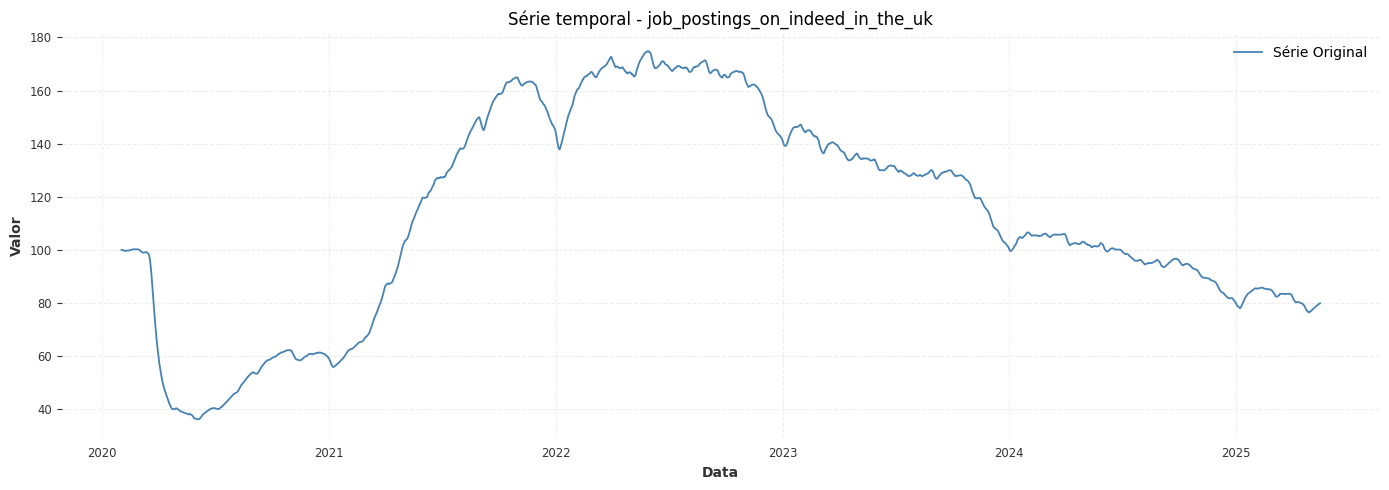

I0000 00:00:1748049975.769641   57895 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5563 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060, pci bus id: 0000:01:00.0, compute capability: 8.9
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


📈 Treino iniciado...
Epoch 1/100


I0000 00:00:1748049980.192478   58047 cuda_dnn.cc:529] Loaded cuDNN version 90501


48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 51ms/step - loss: 0.0783 - mae: 0.2346 - mape: 94377.0625 - mse: 0.1185 - smape_keras: 90.6336 - val_loss: 0.0558 - val_mae: 0.2698 - val_mape: 61.3377 - val_mse: 0.0732 - val_smape_keras: 88.4612 - learning_rate: 5.0000e-04
Epoch 2/100
48/48 ━━━━━━━━━━━━━━━━━━━━ -1s -21204us/step - loss: 0.0242 - mae: 0.0805 - mape: 13109.2891 - mse: 0.0103 - smape_keras: 71.3758 - val_loss: 0.0460 - val_mae: 0.2328 - val_mape: 52.8859 - val_mse: 0.0546 - val_smape_keras: 71.8983 - learning_rate: 5.0000e-04
Epoch 3/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0228 - mae: 0.0720 - mape: 11346.0410 - mse: 0.0084 - smape_keras: 71.0200 - val_loss: 0.0434 - val_mae: 0.2240 - val_mape: 50.8801 - val_mse: 0.0506 - val_smape_keras: 68.2429 - learning_rate: 5.0000e-04
Epoch 4/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0220 - mae: 0.0693 - mape: 44885.6406 - mse: 0.0079 - smape_keras: 71.0310 - val_loss: 0.0402 - val_mae: 0.2116 - val_mape: 48.0523 - val_mse: 0

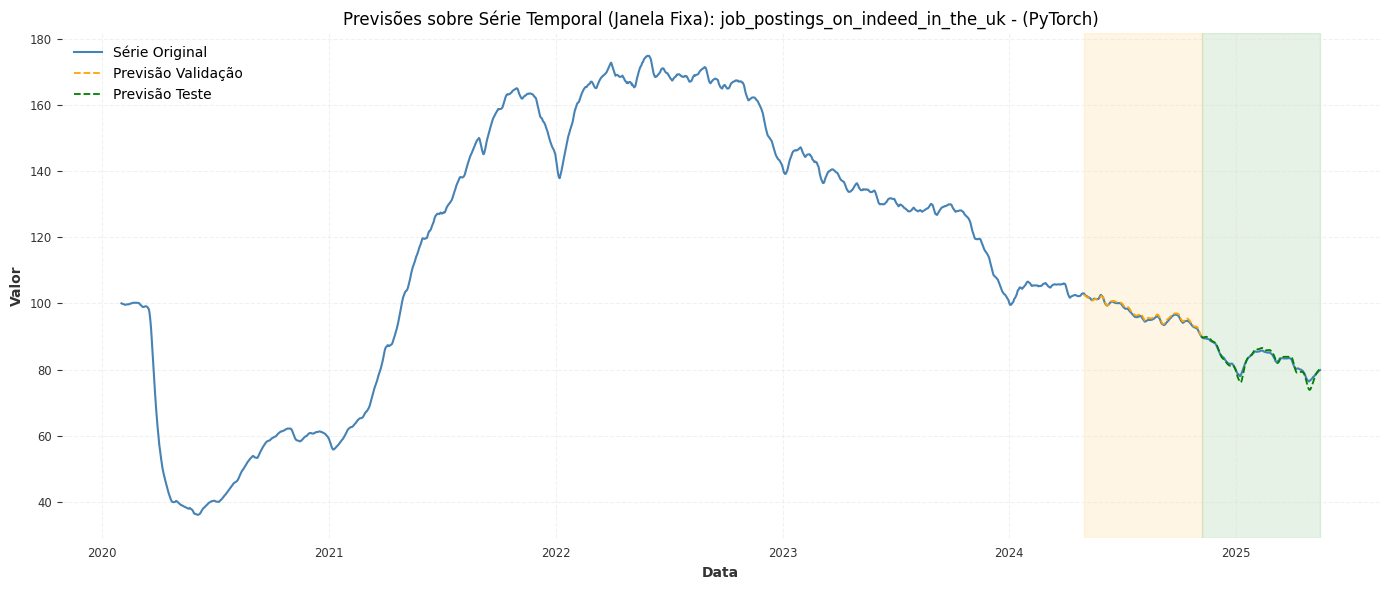

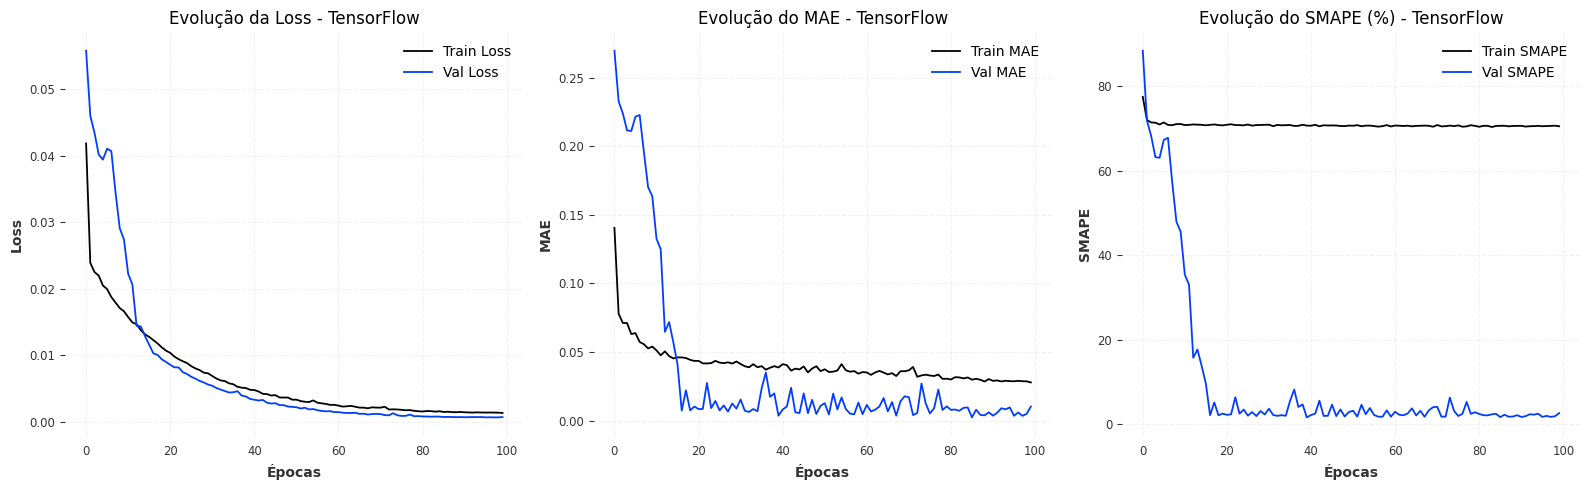

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.
⏱️ Tempo da série job_postings_on_indeed_in_the_uk: 0:02:16
Número de épocas treinadas: 100

🚀 Processando série 2/6: interest_rates_lt_bond_yields_10_year_main_including_benchmark_for_uk

🔄 Treinando modelo Hibrido para: interest_rates_lt_bond_yields_10_year_main_including_benchmark_for_uk


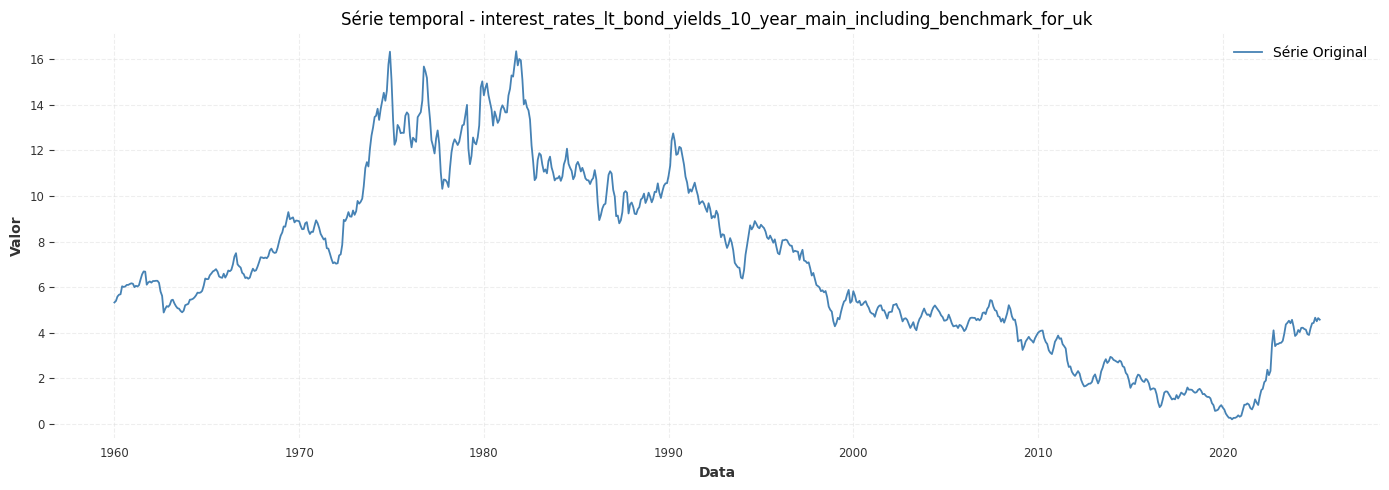

📈 Treino iniciado...
Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 76ms/step - loss: 0.0861 - mae: 0.2684 - mape: 57.7148 - mse: 0.1333 - smape_keras: 89.1582 - val_loss: 0.0201 - val_mae: 0.0293 - val_mape: 31.8240 - val_mse: 0.0013 - val_smape_keras: 26.9452 - learning_rate: 5.0000e-04
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0273 - mae: 0.0999 - mape: 24.0992 - mse: 0.0158 - smape_keras: 48.3021 - val_loss: 0.0216 - val_mae: 0.0600 - val_mape: 82.8569 - val_mse: 0.0047 - val_smape_keras: 54.5085 - learning_rate: 5.0000e-04
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0253 - mae: 0.0858 - mape: 19.9499 - mse: 0.0121 - smape_keras: 49.2798 - val_loss: 0.0270 - val_mae: 0.1212 - val_mape: 153.6586 - val_mse: 0.0159 - val_smape_keras: 82.4637 - learning_rate: 5.0000e-04
Epoch 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0243 - mae: 0.0802 - mape: 18.2732 - mse: 0.0105 - smape_keras: 49.0045 - val_loss: 0.0369 - val_mae: 0.1874 - val_mape: 229.4859 - val_mse: 0.0362 - val_sma

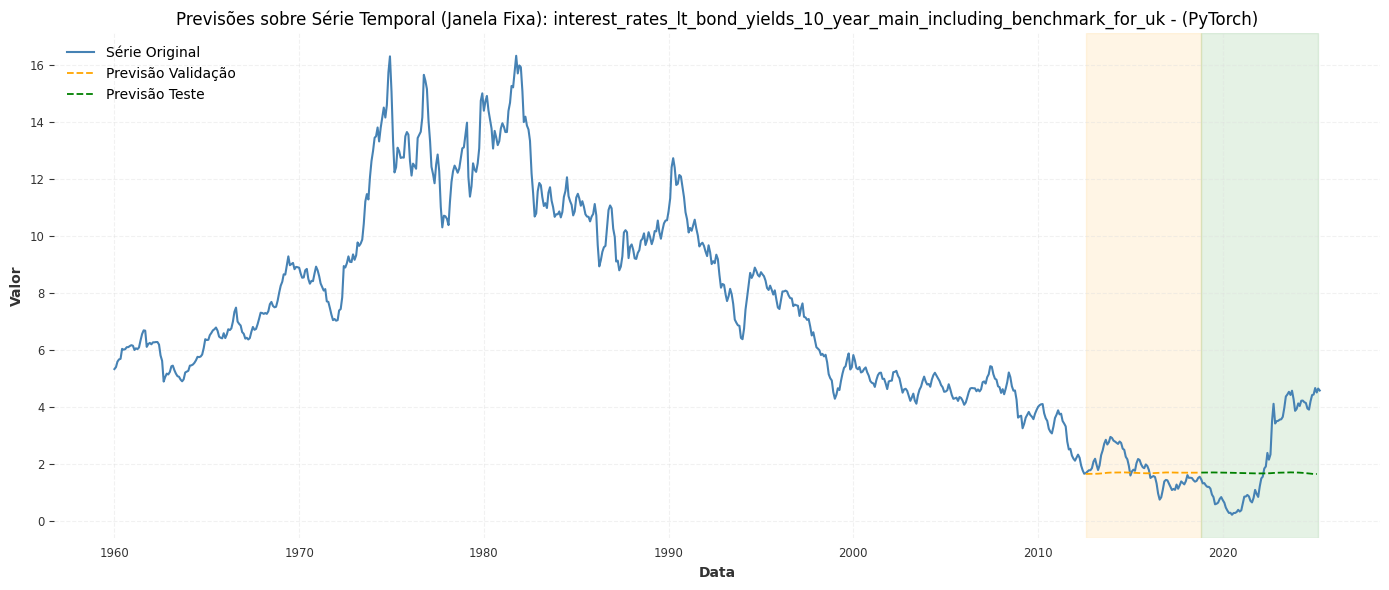

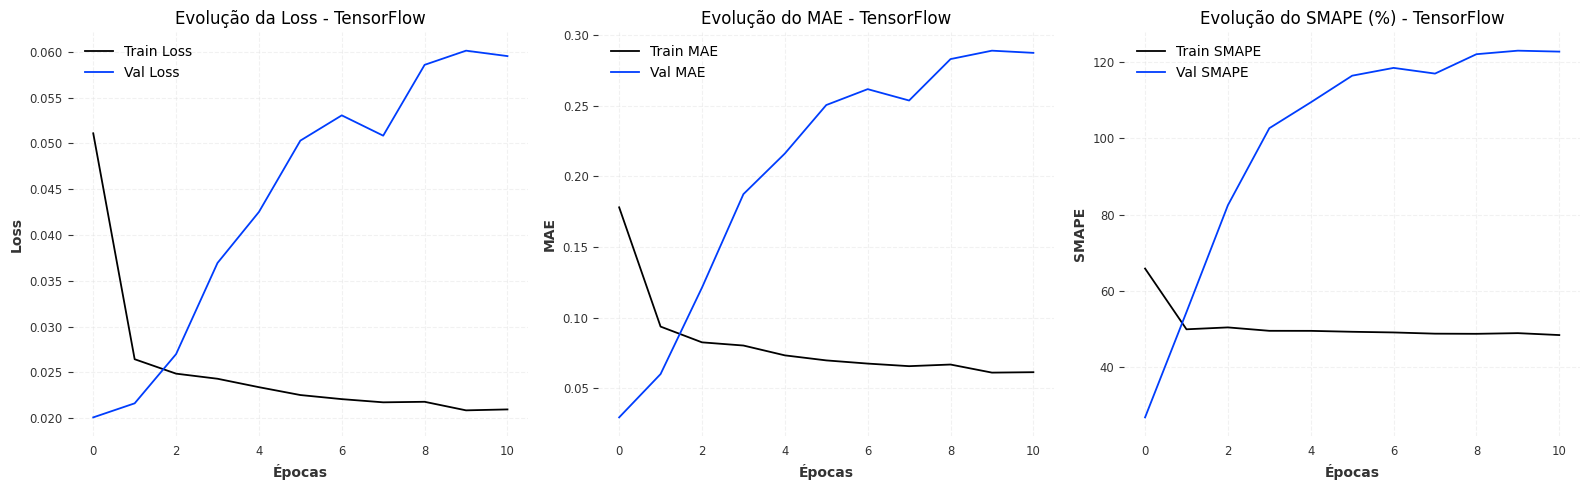

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.
⏱️ Tempo da série interest_rates_lt_bond_yields_10_year_main_including_benchmark_for_uk: 0:00:09
Número de épocas treinadas: 11

🚀 Processando série 3/6: house_prices_for_uk

🔄 Treinando modelo Hibrido para: house_prices_for_uk


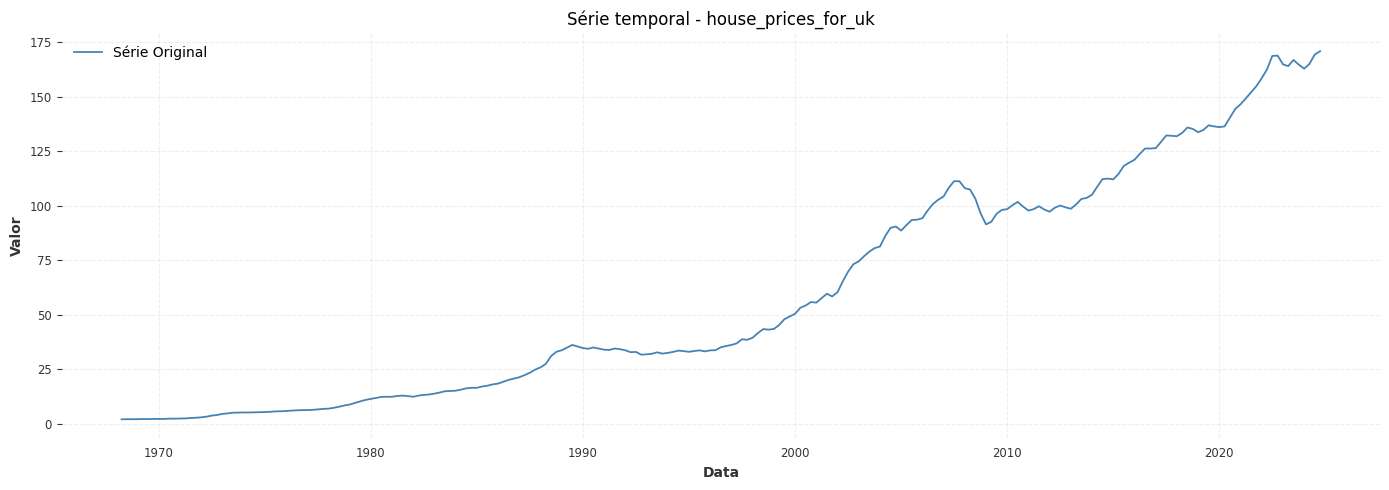

📈 Treino iniciado...
Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 219ms/step - loss: 0.1122 - mae: 0.3144 - mape: 135.1371 - mse: 0.1857 - smape_keras: 149.7795 - val_loss: 0.2666 - val_mae: 0.7018 - val_mape: 94.3731 - val_mse: 0.4942 - val_smape_keras: 178.6615 - learning_rate: 5.0000e-04
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0279 - mae: 0.0971 - mape: 85.7052 - mse: 0.0169 - smape_keras: 85.9174 - val_loss: 0.2453 - val_mae: 0.6707 - val_mape: 90.1802 - val_mse: 0.4516 - val_smape_keras: 164.2047 - learning_rate: 5.0000e-04
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0246 - mae: 0.0747 - mape: 57.1287 - mse: 0.0102 - smape_keras: 94.5270 - val_loss: 0.2389 - val_mae: 0.6611 - val_mape: 88.8850 - val_mse: 0.4389 - val_smape_keras: 159.9773 - learning_rate: 5.0000e-04
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0233 - mae: 0.0634 - mape: 57.8572 - mse: 0.0077 - smape_keras: 93.3993 - val_loss: 0.2331 - val_mae: 0.6524 - val_mape: 87.7038 - val_mse: 0.4274 - val_smape_k

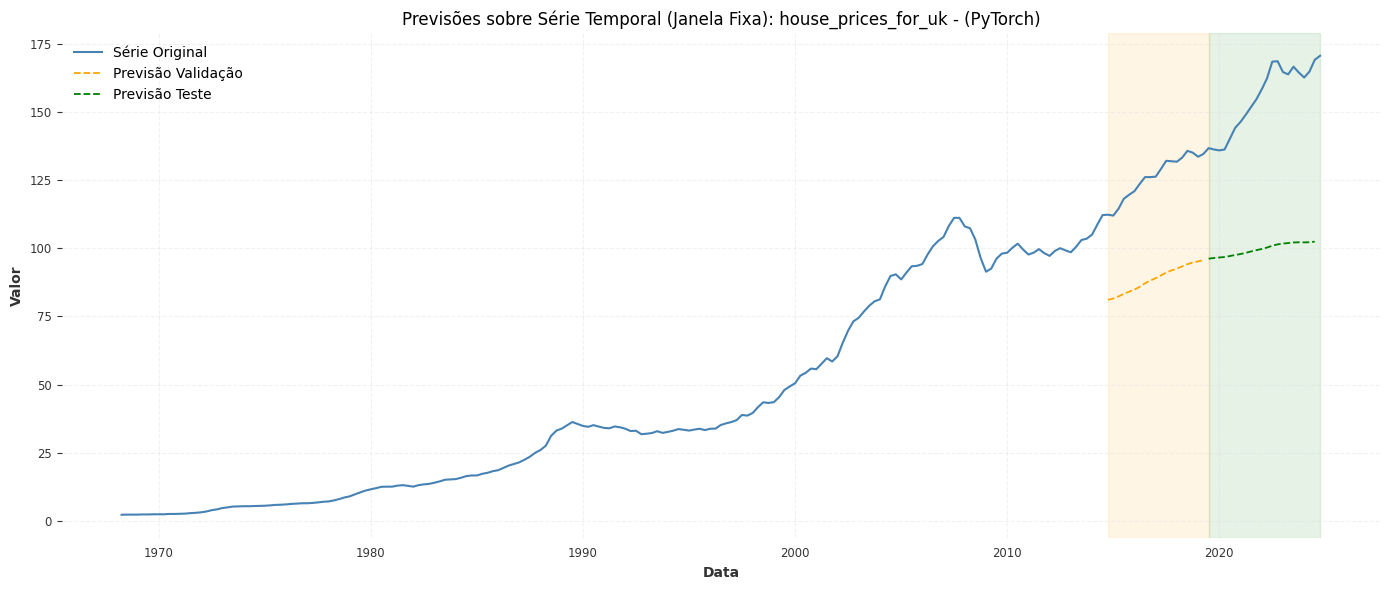

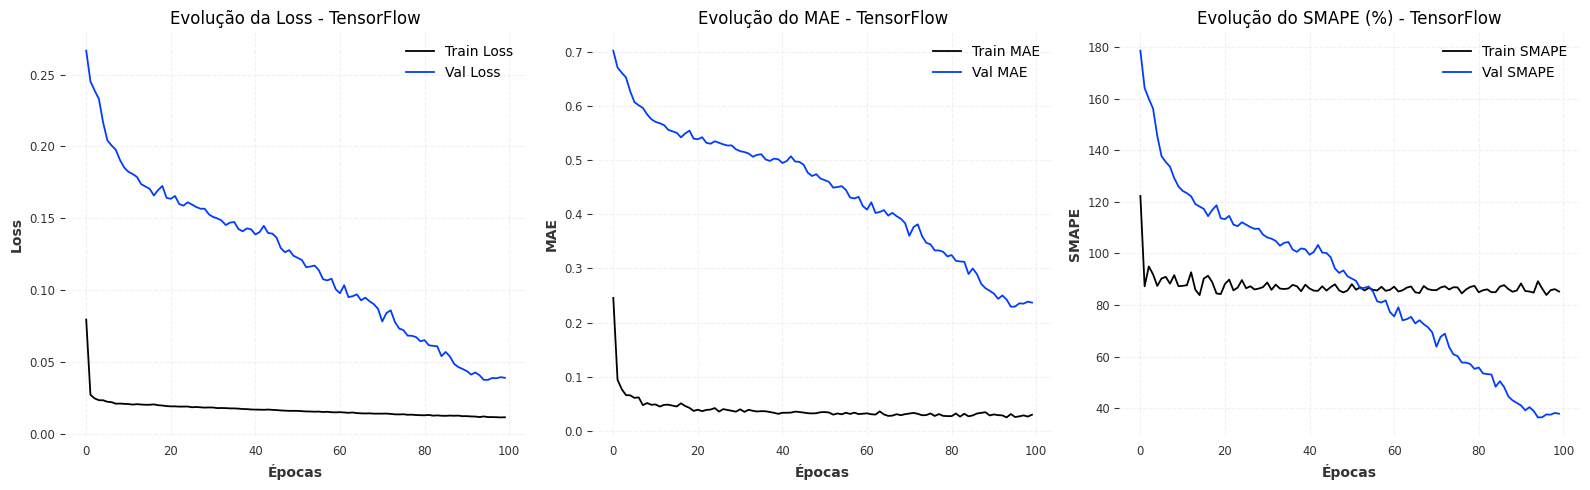

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.
⏱️ Tempo da série house_prices_for_uk: 0:00:31
Número de épocas treinadas: 100

🚀 Processando série 4/6: gdp_for_uk

🔄 Treinando modelo Hibrido para: gdp_for_uk


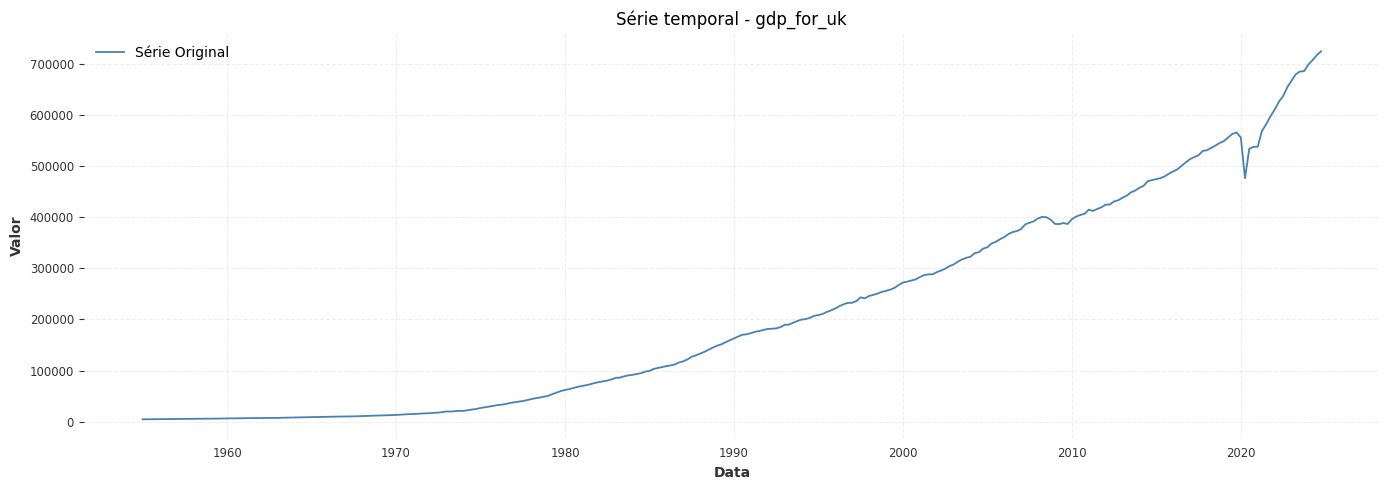

📈 Treino iniciado...
Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 174ms/step - loss: 0.0460 - mae: 0.1620 - mape: 304.0339 - mse: 0.0530 - smape_keras: 130.5598 - val_loss: 0.2038 - val_mae: 0.6057 - val_mape: 90.9328 - val_mse: 0.3687 - val_smape_keras: 166.6519 - learning_rate: 5.0000e-04
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0256 - mae: 0.0889 - mape: 237.5800 - mse: 0.0123 - smape_keras: 124.7846 - val_loss: 0.2034 - val_mae: 0.6051 - val_mape: 90.8370 - val_mse: 0.3679 - val_smape_keras: 166.3341 - learning_rate: 5.0000e-04
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0230 - mae: 0.0664 - mape: 280.7059 - mse: 0.0072 - smape_keras: 104.9065 - val_loss: 0.1944 - val_mae: 0.5901 - val_mape: 88.5788 - val_mse: 0.3501 - val_smape_keras: 158.9328 - learning_rate: 5.0000e-04
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0235 - mae: 0.0732 - mape: 221.8253 - mse: 0.0084 - smape_keras: 126.8712 - val_loss: 0.1995 - val_mae: 0.5989 - val_mape: 89.8840 - val_mse: 0.3606 - val_s

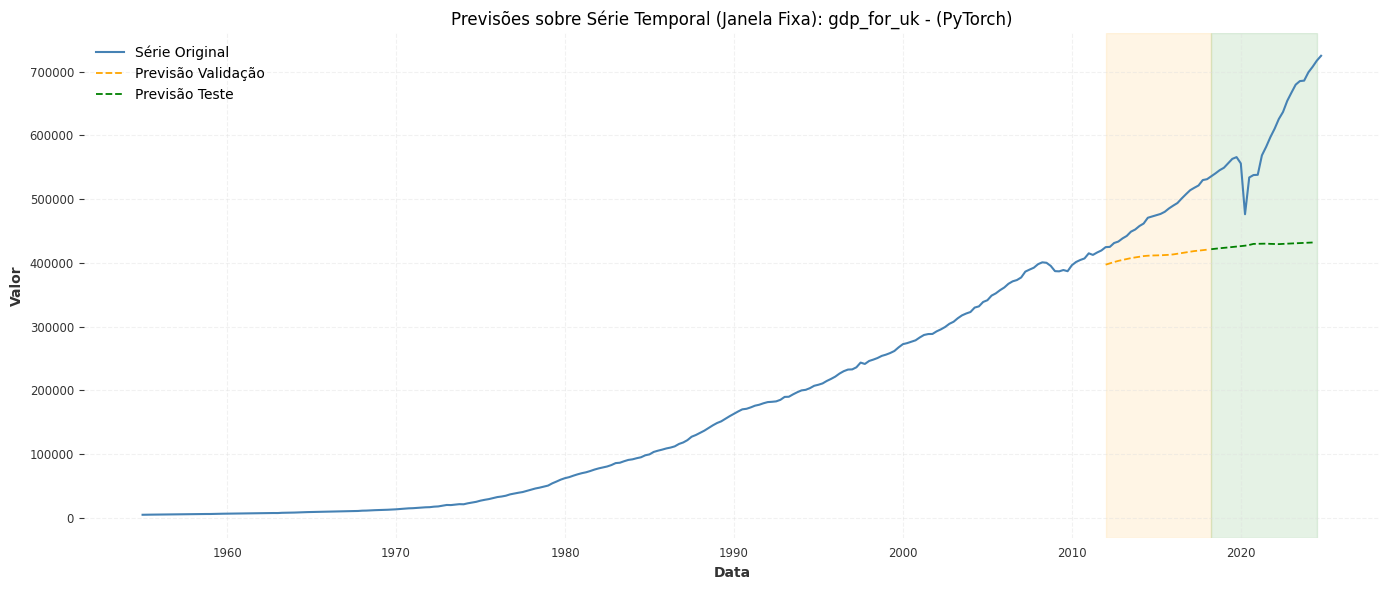

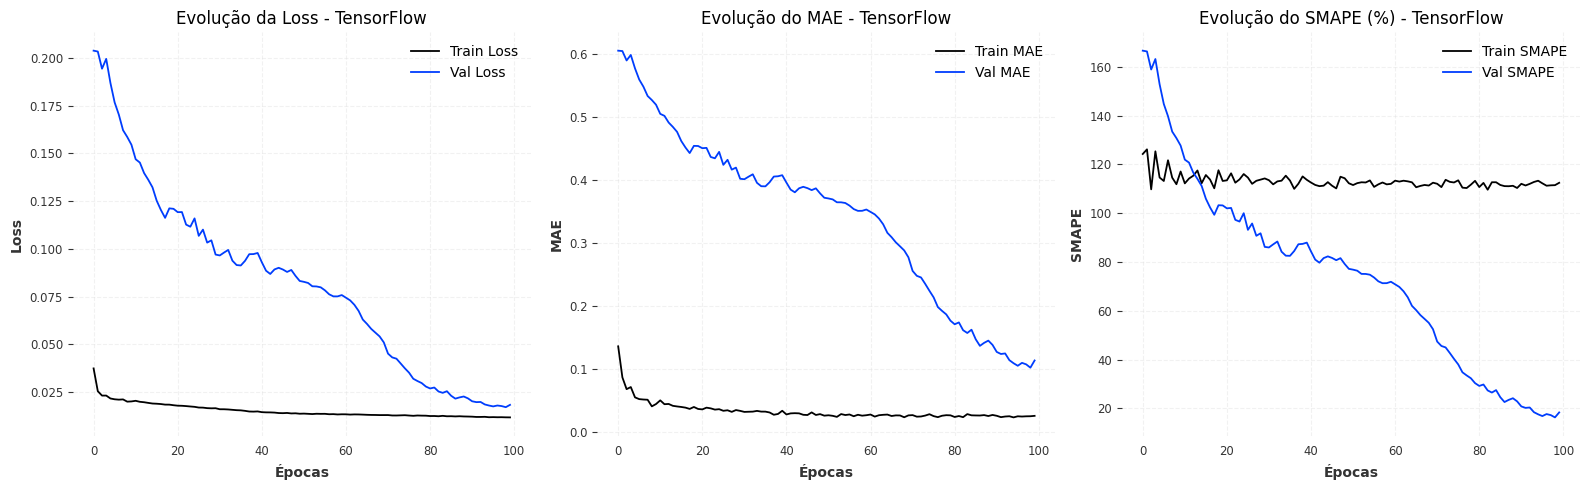

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.
⏱️ Tempo da série gdp_for_uk: 0:00:36
Número de épocas treinadas: 100

🚀 Processando série 5/6: consumer_price_indices_cpis_hicps_coicop_1999_cpi_total_for_uk

🔄 Treinando modelo Hibrido para: consumer_price_indices_cpis_hicps_coicop_1999_cpi_total_for_uk


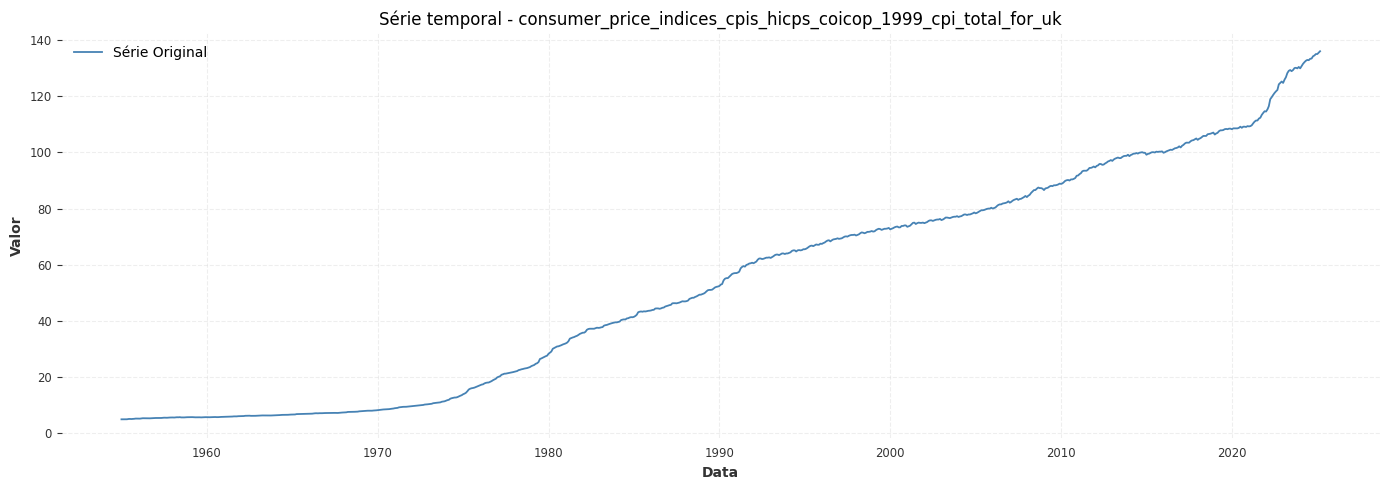

📈 Treino iniciado...
Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 80ms/step - loss: 0.0344 - mae: 0.1291 - mape: 218.3339 - mse: 0.0306 - smape_keras: 116.3361 - val_loss: 0.2445 - val_mae: 0.6713 - val_mape: 92.7832 - val_mse: 0.4511 - val_smape_keras: 173.0434 - learning_rate: 5.0000e-04
Epoch 2/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0222 - mae: 0.0651 - mape: 147.0964 - mse: 0.0067 - smape_keras: 107.2576 - val_loss: 0.2424 - val_mae: 0.6686 - val_mape: 92.3987 - val_mse: 0.4475 - val_smape_keras: 171.8574 - learning_rate: 5.0000e-04
Epoch 3/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0212 - mae: 0.0565 - mape: 105.4644 - mse: 0.0054 - smape_keras: 106.7960 - val_loss: 0.2299 - val_mae: 0.6503 - val_mape: 89.8603 - val_mse: 0.4234 - val_smape_keras: 163.4401 - learning_rate: 5.0000e-04
Epoch 4/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0204 - mae: 0.0527 - mape: 112.9274 - mse: 0.0046 - smape_keras: 105.2058 - val_loss: 0.2074 - val_mae: 0.6153 - val_mape: 85.0229 - val_mse: 0.3791 

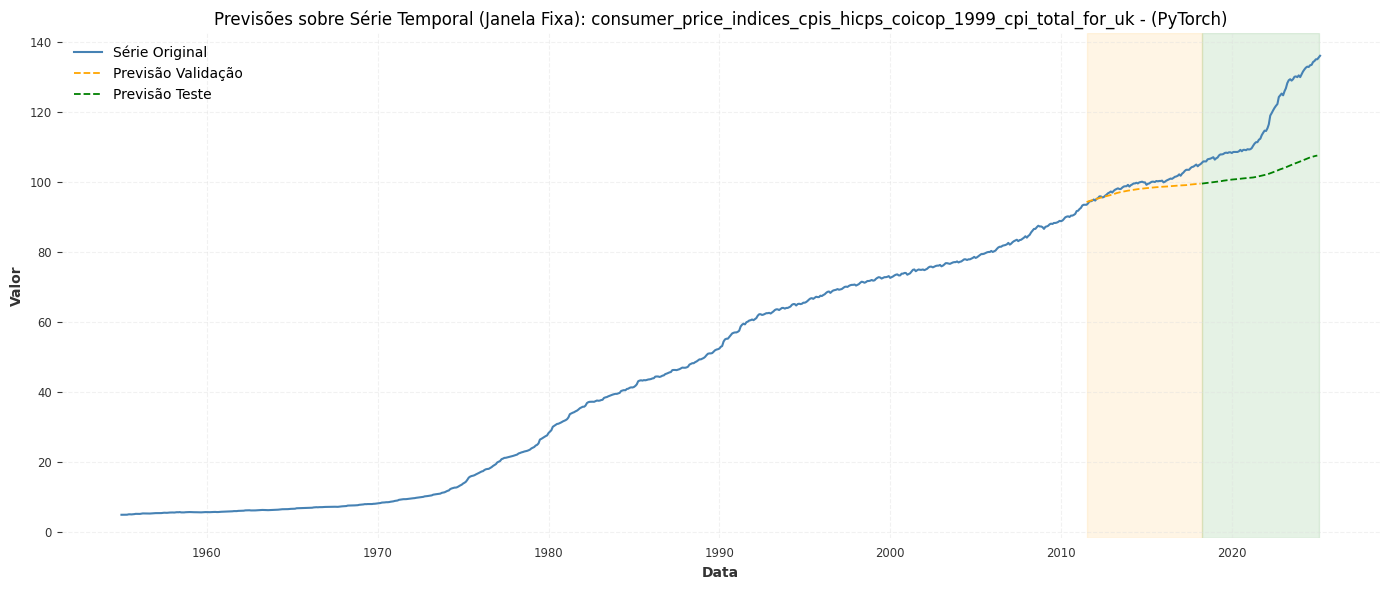

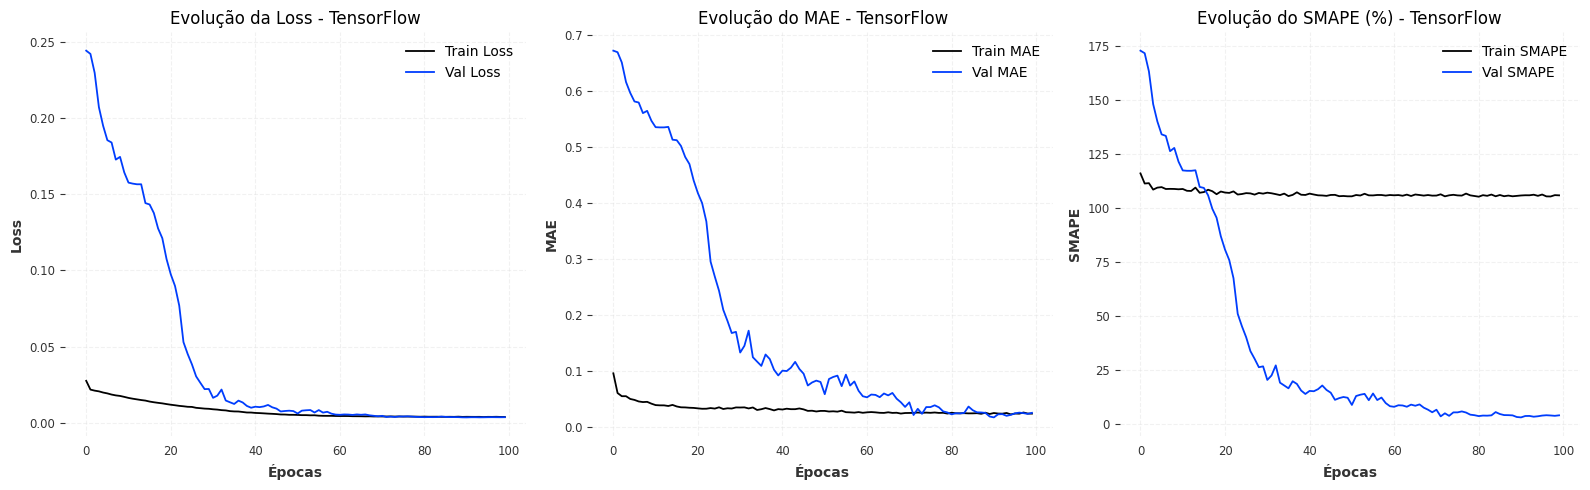

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.
⏱️ Tempo da série consumer_price_indices_cpis_hicps_coicop_1999_cpi_total_for_uk: 0:01:09
Número de épocas treinadas: 100

🚀 Processando série 6/6: uk_daily_policy_data

🔄 Treinando modelo Hibrido para: uk_daily_policy_data


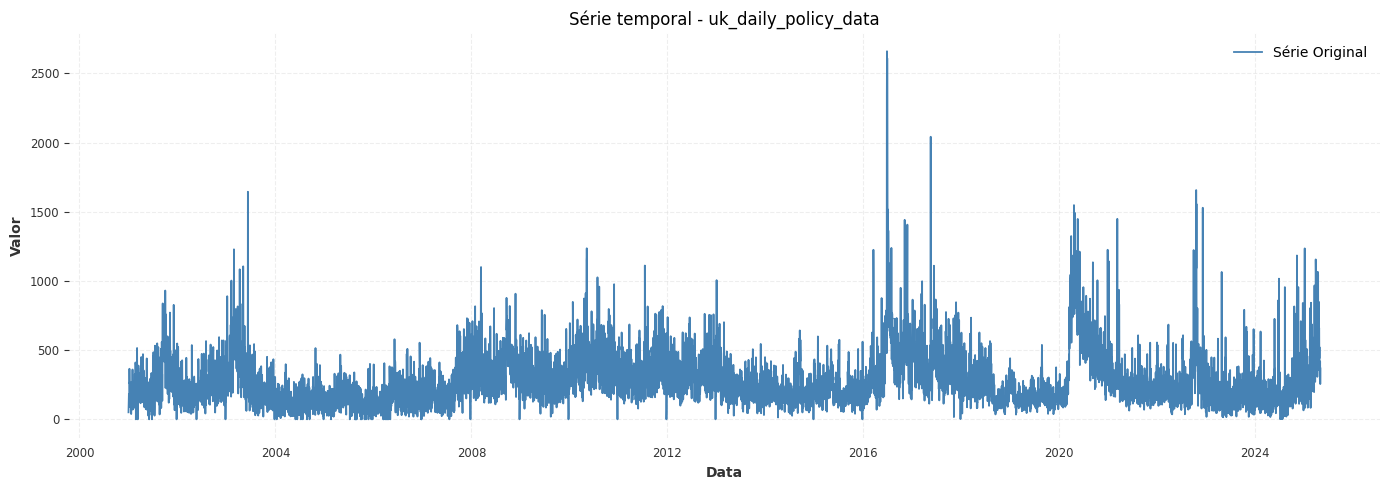

📈 Treino iniciado...
Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - loss: 0.0200 - mae: 0.0502 - mape: 429564.2812 - mse: 0.0049 - smape_keras: 68.5384 - val_loss: 0.0141 - val_mae: 0.0488 - val_mape: 43.1584 - val_mse: 0.0056 - val_smape_keras: 41.6080 - learning_rate: 5.0000e-04
Epoch 2/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - loss: 0.0113 - mae: 0.0397 - mape: 435539.0312 - mse: 0.0031 - smape_keras: 60.7514 - val_loss: 0.0084 - val_mae: 0.0451 - val_mape: 42.2986 - val_mse: 0.0047 - val_smape_keras: 38.7080 - learning_rate: 5.0000e-04
Epoch 3/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - loss: 0.0067 - mae: 0.0384 - mape: 432775.6875 - mse: 0.0029 - smape_keras: 59.9581 - val_loss: 0.0053 - val_mae: 0.0394 - val_mape: 34.6520 - val_mse: 0.0039 - val_smape_keras: 34.5846 - learning_rate: 5.0000e-04
Epoch 4/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - loss: 0.0044 - mae: 0.0378 - mape: 427691.9688 - mse: 0.0029 - smape_keras: 59.4085 - val_loss: 0.0037 - val_mae: 0.0368 - val_mape: 32.0910 - val

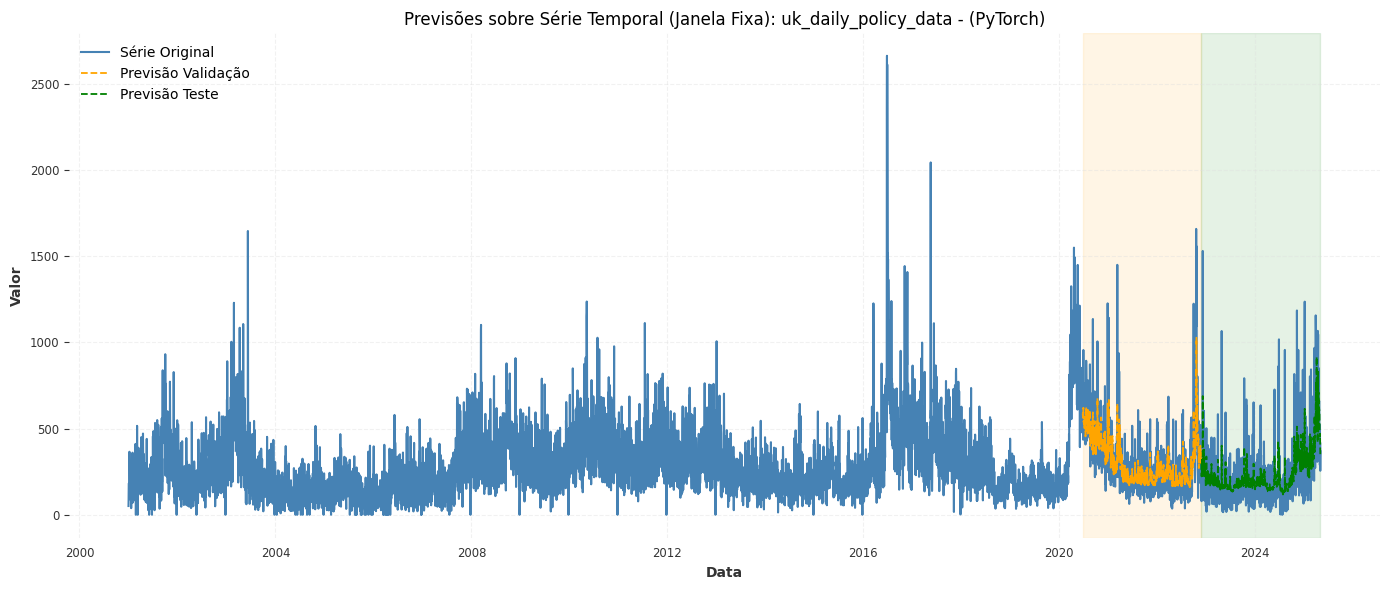

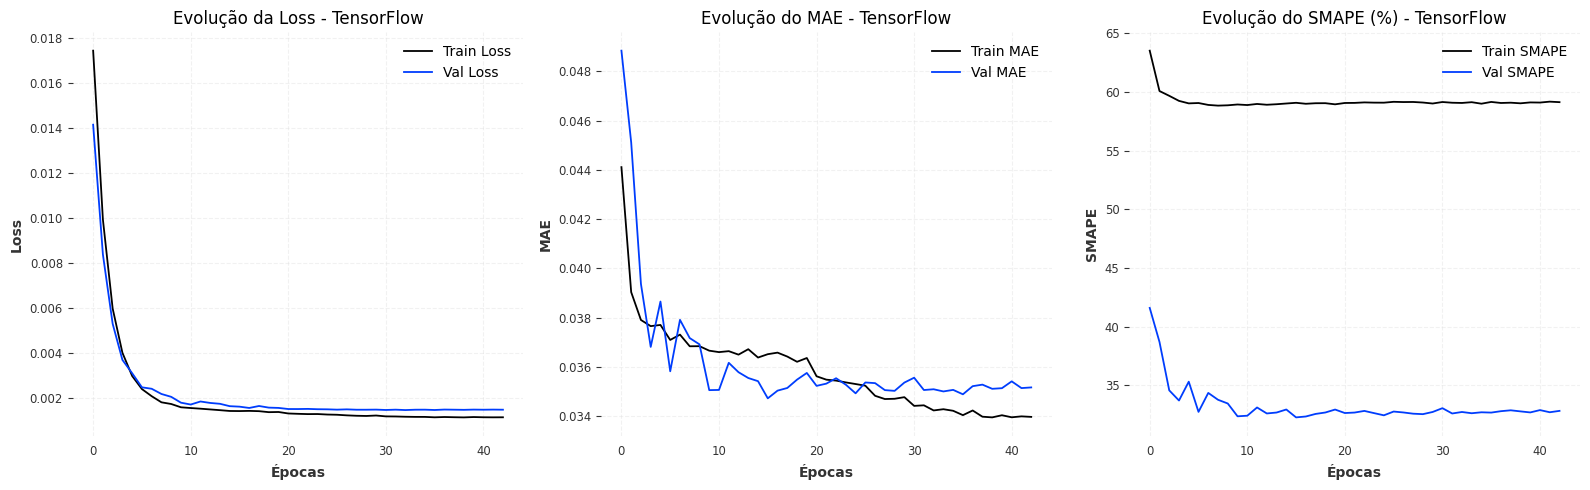

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.
⏱️ Tempo da série uk_daily_policy_data: 0:04:01
Número de épocas treinadas: 43

📊 RESUMO DE TEMPOS
1. job_postings_on_indeed_in_the_uk: 0:02:16
2. interest_rates_lt_bond_yields_10_year_main_including_benchmark_for_uk: 0:00:09
3. house_prices_for_uk: 0:00:31
4. gdp_for_uk: 0:00:36
5. consumer_price_indices_cpis_hicps_coicop_1999_cpi_total_for_uk: 0:01:09
6. uk_daily_policy_data: 0:04:01

⏱️ TEMPO TOTAL: 0:08:45


In [20]:
import time
from datetime import timedelta
from tensorflow.keras.utils import plot_model

# Variável para armazenar o tempo total
tempo_total_inicio = time.time()

# Lista para armazenar tempos individuais
tempos_series = []

for idx, serie in enumerate(fred_series_list, 1):
    try:
        print(f"\n{'='*50}")
        print(f"🚀 Processando série {idx}/{len(fred_series_list)}: {serie.name}")
        
        # Inicia cronômetro para esta série
        inicio_serie = time.time()
        
        # Rodar com parâmetros padrão
        model, history = treinar_para_serie(serie, seq_length=30, usar_hibrido=True)
        plot_model(model, to_file='modelo.png', show_shapes=True, show_layer_names=True)
        
        # Calcula tempo desta série
        tempo_serie = time.time() - inicio_serie
        tempos_series.append(tempo_serie)
        
        # Exibe tempo desta série formatado
        print(f"⏱️ Tempo da série {serie.name}: {str(timedelta(seconds=tempo_serie)).split('.')[0]}")
        n_epocas_reais = len(history.epoch)
        print(f"Número de épocas treinadas: {n_epocas_reais}")
        
    except ValueError as ve:
        print(f"❌ Série {serie.name} ignorada - {str(ve)}")
    except Exception as e:
        print(f"❌ Erro inesperado na série {serie.name}: {str(e)}")
        continue

# Calcula tempo total
tempo_total = time.time() - tempo_total_inicio

# Exibe resumo de tempos
print("\n" + "="*50)
print("📊 RESUMO DE TEMPOS")
print("="*50)
for i, (serie, tempo) in enumerate(zip(fred_series_list, tempos_series), 1):
    print(f"{i}. {serie.name}: {str(timedelta(seconds=tempo)).split('.')[0]}")

print("\n" + "="*50)
print(f"⏱️ TEMPO TOTAL: {str(timedelta(seconds=tempo_total)).split('.')[0]}")
print("="*50)

#### 2.1.2. Janela Deslizante (Sliding/Rolling Window)

Janela de previsão:   0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
Janela de previsão:  10%|█         | 1/10 [00:16<02:31, 16.89s/it]/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
Janela de previsão:  20%|██        | 2/10 [00:33<02:13, 16.68s/it]/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
Janela de previsão:  30%|███       | 3/10 [00:46<01:46, 15.26s/it]/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
Janela de previsão:  40%|████      | 4/10 [01:00<01:27, 14.59s/it]/usr/local/lib/pytho

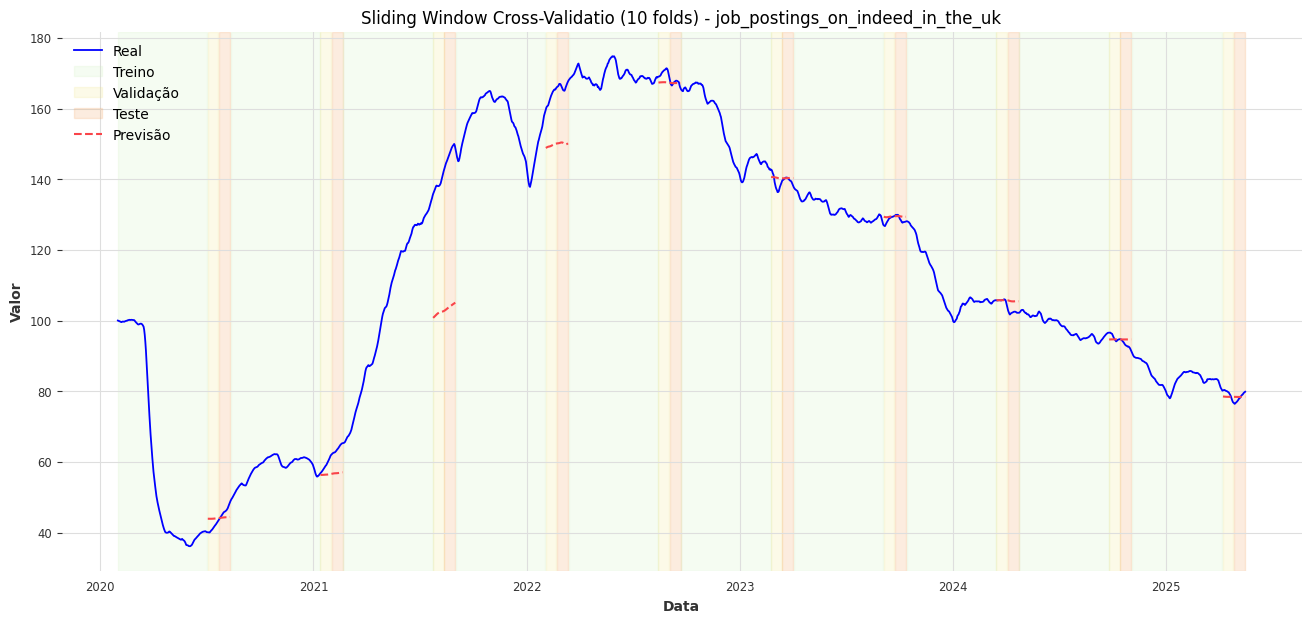

Métricas por janela:
 Janela Data Início   Data Fim       MAE     SMAPE
      1  2020-02-01 2020-08-11  2.117839  4.854939
      2  2020-08-12 2021-02-20  4.789150  8.021190
      3  2021-02-21 2021-09-01 39.942223 32.443325
      4  2021-09-02 2022-03-13 14.915745  9.474665
      5  2022-03-14 2022-09-22  1.676931  0.994445
      6  2022-09-23 2023-04-03  1.409703  1.011490
      7  2023-04-04 2023-10-13  0.926322  0.720250
      8  2023-10-14 2024-04-23  1.735770  1.669414
      9  2024-04-24 2024-11-02  1.150418  1.221388
     10  2024-11-03 2025-05-16  1.162591  1.480284

Tempo total de execução: 134.83 segundos


In [21]:
def smape(y_true, y_pred):
    return 200 * np.abs(y_true - y_pred) / (np.abs(y_true) + np.abs(y_pred) + 1e-6)

def prever_com_rolling(serie, nome_serie_curto, seq_length=12, n_epochs=5, usar_hibrido=True):
    serie = serie.dropna()
    total_len = len(serie)
    n_splits = 10
    tam_janela = total_len // n_splits

    resultados = []

    # Cores para demarcação
    cores = {'train': '#d0f0c0', 'val': '#f0e68c', 'test': '#f4a460'}

    plt.figure(figsize=(16, 7))
    plt.plot(serie, label='Real', color='blue')

    start_time = time.time()  # Início do tempo total

    for i in tqdm(range(n_splits), desc="Janela de previsão"):
        inicio = i * tam_janela
        fim = inicio + tam_janela if i < n_splits - 1 else total_len

        dados = serie.iloc[inicio:fim]
        if len(dados) < seq_length + 3:
            continue

        n_train = int(0.8 * len(dados))
        n_val = int(0.10 * len(dados))
        n_test = len(dados) - n_train - n_val

        treino = dados.iloc[:n_train]
        val = dados.iloc[n_train:n_train + n_val]
        teste = dados.iloc[n_train + n_val:]

        # Demarcação das zonas
        plt.axvspan(treino.index[0], treino.index[-1], color=cores['train'], alpha=0.2, label='Treino' if i==0 else "")
        plt.axvspan(val.index[0], val.index[-1], color=cores['val'], alpha=0.2, label='Validação' if i==0 else "")
        plt.axvspan(teste.index[0], teste.index[-1], color=cores['test'], alpha=0.2, label='Teste' if i==0 else "")

        # Escalar só com treino
        scaler = MinMaxScaler()
        scaler.fit(treino.values.reshape(-1, 1))
        dados_scaled = scaler.transform(dados.values.reshape(-1, 1)).flatten()

        # Preparar dados de treino
        X_train, y_train = [], []
        for j in range(seq_length, n_train):
            X_train.append(dados_scaled[j - seq_length:j])
            y_train.append(dados_scaled[j])
        X_train = np.array(X_train).reshape(-1, seq_length, 1)
        y_train = np.array(y_train).reshape(-1, 1)

        # Preparar dados de validação
        X_val, y_val = [], []
        for j in range(n_train + seq_length, n_train + n_val):
            X_val.append(dados_scaled[j - seq_length:j])
            y_val.append(dados_scaled[j])
        X_val = np.array(X_val).reshape(-1, seq_length, 1)
        y_val = np.array(y_val).reshape(-1, 1)

        model = criar_modelo(seq_length, usar_hibrido)
        model.fit(
            X_train, y_train,
            batch_size=32,
            epochs=n_epochs,
            verbose=0,
            validation_data=(X_val, y_val),
            callbacks=[early_stopping, checkpoint, reduce_lr]
        )

        preds = []
        reais = []

        # Fazer previsões apenas na validação + teste
        start_pred = n_train
        end_pred = len(dados)
        indices_pred = dados.index[start_pred:end_pred]

        for j in range(start_pred, end_pred):
            seq = dados_scaled[j - seq_length:j].reshape(1, seq_length, 1)
            pred_scaled = model.predict(seq, verbose=0)[0, 0]
            pred = scaler.inverse_transform([[pred_scaled]])[0, 0]
            real = dados.iloc[j]
            preds.append(pred)
            reais.append(real)

        preds = np.array(preds)
        reais = np.array(reais)

        # Plotar as previsões só da janela atual
        plt.plot(indices_pred, preds,
         label='Previsão' if i == 0 else "",
         color='#f94449',
         linestyle='--',
         linewidth=1.5)

        mae = np.mean(np.abs(preds - reais))
        smape_score = np.mean(smape(reais, preds))

        resultados.append({
            'Janela': i + 1,
            'Data Início': dados.index[0],
            'Data Fim': dados.index[-1],
            'MAE': mae,
            'SMAPE': smape_score
        })

    end_time = time.time()  # Fim do tempo total
    tempo_total = end_time - start_time

    plt.title(f'Sliding Window Cross-Validatio (10 folds): {nome_serie_curto} - (TensorFlow)')
    plt.xlabel('Data')
    plt.ylabel('Valor')
    plt.legend()
    plt.grid(True)
    plt.show()

    resultados_df = pd.DataFrame(resultados)
    print("Métricas por janela:")
    print(resultados_df.to_string(index=False))
    print(f"\nTempo total de execução: {tempo_total:.2f} segundos")

    return resultados_df

# Exemplo de chamada
resultados = prever_com_rolling(fred_series_list[0], fred_series_list[0].name, seq_length=12, n_epochs=50, usar_hibrido=True)

### 2.2. PyTorch

In [101]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score

In [102]:
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)       # Para GPUs CUDA
    torch.cuda.manual_seed_all(seed)   # Se estiveres a usar várias GPUs
    np.random.seed(seed)                # Seed para numpy
    random.seed(seed)                   # Seed para a biblioteca random do Python
    torch.backends.cudnn.deterministic = True  # Garante resultados determinísticos no cuDNN
    torch.backends.cudnn.benchmark = False     # Desativa otimizações que podem variar resultados

# Exemplo de uso
set_seed(42)

In [103]:
!nvidia-smi

Sat May 24 01:47:11 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 576.40                 Driver Version: 576.40         CUDA Version: 12.9     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4060      WDDM  |   00000000:01:00.0  On |                  N/A |
| 30%   43C    P5            N/A  /  115W |    1847MiB /   8188MiB |     28%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [104]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn.functional as F

In [105]:
torch.cuda.is_available()

True

In [106]:
# Criar diretório para salvar modelos se não existir
os.makedirs('modelos_pytorch', exist_ok=True)

# Configuração inicial
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)
    device = torch.device('cuda')
    print("✅ GPU disponível:", torch.cuda.get_device_name(0))
else:
    device = torch.device('cpu')
    print("⚠️ A usar CPU")

✅ GPU disponível: NVIDIA GeForce RTX 4060


In [107]:
def smape(y_true, y_pred):
    numerator = np.abs(y_pred - y_true)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    # Evitar divisão por zero
    denominator = np.where(denominator == 0, 1, denominator)
    return np.mean(numerator / denominator) * 100


class TemporalCNN(nn.Module):
    def __init__(self, seq_length, usar_hibrido=False):
        super(TemporalCNN, self).__init__()
        self.usar_hibrido = usar_hibrido

        # CNNs alinhadas com Keras
        self.conv1 = nn.Conv1d(1, 128, kernel_size=7, padding='same')
        self.bn1 = nn.BatchNorm1d(128)
        self.leaky1 = nn.LeakyReLU(0.01)
        self.drop1 = nn.Dropout(0.1)

        self.conv2 = nn.Conv1d(128, 64, kernel_size=5, padding='same')
        self.bn2 = nn.BatchNorm1d(64)
        self.leaky2 = nn.LeakyReLU(0.01)
        self.drop2 = nn.Dropout(0.1)

        self.conv3 = nn.Conv1d(64, 32, kernel_size=3, padding='same')
        self.bn3 = nn.BatchNorm1d(32)
        self.leaky3 = nn.LeakyReLU(0.01)
        self.drop3 = nn.Dropout(0.1)

        if usar_hibrido:
            # Híbrido com Bidirectional LSTM
            self.lstm1 = nn.LSTM(32, 64, batch_first=True, bidirectional=True, dropout=0.1)
            self.lstm2 = nn.LSTM(128, 32, batch_first=True, bidirectional=True, dropout=0.1)
            self.drop_lstm = nn.Dropout(0.1)
            self.fc1 = nn.Linear(64, 64)  # 32*2 -> 64
        else:
            self.global_pool = nn.AdaptiveMaxPool1d(1)
            self.fc1 = nn.Linear(32, 64)

        self.drop_fc = nn.Dropout(0.1)
        self.fc2 = nn.Linear(64, 1)

        # Inicialização dos pesos
        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv1d) or isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, nonlinearity='leaky_relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.LSTM):
                for name, param in m.named_parameters():
                    if 'weight_ih' in name:
                        nn.init.xavier_uniform_(param.data)
                    elif 'weight_hh' in name:
                        nn.init.orthogonal_(param.data)
                    elif 'bias' in name:
                        nn.init.constant_(param.data, 0)
                        # Gate forget bias
                        n = param.size(0)
                        param.data[n//4:n//2].fill_(1)

    def forward(self, x):
        # (batch, seq_length, 1) -> (batch, 1, seq_length)
        x = x.permute(0, 2, 1)

        x = self.drop1(self.leaky1(self.bn1(self.conv1(x))))
        x = self.drop2(self.leaky2(self.bn2(self.conv2(x))))
        x = self.drop3(self.leaky3(self.bn3(self.conv3(x))))

        if self.usar_hibrido:
            x = x.permute(0, 2, 1)  # Para LSTM: (batch, seq_len, features)
            x, _ = self.lstm1(x)
            x, _ = self.lstm2(x)
            x = self.drop_lstm(x)
            x = x[:, -1, :]  # último passo de tempo
        else:
            x = self.global_pool(x).squeeze(-1)

        x = self.drop_fc(F.relu(self.fc1(x)))
        return self.fc2(x)

In [108]:
import os

class EarlyStopping:
    def __init__(self, patience=10, restore_best_weights=True):
        self.patience = patience
        self.restore_best_weights = restore_best_weights
        self.best_loss = float('inf')
        self.counter = 0
        self.best_state = None
        self.early_stop = False

    def __call__(self, val_loss, model):
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.counter = 0
            if self.restore_best_weights:
                self.best_state = model.state_dict()
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
                if self.restore_best_weights and self.best_state is not None:
                    model.load_state_dict(self.best_state)

class ModelCheckpoint:
    def __init__(self, filepath, save_best_only=True):
        self.filepath = filepath
        self.save_best_only = save_best_only
        self.best_loss = float('inf')

        dirname = os.path.dirname(filepath)
        if dirname != "":
            os.makedirs(dirname, exist_ok=True)

    def __call__(self, val_loss, model):
        if self.save_best_only:
            if val_loss < self.best_loss:
                self.best_loss = val_loss
                torch.save(model.state_dict(), self.filepath)
        else:
            torch.save(model.state_dict(), self.filepath)

In [109]:
if not os.path.exists("modelos_pytorch"):
    os.makedirs("modelos_pytorch")

#### 2.2.1. Janela Fixa (Fixed Window)

In [ ]:
# Dispositivo (CPU ou GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Funções de preparação de dados (iguais às do TensorFlow)
def criar_janelas(serie, seq_length):
    X, y = [], []
    for i in range(len(serie) - seq_length):
        X.append(serie[i:i+seq_length])
        y.append(serie[i+seq_length])
    return np.array(X), np.array(y)

def preparar_dados(serie, seq_length=30):
    if not hasattr(serie, 'index') or not isinstance(serie.index, pd.DatetimeIndex):
        raise ValueError("❌ A série deve ter um índice datetime.")
    
    serie = serie.dropna()
    if len(serie) < seq_length + 30:
        raise ValueError(f"❌ Série muito curta: {len(serie)} pontos. Mínimo necessário: {seq_length + 30}")
    
    scaler = MinMaxScaler()
    serie_scaled = scaler.fit_transform(serie.values.reshape(-1, 1)).flatten()

    X, y = criar_janelas(serie_scaled, seq_length)

    n = len(X)
    train_end = int(0.8 * n)
    val_end = train_end + int(0.1 * n)

    X_train = torch.FloatTensor(X[:train_end]).unsqueeze(-1).to(device)
    y_train = torch.FloatTensor(y[:train_end]).to(device)
    
    X_val = torch.FloatTensor(X[train_end:val_end]).unsqueeze(-1).to(device)
    y_val = torch.FloatTensor(y[train_end:val_end]).to(device)
    
    X_test = torch.FloatTensor(X[val_end:]).unsqueeze(-1).to(device)
    y_test = torch.FloatTensor(y[val_end:]).to(device)

    return X_train, X_val, X_test, y_train, y_val, y_test, scaler, serie_scaled

# Visualização (igual ao TensorFlow)
def visualizar_serie_original(serie, titulo):
    plt.figure(figsize=(14, 5))
    plt.plot(serie.index, serie.values, label='Série Original', color='steelblue')
    plt.title(f'Série Temporal - {titulo}')
    plt.xlabel("Data")
    plt.ylabel("Valor")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()

def visualizar_resultados(serie, y_val_inv, y_val_pred_inv, y_test_inv, y_test_pred_inv, seq_length, serie_name):
    plt.figure(figsize=(14, 6))
    indices = serie.index

    # Índices de início
    n_total = len(serie) - seq_length - 2
    idx_val = int(0.8 * n_total)
    idx_test = int(0.9 * n_total)

    # Construção das previsões
    previsao_val = np.full_like(serie.values, fill_value=np.nan, dtype=np.float32)
    previsao_test = np.full_like(serie.values, fill_value=np.nan, dtype=np.float32)

    # Insere previsões após o final do treino
    val_start_idx = seq_length + idx_val
    val_end_idx = val_start_idx + len(y_val_pred_inv)
    test_start_idx = seq_length + idx_test
    test_end_idx = test_start_idx + len(y_test_pred_inv)

    # Garante que as previsões não ultrapassem o tamanho da série
    val_end_idx = min(val_end_idx, len(serie))
    test_end_idx = min(test_end_idx, len(serie))

    # Insere as previsões nas posições corretas
    previsao_val[val_start_idx:val_end_idx] = y_val_pred_inv.flatten()
    previsao_test[test_start_idx:test_end_idx] = y_test_pred_inv.flatten()

    # Linhas principais
    plt.plot(indices, serie.values, label="Série Original", color='steelblue', linewidth=1.5)
    plt.plot(indices, previsao_val, linestyle='--', color='orange', label="Previsão Validação")
    plt.plot(indices, previsao_test, linestyle='--', color='green', label="Previsão Teste")

    # Áreas de fundo (agora corretamente posicionadas após o treino)
    val_start = indices[val_start_idx]
    val_end = indices[val_end_idx]
    test_start = indices[test_start_idx]
    test_end = indices[test_end_idx]

    plt.axvspan(val_start, val_end, color='orange', alpha=0.1)
    plt.axvspan(test_start, test_end, color='green', alpha=0.1)

    # Estética
    plt.title(f"Previsões sobre Série Temporal (Janela Fixa): {serie_name} - (PyTorch)")
    plt.xlabel("Data")
    plt.ylabel("Valor")
    plt.legend(loc='upper left')
    plt.grid(True, linestyle="--", alpha=0.4)
    plt.tight_layout()
    plt.show()

resultados_modelos = []

def guardar_resultado(nome_serie, tipo_modelo, mae, mse, rmse, mape, r2, duracao, smape_val):
    """Guarda os resultados do modelo para comparação posterior."""
    resultados_modelos.append({
        'Dataset': nome_serie,
        'Modelo': tipo_modelo,
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'MAPE (%)': mape * 100,
        'SMAPE (%)': smape_val,
        'R²': r2,
        'Tempo (s)': duracao
    })

# Função de avaliação
def avaliar_modelo(model, X_val, y_val, X_test, y_test, scaler, serie, seq_length, serie_name):
    model.eval()
    with torch.no_grad():
        y_val_pred = model(X_val).cpu().numpy()
        y_test_pred = model(X_test).cpu().numpy()
    
    y_val_inv = scaler.inverse_transform(y_val.cpu().numpy().reshape(-1, 1))
    y_val_pred_inv = scaler.inverse_transform(y_val_pred)
    y_test_inv = scaler.inverse_transform(y_test.cpu().numpy().reshape(-1, 1))
    y_test_pred_inv = scaler.inverse_transform(y_test_pred)

    mse = float(mean_squared_error(y_test_inv, y_test_pred_inv))
    mae = float(mean_absolute_error(y_test_inv, y_test_pred_inv))
    rmse = float(np.sqrt(mse))
    mape = float(mean_absolute_percentage_error(y_test_inv, y_test_pred_inv))
    r2 = float(r2_score(y_test_inv, y_test_pred_inv))
    smape_val = float(smape(y_test_inv, y_test_pred_inv))


    print(f"✅ MSE: {mse:.4f} | MAE: {mae:.4f} | RMSE: {rmse:.4f}")
    print(f"✅ MAPE: {mape:.2%} | SMAPE: {smape_val:.2f}% | R²: {r2:.4f}")

    visualizar_resultados(serie, y_val_inv, y_val_pred_inv, y_test_inv, y_test_pred_inv, seq_length, serie_name)
    
    return mse, mae, rmse, mape, r2, smape_val


# Função para plotar evolução das métricas
def plot_evolucao_metricas(train_losses, val_losses, train_maes, val_maes, serie_name):
    plt.figure(figsize=(12, 5))
    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.title(f'Evolução da Loss {serie_name}')
    plt.xlabel('Épocas')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.4)

    # MAE
    plt.subplot(1, 2, 2)
    plt.plot(train_maes, label='Train MAE')
    plt.plot(val_maes, label='Val MAE')
    plt.title(f'Evolução do MAE {serie_name}')
    plt.xlabel('Épocas')
    plt.ylabel('MAE')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.4)

    plt.tight_layout()
    plt.show()

def treinar_modelo(
    model,
    X_train,
    y_train,
    X_val,
    y_val,
    epochs=100,
    batch_size=32,
    patience_es=10,
    factor=0.5,
    patience_lr=5,
    min_lr=1e-6,
    model_name="last_model",
    model_path="modelos_pytorch/best_model.pth",
    verbose=True
):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0005)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=factor, patience=patience_lr, min_lr=min_lr)

    train_dataset = TensorDataset(X_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    early_stopping = EarlyStopping(patience=patience_es, restore_best_weights=True)
    checkpoint = ModelCheckpoint(filepath=model_path, save_best_only=True)

    train_losses, val_losses = [], []
    train_maes, val_maes = [], []
    val_smapes = []

    tempos_por_epoca = []

    start_total = time.time()

    for epoch in range(epochs):
        start_epoca = time.time()

        model.train()
        total_loss = 0
        total_mae = 0

        for batch_x, batch_y in train_loader:
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)

            optimizer.zero_grad()
            outputs = model(batch_x).squeeze()
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item() * batch_x.size(0)
            total_mae += torch.mean(torch.abs(outputs - batch_y)).item() * batch_x.size(0)

        avg_train_loss = total_loss / len(train_loader.dataset)
        avg_train_mae = total_mae / len(train_loader.dataset)

        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val).squeeze()
            val_loss = criterion(val_outputs, y_val).item()
            val_mae = torch.mean(torch.abs(val_outputs - y_val)).item()
            val_smape = smape(y_val.cpu().numpy(), val_outputs.cpu().numpy())

        scheduler.step(val_loss)

        train_losses.append(avg_train_loss)
        val_losses.append(val_loss)
        train_maes.append(avg_train_mae)
        val_maes.append(val_mae)
        val_smapes.append(val_smape)

        tempo_epoca = time.time() - start_epoca
        tempos_por_epoca.append(tempo_epoca)

        if verbose:
            print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss:.6f} | Val Loss: {val_loss:.6f} | Val MAE: {val_mae:.6f} | Val SMAPE: {val_smape:.2f}% | Tempo: {tempo_epoca:.2f}s")

        early_stopping(val_loss, model)
        checkpoint(val_loss, model)

        if early_stopping.early_stop:
            if verbose:
                print(f"⏸️ Paragem antecipada na época {epoch+1}")
            break

    tempo_total = time.time() - start_total

    if verbose:
        print(f"🕒 Treino finalizado. Tempo total: {tempo_total:.2f}s")

    # Carregar o melhor modelo salvo
    model.load_state_dict(torch.load(model_path))
    model.to(device)

    return model, train_losses, val_losses, train_maes, val_maes, val_smapes, tempos_por_epoca, tempo_total

def treinar_para_serie_pytorch(serie, seq_length=30, usar_hibrido=False, serie_name=serie.name):
    nome_serie = serie.name.replace(" ", "_").replace("/", "_").lower()[:50]
    tipo_modelo = "hibrido" if usar_hibrido else "cnn"
    model_name = f"modelos_pytorch/modelo_{tipo_modelo}_{nome_serie}.pth"
    
    print(f"\n🔄 Treinando modelo PyTorch {tipo_modelo} para: {serie.name}")
    visualizar_serie_original(serie, serie_name)

    try:
        X_train, X_val, X_test, y_train, y_val, y_test, scaler, serie_scaled = preparar_dados(serie, seq_length)
    except ValueError as e:
        print(e)
        return None

    model = TemporalCNN(seq_length, usar_hibrido=usar_hibrido).to(device)
    model, train_losses, val_losses, train_maes, val_maes, val_smapes, tempos_por_epoca, tempo_total = treinar_modelo(
    model, X_train, y_train, X_val, y_val,
    epochs=100,
    batch_size=32,
    patience_es=10,
    factor=0.5,
    patience_lr=5,
    min_lr=1e-6,
    model_path=model_name,
)

    
    mse, mae, rmse, mape, r2, smape_val = avaliar_modelo(model, X_val, y_val, X_test, y_test, scaler, serie, seq_length, serie_name)
    plot_evolucao_metricas(train_losses, val_losses, train_maes, val_maes, serie_name)
    guardar_resultado(serie.name, f"pytorch_{tipo_modelo}", mae, mse, rmse, mape, r2, tempo_total, smape_val=smape_val)
    
    return model, (train_losses, val_losses, train_maes, val_maes)


🚀 Processando a série 1/6: job_postings_on_indeed_in_the_uk

🔄 Treinando modelo PyTorch hibrido para: job_postings_on_indeed_in_the_uk


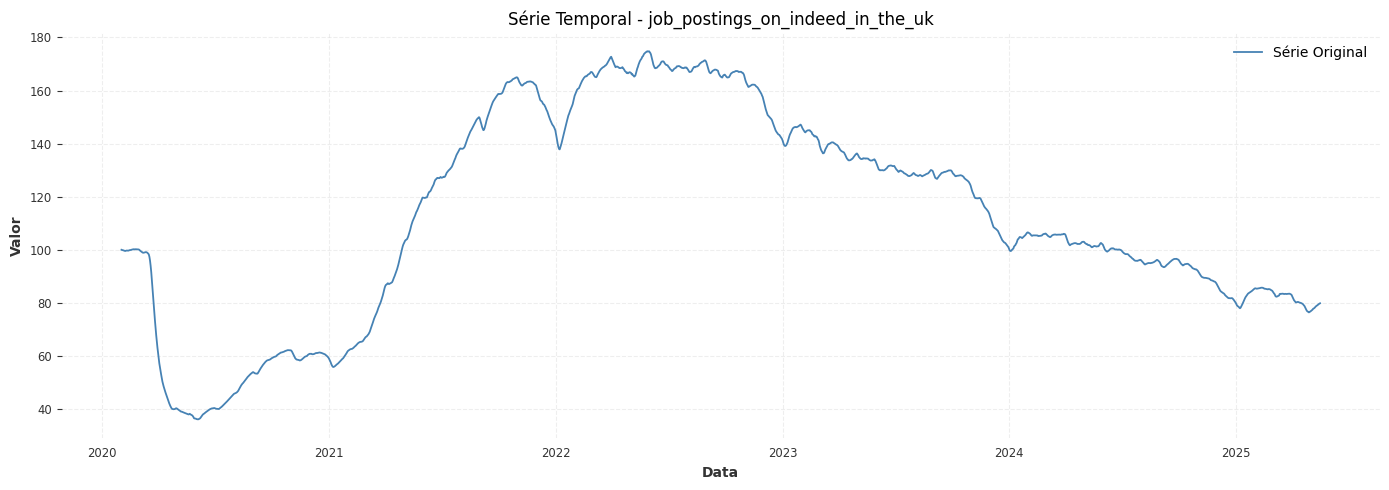

Epoch 1/100 | Train Loss: 0.060880 | Val Loss: 0.006878 | Val MAE: 0.082154 | Val SMAPE: 17.14% | Tempo: 0.38s
Epoch 2/100 | Train Loss: 0.020622 | Val Loss: 0.000259 | Val MAE: 0.014646 | Val SMAPE: 3.32% | Tempo: 0.21s
Epoch 3/100 | Train Loss: 0.015463 | Val Loss: 0.000676 | Val MAE: 0.021309 | Val SMAPE: 4.58% | Tempo: 0.21s
Epoch 4/100 | Train Loss: 0.012835 | Val Loss: 0.003857 | Val MAE: 0.060424 | Val SMAPE: 14.67% | Tempo: 0.22s
Epoch 5/100 | Train Loss: 0.009806 | Val Loss: 0.000427 | Val MAE: 0.017821 | Val SMAPE: 4.06% | Tempo: 0.25s
Epoch 6/100 | Train Loss: 0.008335 | Val Loss: 0.000220 | Val MAE: 0.013119 | Val SMAPE: 3.03% | Tempo: 0.22s
Epoch 7/100 | Train Loss: 0.007212 | Val Loss: 0.000092 | Val MAE: 0.007521 | Val SMAPE: 1.69% | Tempo: 0.21s
Epoch 8/100 | Train Loss: 0.007145 | Val Loss: 0.000061 | Val MAE: 0.006627 | Val SMAPE: 1.51% | Tempo: 0.22s
Epoch 9/100 | Train Loss: 0.006549 | Val Loss: 0.000068 | Val MAE: 0.006654 | Val SMAPE: 1.56% | Tempo: 0.23s
Epoch 10

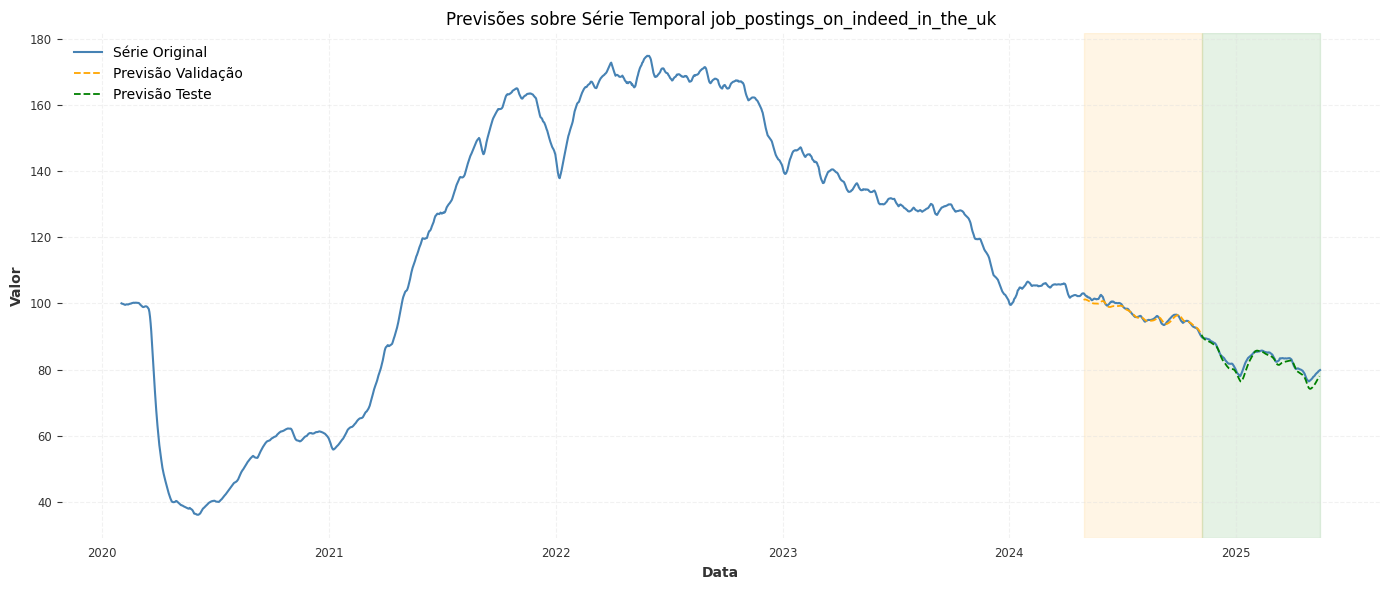

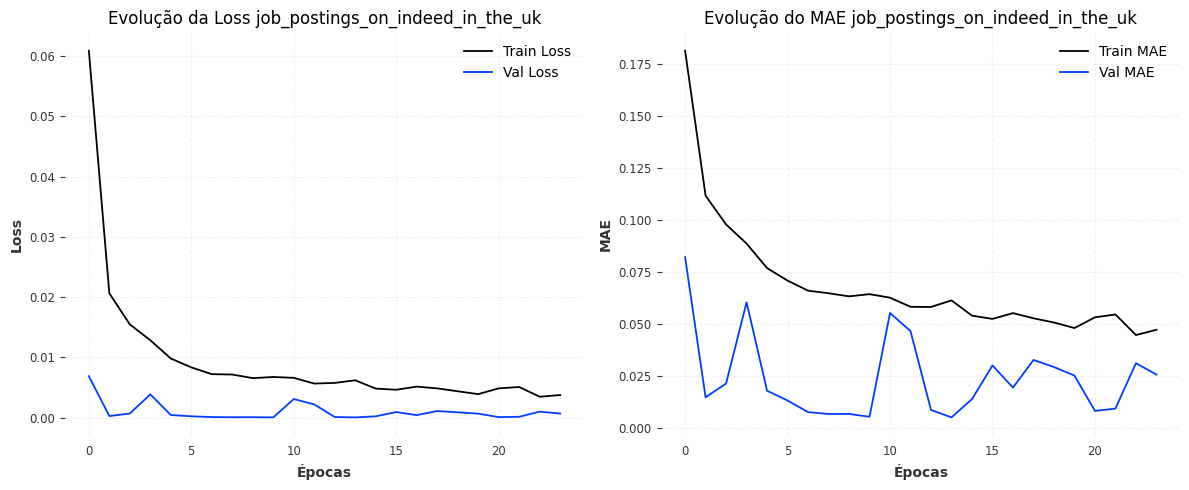

Modelo salvo em: modelos_pytorch/modelo_job_postings_on_indeed_in_the_uk.pth

🚀 Processando a série 2/6: interest_rates_lt_bond_yields_10_year_main_including_benchmark_for_uk

🔄 Treinando modelo PyTorch hibrido para: interest_rates_lt_bond_yields_10_year_main_including_benchmark_for_uk


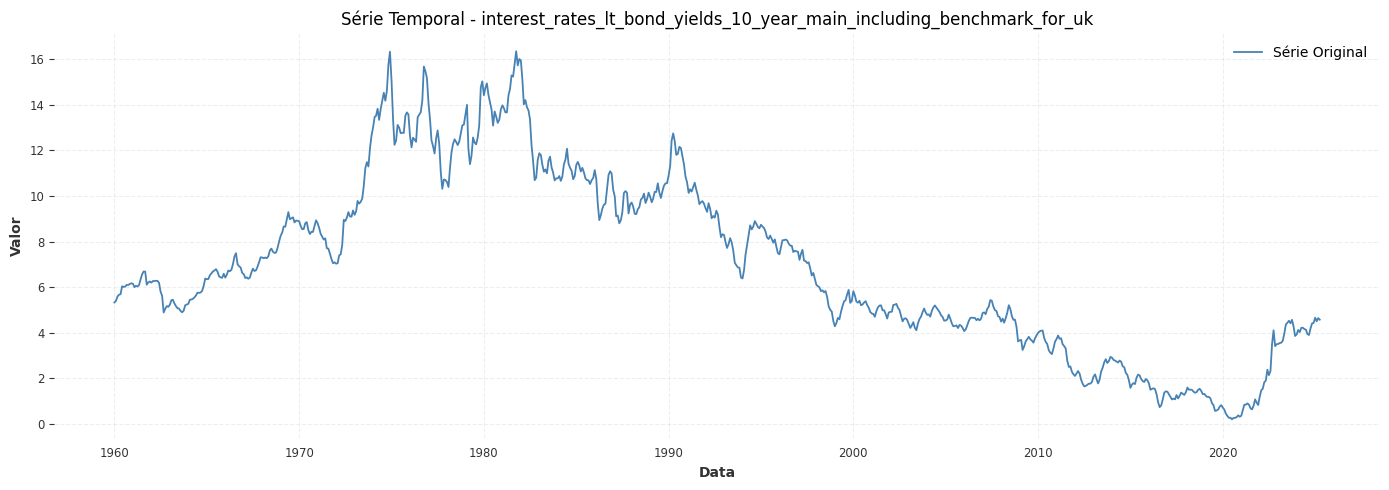

Epoch 1/100 | Train Loss: 0.085656 | Val Loss: 0.016085 | Val MAE: 0.119658 | Val SMAPE: 77.98% | Tempo: 0.10s
Epoch 2/100 | Train Loss: 0.021167 | Val Loss: 0.013587 | Val MAE: 0.113520 | Val SMAPE: 76.44% | Tempo: 0.08s
Epoch 3/100 | Train Loss: 0.017121 | Val Loss: 0.000938 | Val MAE: 0.024509 | Val SMAPE: 28.25% | Tempo: 0.09s
Epoch 4/100 | Train Loss: 0.016476 | Val Loss: 0.001823 | Val MAE: 0.034715 | Val SMAPE: 31.46% | Tempo: 0.09s
Epoch 5/100 | Train Loss: 0.012896 | Val Loss: 0.001359 | Val MAE: 0.028945 | Val SMAPE: 33.00% | Tempo: 0.08s
Epoch 6/100 | Train Loss: 0.011150 | Val Loss: 0.000964 | Val MAE: 0.022951 | Val SMAPE: 23.14% | Tempo: 0.08s
Epoch 7/100 | Train Loss: 0.009067 | Val Loss: 0.001117 | Val MAE: 0.026943 | Val SMAPE: 30.14% | Tempo: 0.08s
Epoch 8/100 | Train Loss: 0.010435 | Val Loss: 0.000694 | Val MAE: 0.021664 | Val SMAPE: 24.07% | Tempo: 0.08s
Epoch 9/100 | Train Loss: 0.008811 | Val Loss: 0.000654 | Val MAE: 0.020681 | Val SMAPE: 21.75% | Tempo: 0.08s
E

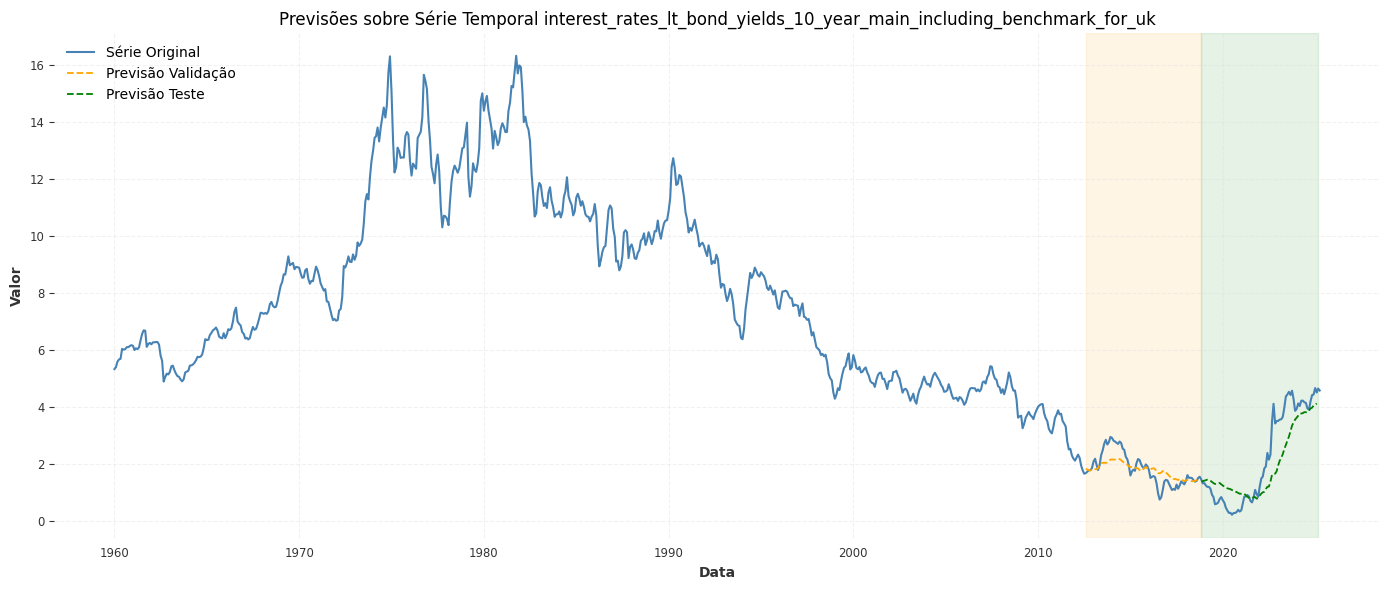

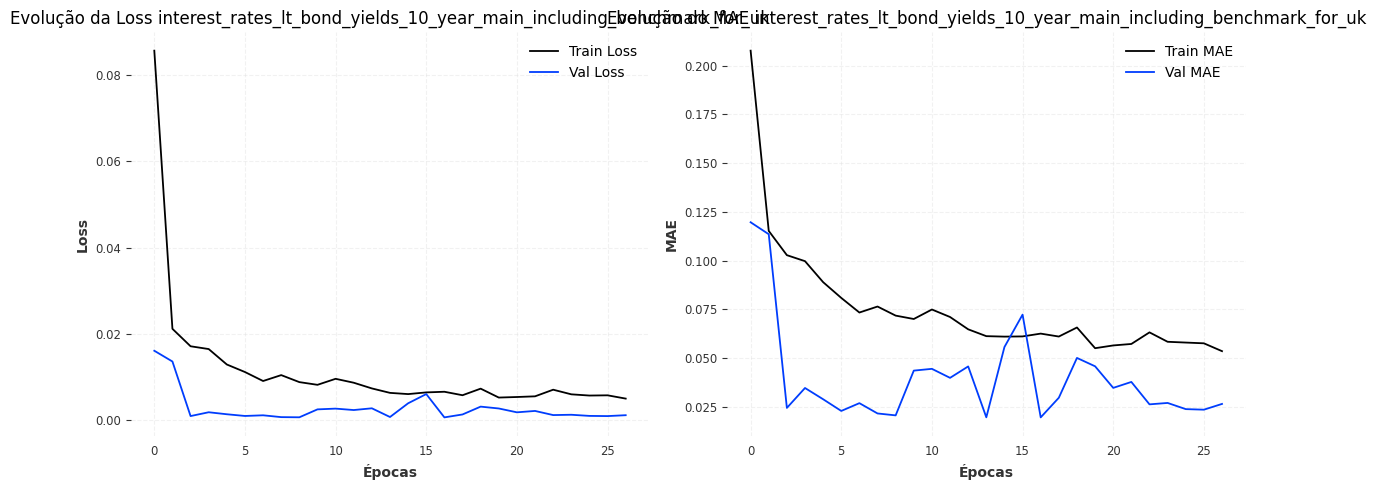

Modelo salvo em: modelos_pytorch/modelo_interest_rates_lt_bond_yields_10_year_main_includi.pth

🚀 Processando a série 3/6: house_prices_for_uk

🔄 Treinando modelo PyTorch hibrido para: house_prices_for_uk


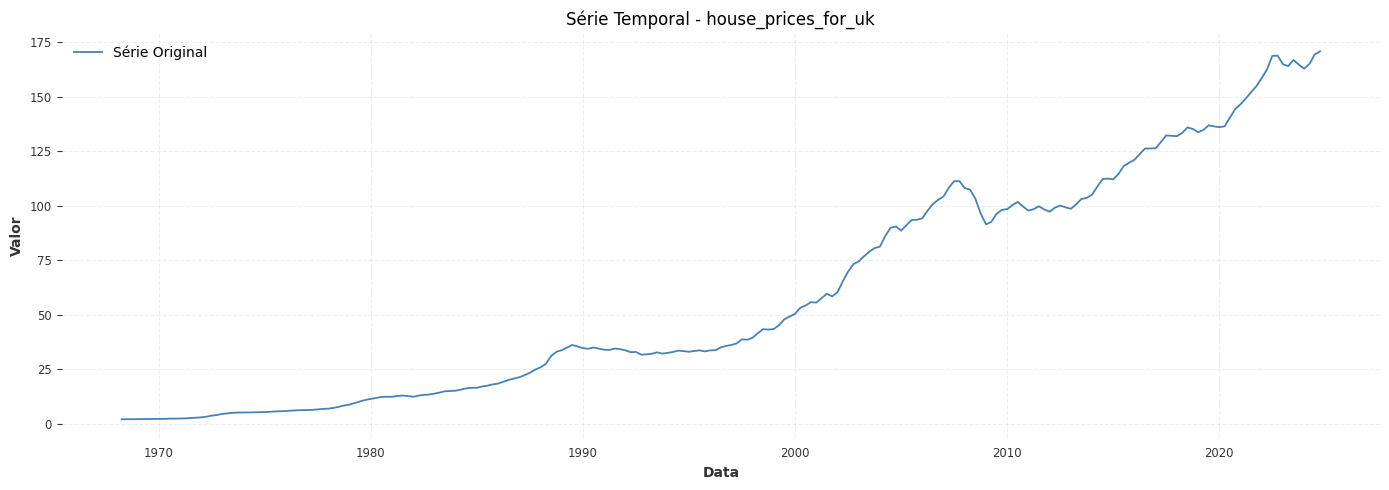

Epoch 1/100 | Train Loss: 0.060260 | Val Loss: 0.102569 | Val MAE: 0.319034 | Val SMAPE: 54.54% | Tempo: 0.04s
Epoch 2/100 | Train Loss: 0.025075 | Val Loss: 0.169482 | Val MAE: 0.410451 | Val SMAPE: 76.17% | Tempo: 0.02s
Epoch 3/100 | Train Loss: 0.016064 | Val Loss: 0.143656 | Val MAE: 0.376569 | Val SMAPE: 67.62% | Tempo: 0.03s
Epoch 4/100 | Train Loss: 0.011905 | Val Loss: 0.120070 | Val MAE: 0.344658 | Val SMAPE: 60.18% | Tempo: 0.02s
Epoch 5/100 | Train Loss: 0.018613 | Val Loss: 0.074272 | Val MAE: 0.270494 | Val SMAPE: 44.31% | Tempo: 0.03s
Epoch 6/100 | Train Loss: 0.008337 | Val Loss: 0.066052 | Val MAE: 0.255007 | Val SMAPE: 41.25% | Tempo: 0.03s
Epoch 7/100 | Train Loss: 0.009769 | Val Loss: 0.044165 | Val MAE: 0.208207 | Val SMAPE: 32.43% | Tempo: 0.03s
Epoch 8/100 | Train Loss: 0.009622 | Val Loss: 0.027070 | Val MAE: 0.162179 | Val SMAPE: 24.35% | Tempo: 0.03s
Epoch 9/100 | Train Loss: 0.006209 | Val Loss: 0.045051 | Val MAE: 0.211459 | Val SMAPE: 33.11% | Tempo: 0.03s
E

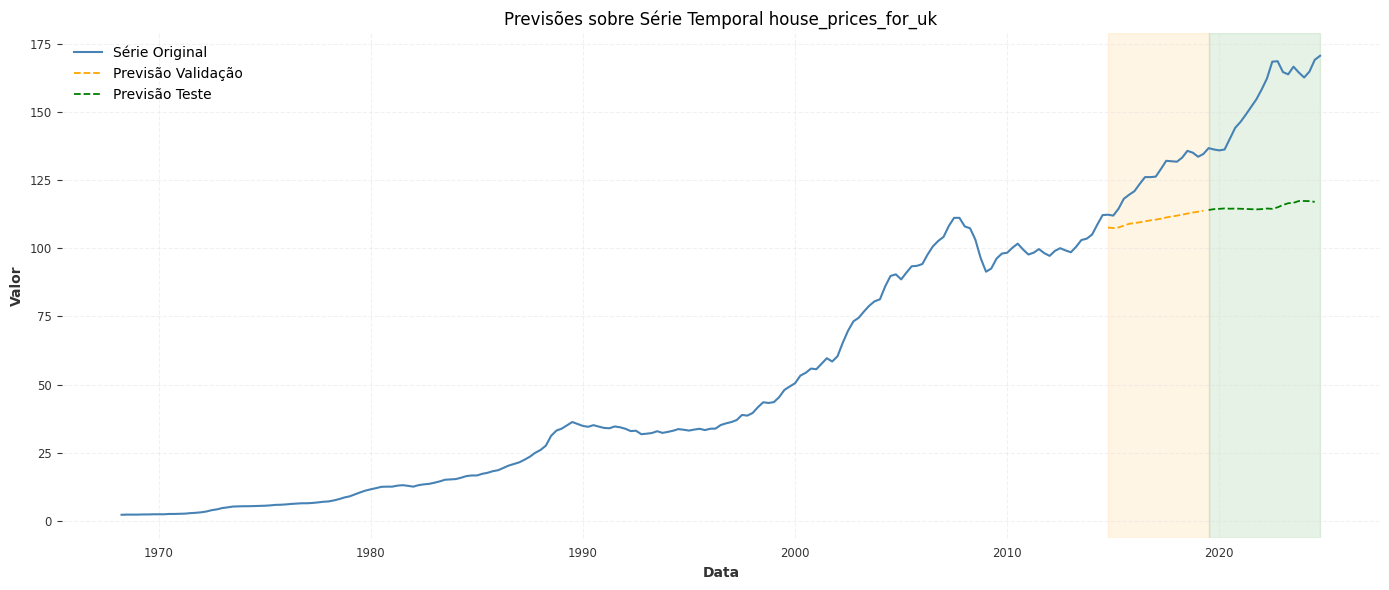

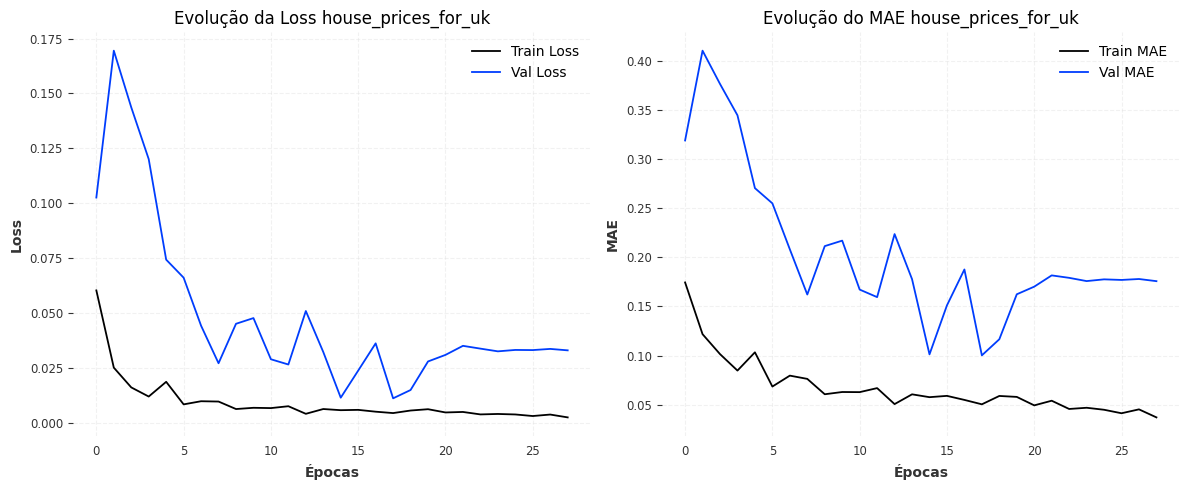

Modelo salvo em: modelos_pytorch/modelo_house_prices_for_uk.pth

🚀 Processando a série 4/6: gdp_for_uk

🔄 Treinando modelo PyTorch hibrido para: gdp_for_uk


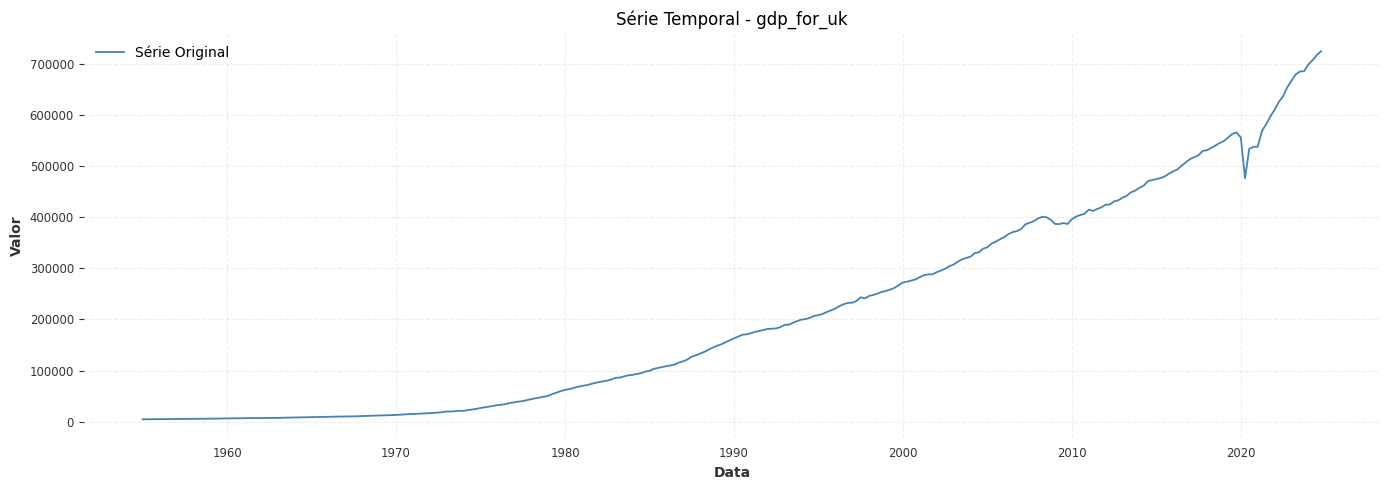

Epoch 1/100 | Train Loss: 0.064367 | Val Loss: 0.058376 | Val MAE: 0.238302 | Val SMAPE: 43.33% | Tempo: 0.05s
Epoch 2/100 | Train Loss: 0.020608 | Val Loss: 0.068645 | Val MAE: 0.260803 | Val SMAPE: 48.59% | Tempo: 0.04s
Epoch 3/100 | Train Loss: 0.016526 | Val Loss: 0.024193 | Val MAE: 0.154765 | Val SMAPE: 26.24% | Tempo: 0.04s
Epoch 4/100 | Train Loss: 0.012122 | Val Loss: 0.050061 | Val MAE: 0.223240 | Val SMAPE: 40.28% | Tempo: 0.05s
Epoch 5/100 | Train Loss: 0.010512 | Val Loss: 0.012886 | Val MAE: 0.110885 | Val SMAPE: 18.00% | Tempo: 0.04s
Epoch 6/100 | Train Loss: 0.009438 | Val Loss: 0.013594 | Val MAE: 0.111129 | Val SMAPE: 17.98% | Tempo: 0.04s
Epoch 7/100 | Train Loss: 0.007864 | Val Loss: 0.004659 | Val MAE: 0.056924 | Val SMAPE: 8.69% | Tempo: 0.04s
Epoch 8/100 | Train Loss: 0.007111 | Val Loss: 0.005860 | Val MAE: 0.065908 | Val SMAPE: 10.17% | Tempo: 0.04s
Epoch 9/100 | Train Loss: 0.005876 | Val Loss: 0.006793 | Val MAE: 0.073265 | Val SMAPE: 11.40% | Tempo: 0.04s
Ep

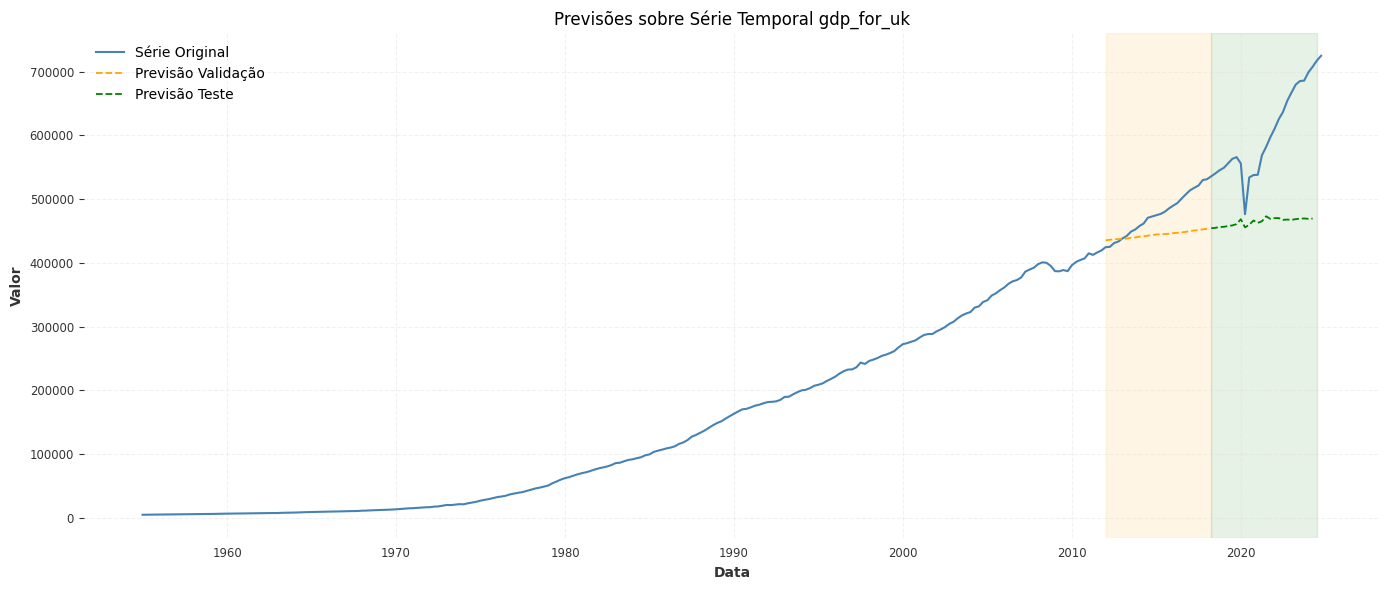

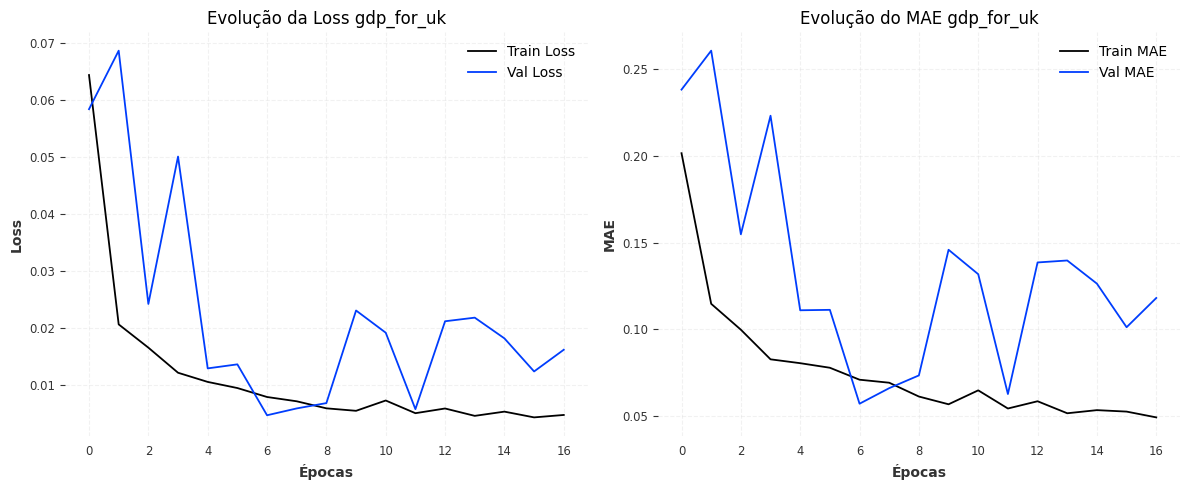

Modelo salvo em: modelos_pytorch/modelo_gdp_for_uk.pth

🚀 Processando a série 5/6: consumer_price_indices_cpis_hicps_coicop_1999_cpi_total_for_uk

🔄 Treinando modelo PyTorch hibrido para: consumer_price_indices_cpis_hicps_coicop_1999_cpi_total_for_uk


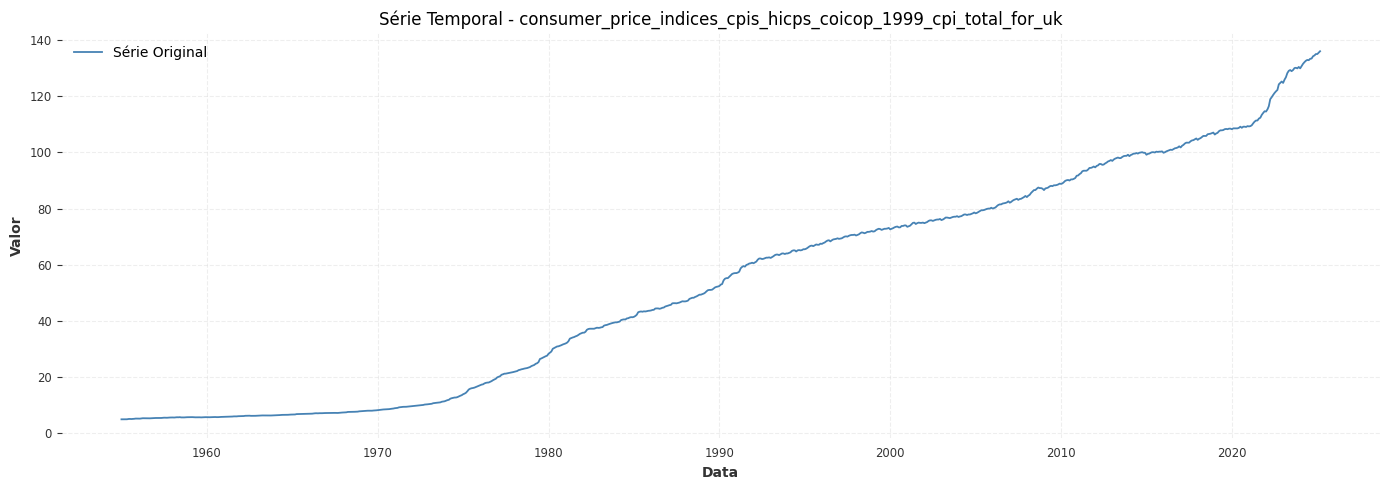

Epoch 1/100 | Train Loss: 0.033015 | Val Loss: 0.106596 | Val MAE: 0.326049 | Val SMAPE: 58.13% | Tempo: 0.11s
Epoch 2/100 | Train Loss: 0.016777 | Val Loss: 0.054089 | Val MAE: 0.232303 | Val SMAPE: 38.23% | Tempo: 0.10s
Epoch 3/100 | Train Loss: 0.009328 | Val Loss: 0.014622 | Val MAE: 0.120124 | Val SMAPE: 18.07% | Tempo: 0.10s
Epoch 4/100 | Train Loss: 0.008690 | Val Loss: 0.008445 | Val MAE: 0.090706 | Val SMAPE: 13.33% | Tempo: 0.11s
Epoch 5/100 | Train Loss: 0.007312 | Val Loss: 0.011784 | Val MAE: 0.107606 | Val SMAPE: 16.03% | Tempo: 0.10s
Epoch 6/100 | Train Loss: 0.006229 | Val Loss: 0.004914 | Val MAE: 0.068990 | Val SMAPE: 9.98% | Tempo: 0.09s
Epoch 7/100 | Train Loss: 0.005693 | Val Loss: 0.002865 | Val MAE: 0.049979 | Val SMAPE: 7.11% | Tempo: 0.10s
Epoch 8/100 | Train Loss: 0.005570 | Val Loss: 0.000744 | Val MAE: 0.021864 | Val SMAPE: 3.03% | Tempo: 0.10s
Epoch 9/100 | Train Loss: 0.004477 | Val Loss: 0.006007 | Val MAE: 0.076341 | Val SMAPE: 11.10% | Tempo: 0.09s
Epoc

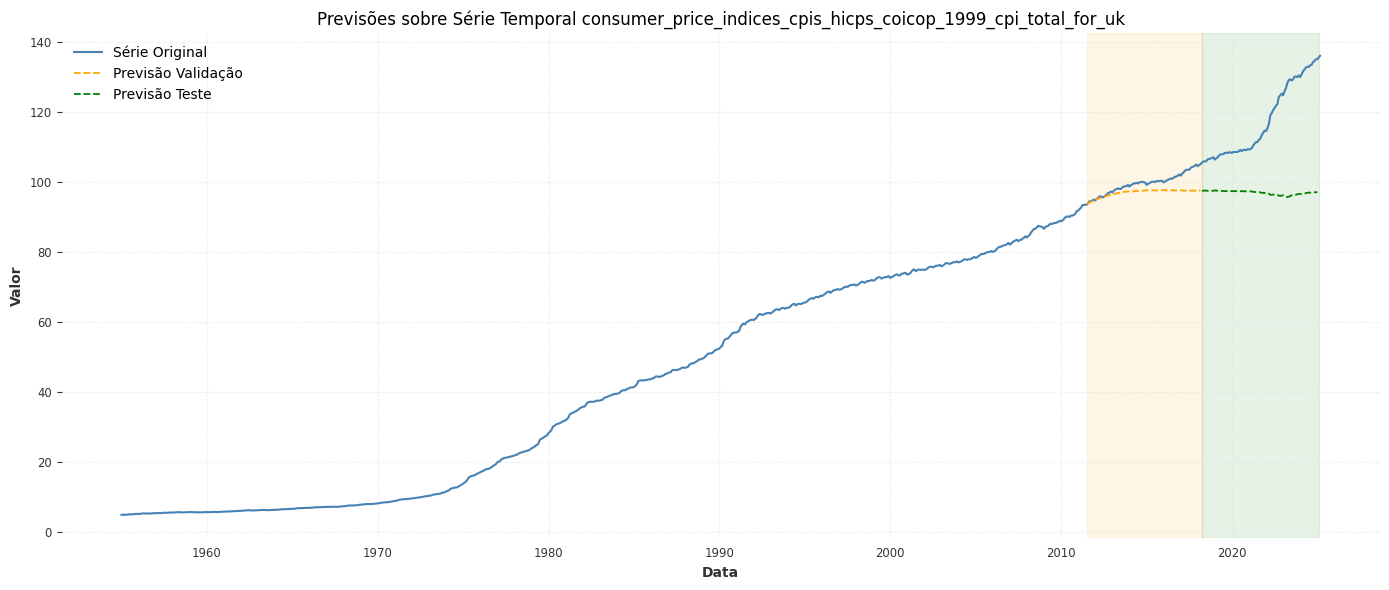

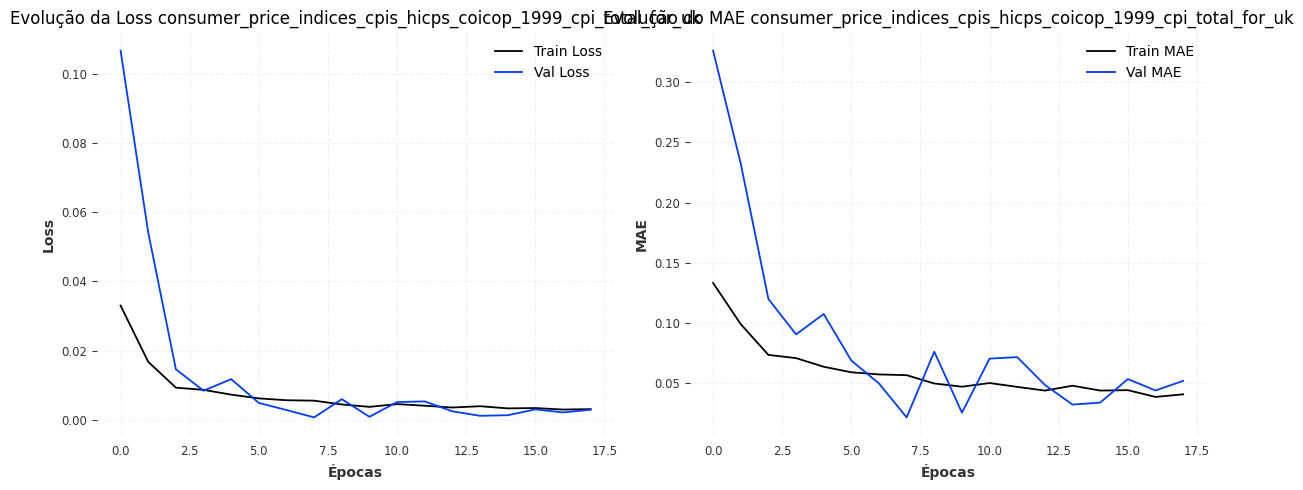

Modelo salvo em: modelos_pytorch/modelo_consumer_price_indices_cpis_hicps_coicop_1999_cpi_.pth

🚀 Processando a série 6/6: uk_daily_policy_data

🔄 Treinando modelo PyTorch hibrido para: uk_daily_policy_data


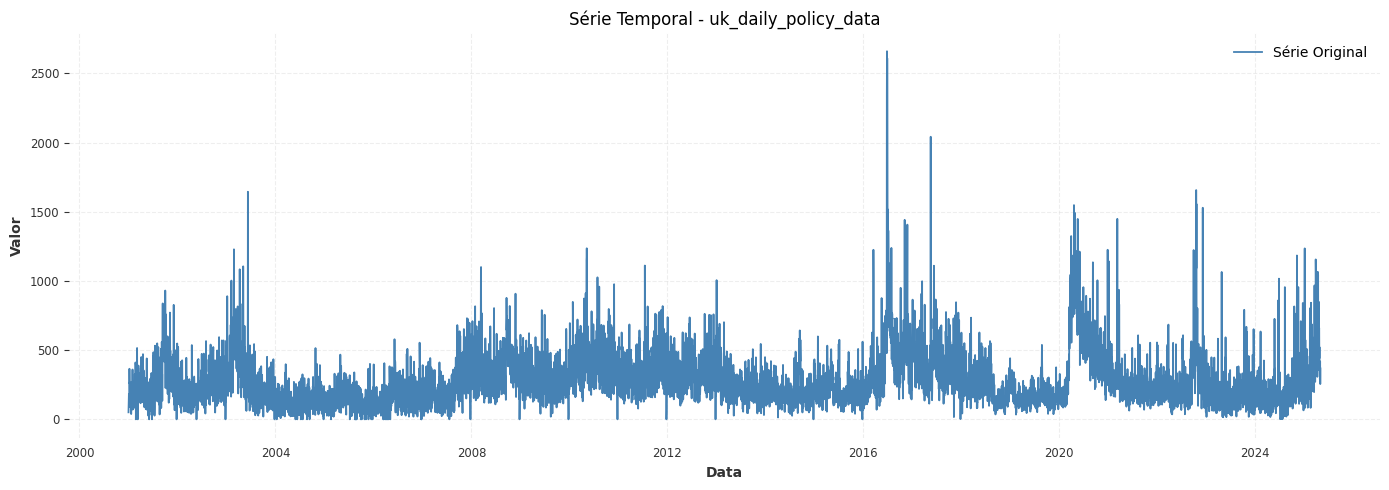

Epoch 1/100 | Train Loss: 0.006865 | Val Loss: 0.003193 | Val MAE: 0.035764 | Val SMAPE: 31.75% | Tempo: 1.08s
Epoch 2/100 | Train Loss: 0.003166 | Val Loss: 0.003124 | Val MAE: 0.036623 | Val SMAPE: 32.50% | Tempo: 1.10s
Epoch 3/100 | Train Loss: 0.003004 | Val Loss: 0.002992 | Val MAE: 0.034607 | Val SMAPE: 30.60% | Tempo: 1.05s
Epoch 4/100 | Train Loss: 0.002834 | Val Loss: 0.002976 | Val MAE: 0.034577 | Val SMAPE: 30.34% | Tempo: 1.11s
Epoch 5/100 | Train Loss: 0.002833 | Val Loss: 0.003272 | Val MAE: 0.036454 | Val SMAPE: 31.05% | Tempo: 1.09s
Epoch 6/100 | Train Loss: 0.002723 | Val Loss: 0.002964 | Val MAE: 0.035617 | Val SMAPE: 31.17% | Tempo: 1.18s
Epoch 7/100 | Train Loss: 0.002680 | Val Loss: 0.003289 | Val MAE: 0.036008 | Val SMAPE: 31.44% | Tempo: 1.04s
Epoch 8/100 | Train Loss: 0.002749 | Val Loss: 0.003063 | Val MAE: 0.037521 | Val SMAPE: 32.21% | Tempo: 1.07s
Epoch 9/100 | Train Loss: 0.002635 | Val Loss: 0.003194 | Val MAE: 0.035231 | Val SMAPE: 30.97% | Tempo: 1.05s
E

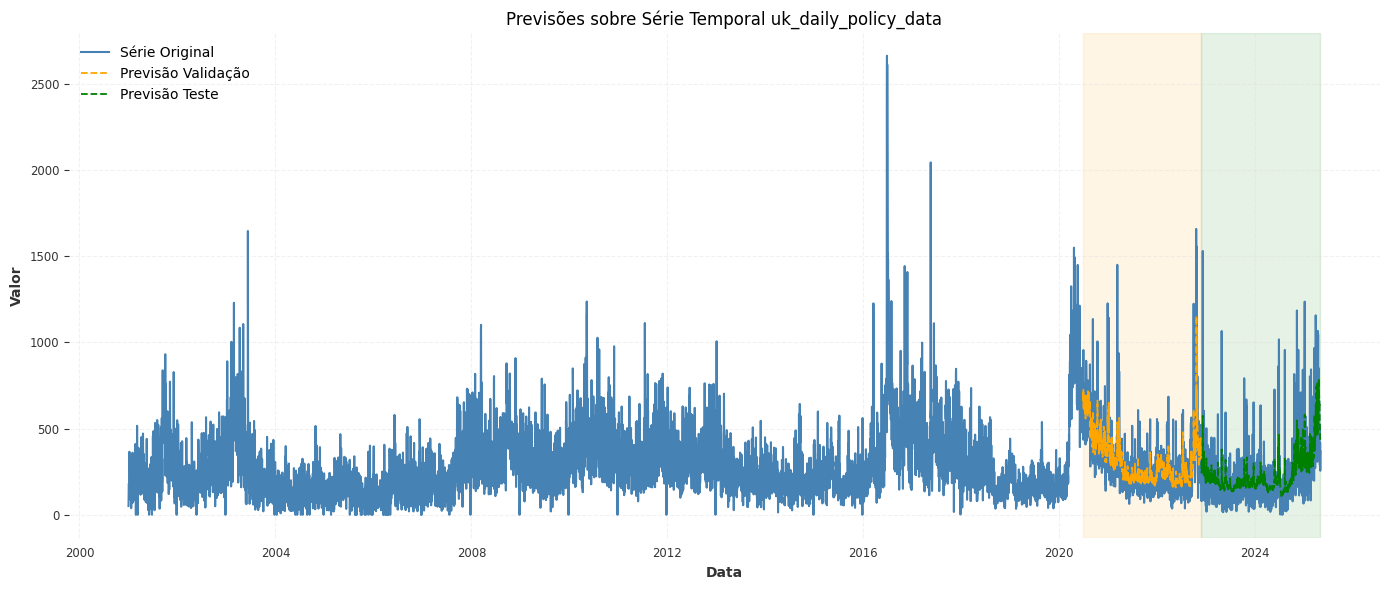

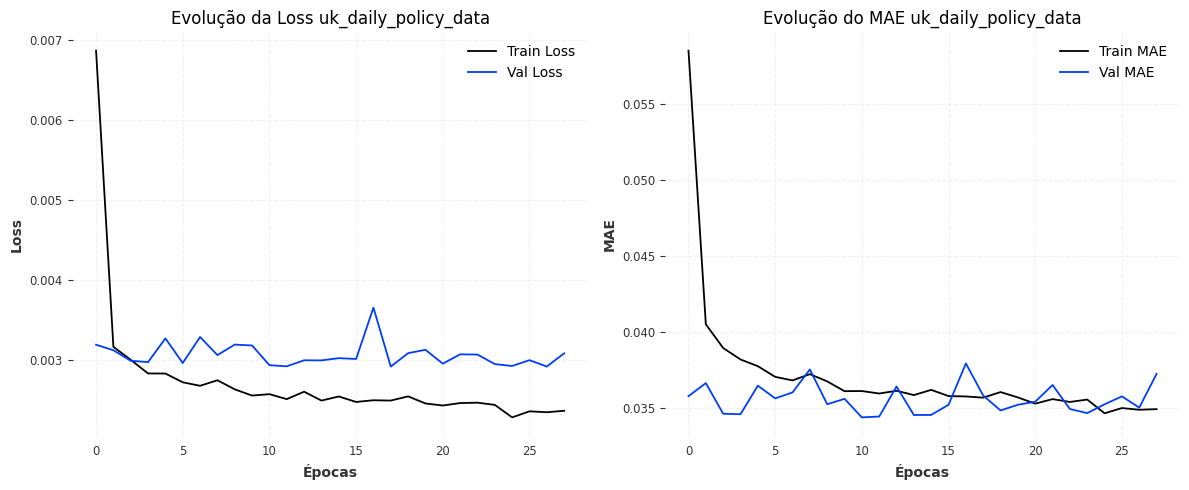

Modelo salvo em: modelos_pytorch/modelo_uk_daily_policy_data.pth


In [111]:
for idx, serie in enumerate(fred_series_list, 1):
    try:
        print(f"\n{'='*50}")
        print(f"🚀 Processando a série {idx}/{len(fred_series_list)}: {serie.name}")
        
        # Rodar com parâmetros padrão
        model, history = treinar_para_serie_pytorch(serie, seq_length=30, usar_hibrido=True, serie_name = serie.name)
        
        # Salvar o modelo com nome descritivo
        nome_arquivo = f"modelos_pytorch/modelo_{serie.name.replace(' ', '_').replace('/', '_')[:50]}.pth"
        torch.save(model.state_dict(), nome_arquivo)
        print(f"Modelo salvo em: {nome_arquivo}")
        
    except ValueError as ve:
        print(f"❌ Série {serie.name} ignorada - {str(ve)}")
    except Exception as e:
        print(f"❌ Erro inesperado na série {serie.name}: {str(e)}")
        continue

#### 2.2.2. Janela Deslizante (Sliding/Rolling Window)

In [112]:
batch_size=32
patience_es=10
factor=0.5
patience_lr=5
min_lr=1e-6

Epoch 1/50 | Train Loss: 0.182202 | Val Loss: 0.000458 | Val MAE: 0.020000 | Val SMAPE: 18.24% | Tempo: 0.05s
Epoch 2/50 | Train Loss: 0.184867 | Val Loss: 0.014258 | Val MAE: 0.119131 | Val SMAPE: 74.24% | Tempo: 0.02s
Epoch 3/50 | Train Loss: 0.182370 | Val Loss: 0.034940 | Val MAE: 0.186737 | Val SMAPE: 96.07% | Tempo: 0.02s
Epoch 4/50 | Train Loss: 0.175063 | Val Loss: 0.025585 | Val MAE: 0.159739 | Val SMAPE: 88.33% | Tempo: 0.02s
Epoch 5/50 | Train Loss: 0.173180 | Val Loss: 0.020377 | Val MAE: 0.142536 | Val SMAPE: 82.77% | Tempo: 0.02s
Epoch 6/50 | Train Loss: 0.171845 | Val Loss: 0.054156 | Val MAE: 0.232578 | Val SMAPE: 107.02% | Tempo: 0.02s
Epoch 7/50 | Train Loss: 0.171344 | Val Loss: 0.059019 | Val MAE: 0.242791 | Val SMAPE: 109.15% | Tempo: 0.03s
Epoch 8/50 | Train Loss: 0.170532 | Val Loss: 0.049267 | Val MAE: 0.221803 | Val SMAPE: 104.66% | Tempo: 0.02s
Epoch 9/50 | Train Loss: 0.169630 | Val Loss: 0.037787 | Val MAE: 0.194217 | Val SMAPE: 98.03% | Tempo: 0.02s


Epoch 10/50 | Train Loss: 0.167175 | Val Loss: 0.033102 | Val MAE: 0.181759 | Val SMAPE: 94.73% | Tempo: 0.02s
Epoch 11/50 | Train Loss: 0.168444 | Val Loss: 0.033394 | Val MAE: 0.182566 | Val SMAPE: 94.95% | Tempo: 0.02s
⏸️ Paragem antecipada na época 11
🕒 Treino finalizado. Tempo total: 0.29s
Epoch 1/50 | Train Loss: 0.270488 | Val Loss: 0.119852 | Val MAE: 0.341357 | Val SMAPE: 46.78% | Tempo: 0.03s
Epoch 2/50 | Train Loss: 0.104194 | Val Loss: 0.011555 | Val MAE: 0.091887 | Val SMAPE: 10.60% | Tempo: 0.03s
Epoch 3/50 | Train Loss: 0.077961 | Val Loss: 0.063971 | Val MAE: 0.246791 | Val SMAPE: 31.67% | Tempo: 0.02s
Epoch 4/50 | Train Loss: 0.070227 | Val Loss: 0.078065 | Val MAE: 0.273954 | Val SMAPE: 35.81% | Tempo: 0.02s
Epoch 5/50 | Train Loss: 0.066322 | Val Loss: 0.042847 | Val MAE: 0.199407 | Val SMAPE: 24.79% | Tempo: 0.02s
Epoch 6/50 | Train Loss: 0.059647 | Val Loss: 0.028011 | Val MAE: 0.157563 | Val SMAPE: 19.06% | Tempo: 0.02s
Epoch 7/50 | Train Loss: 0.059521 | Val Loss

Epoch 1/50 | Train Loss: 0.206184 | Val Loss: 0.077384 | Val MAE: 0.277549 | Val SMAPE: 29.73% | Tempo: 0.03s
Epoch 2/50 | Train Loss: 0.119535 | Val Loss: 0.289067 | Val MAE: 0.537318 | Val SMAPE: 66.87% | Tempo: 0.02s
Epoch 3/50 | Train Loss: 0.115072 | Val Loss: 0.268610 | Val MAE: 0.517937 | Val SMAPE: 63.69% | Tempo: 0.02s
Epoch 4/50 | Train Loss: 0.101263 | Val Loss: 0.216935 | Val MAE: 0.465387 | Val SMAPE: 55.44% | Tempo: 0.02s
Epoch 5/50 | Train Loss: 0.098281 | Val Loss: 0.262928 | Val MAE: 0.512421 | Val SMAPE: 62.80% | Tempo: 0.02s
Epoch 6/50 | Train Loss: 0.098011 | Val Loss: 0.311552 | Val MAE: 0.557853 | Val SMAPE: 70.33% | Tempo: 0.02s
Epoch 7/50 | Train Loss: 0.099174 | Val Loss: 0.257411 | Val MAE: 0.507007 | Val SMAPE: 61.93% | Tempo: 0.02s
Epoch 8/50 | Train Loss: 0.096451 | Val Loss: 0.207421 | Val MAE: 0.455044 | Val SMAPE: 53.87% | Tempo: 0.02s
Epoch 9/50 | Train Loss: 0.097364 | Val Loss: 0.255300 | Val MAE: 0.504918 | Val SMAPE: 61.60% | Tempo: 0.02s
Epoch 10/5

Epoch 1/50 | Train Loss: 0.306017 | Val Loss: 0.296924 | Val MAE: 0.544762 | Val SMAPE: 73.63% | Tempo: 0.03s
Epoch 2/50 | Train Loss: 0.118517 | Val Loss: 0.111658 | Val MAE: 0.333914 | Val SMAPE: 39.50% | Tempo: 0.02s
Epoch 3/50 | Train Loss: 0.111549 | Val Loss: 0.291352 | Val MAE: 0.539493 | Val SMAPE: 72.68% | Tempo: 0.02s
Epoch 4/50 | Train Loss: 0.100674 | Val Loss: 0.326531 | Val MAE: 0.571133 | Val SMAPE: 78.62% | Tempo: 0.02s
Epoch 5/50 | Train Loss: 0.102045 | Val Loss: 0.166621 | Val MAE: 0.407996 | Val SMAPE: 50.48% | Tempo: 0.02s
Epoch 6/50 | Train Loss: 0.097996 | Val Loss: 0.112833 | Val MAE: 0.335469 | Val SMAPE: 39.73% | Tempo: 0.02s
Epoch 7/50 | Train Loss: 0.091517 | Val Loss: 0.098178 | Val MAE: 0.312917 | Val SMAPE: 36.57% | Tempo: 0.03s
Epoch 8/50 | Train Loss: 0.091653 | Val Loss: 0.107507 | Val MAE: 0.327548 | Val SMAPE: 38.61% | Tempo: 0.02s
Epoch 9/50 | Train Loss: 0.091602 | Val Loss: 0.155537 | Val MAE: 0.394179 | Val SMAPE: 48.35% | Tempo: 0.02s
Epoch 10/5

Epoch 1/50 | Train Loss: 0.127056 | Val Loss: 0.060193 | Val MAE: 0.233222 | Val SMAPE: 49.63% | Tempo: 0.02s
Epoch 2/50 | Train Loss: 0.083617 | Val Loss: 0.097825 | Val MAE: 0.303368 | Val SMAPE: 70.31% | Tempo: 0.02s
Epoch 3/50 | Train Loss: 0.082993 | Val Loss: 0.110620 | Val MAE: 0.323903 | Val SMAPE: 77.00% | Tempo: 0.02s
Epoch 4/50 | Train Loss: 0.074366 | Val Loss: 0.046732 | Val MAE: 0.202377 | Val SMAPE: 41.50% | Tempo: 0.02s
Epoch 5/50 | Train Loss: 0.075205 | Val Loss: 0.025644 | Val MAE: 0.144485 | Val SMAPE: 27.64% | Tempo: 0.02s
Epoch 6/50 | Train Loss: 0.072927 | Val Loss: 0.056812 | Val MAE: 0.225525 | Val SMAPE: 47.59% | Tempo: 0.02s
Epoch 7/50 | Train Loss: 0.068074 | Val Loss: 0.050930 | Val MAE: 0.211432 | Val SMAPE: 43.95% | Tempo: 0.02s
Epoch 8/50 | Train Loss: 0.066327 | Val Loss: 0.032613 | Val MAE: 0.163994 | Val SMAPE: 32.16% | Tempo: 0.02s
Epoch 9/50 | Train Loss: 0.065857 | Val Loss: 0.029113 | Val MAE: 0.153774 | Val SMAPE: 29.74% | Tempo: 0.02s
Epoch 10/5

Epoch 15/50 | Train Loss: 0.063959 | Val Loss: 0.028267 | Val MAE: 0.151066 | Val SMAPE: 29.10% | Tempo: 0.02s
⏸️ Paragem antecipada na época 15
🕒 Treino finalizado. Tempo total: 0.35s
Epoch 1/50 | Train Loss: 0.194585 | Val Loss: 0.131658 | Val MAE: 0.361107 | Val SMAPE: 199.30% | Tempo: 0.02s
Epoch 2/50 | Train Loss: 0.140529 | Val Loss: 0.189901 | Val MAE: 0.434176 | Val SMAPE: 199.43% | Tempo: 0.04s
Epoch 3/50 | Train Loss: 0.138917 | Val Loss: 0.309996 | Val MAE: 0.555598 | Val SMAPE: 199.56% | Tempo: 0.03s
Epoch 4/50 | Train Loss: 0.129885 | Val Loss: 0.235697 | Val MAE: 0.484168 | Val SMAPE: 199.49% | Tempo: 0.02s
Epoch 5/50 | Train Loss: 0.126354 | Val Loss: 0.191573 | Val MAE: 0.436246 | Val SMAPE: 199.43% | Tempo: 0.02s
Epoch 6/50 | Train Loss: 0.124638 | Val Loss: 0.272344 | Val MAE: 0.520652 | Val SMAPE: 199.53% | Tempo: 0.02s
Epoch 7/50 | Train Loss: 0.121767 | Val Loss: 0.259508 | Val MAE: 0.508180 | Val SMAPE: 199.52% | Tempo: 0.02s
Epoch 8/50 | Train Loss: 0.123419 | Va

Epoch 1/50 | Train Loss: 0.102658 | Val Loss: 0.001258 | Val MAE: 0.032222 | Val SMAPE: 16.14% | Tempo: 0.02s
Epoch 2/50 | Train Loss: 0.082945 | Val Loss: 0.001553 | Val MAE: 0.036402 | Val SMAPE: 15.78% | Tempo: 0.03s
Epoch 3/50 | Train Loss: 0.076494 | Val Loss: 0.008913 | Val MAE: 0.093201 | Val SMAPE: 35.84% | Tempo: 0.02s
Epoch 4/50 | Train Loss: 0.077353 | Val Loss: 0.004661 | Val MAE: 0.061464 | Val SMAPE: 24.74% | Tempo: 0.02s
Epoch 5/50 | Train Loss: 0.074331 | Val Loss: 0.019119 | Val MAE: 0.134148 | Val SMAPE: 47.35% | Tempo: 0.03s
Epoch 6/50 | Train Loss: 0.071725 | Val Loss: 0.010165 | Val MAE: 0.097763 | Val SMAPE: 37.04% | Tempo: 0.02s
Epoch 7/50 | Train Loss: 0.068450 | Val Loss: 0.004043 | Val MAE: 0.061457 | Val SMAPE: 25.17% | Tempo: 0.02s
Epoch 8/50 | Train Loss: 0.069006 | Val Loss: 0.018579 | Val MAE: 0.135103 | Val SMAPE: 48.00% | Tempo: 0.02s


Epoch 9/50 | Train Loss: 0.070948 | Val Loss: 0.019312 | Val MAE: 0.137736 | Val SMAPE: 48.70% | Tempo: 0.02s
Epoch 10/50 | Train Loss: 0.067760 | Val Loss: 0.012680 | Val MAE: 0.111113 | Val SMAPE: 41.23% | Tempo: 0.03s
Epoch 11/50 | Train Loss: 0.068512 | Val Loss: 0.012859 | Val MAE: 0.112075 | Val SMAPE: 41.54% | Tempo: 0.03s
⏸️ Paragem antecipada na época 11
🕒 Treino finalizado. Tempo total: 0.27s
Epoch 1/50 | Train Loss: 0.080077 | Val Loss: 0.001650 | Val MAE: 0.037206 | Val SMAPE: 19.07% | Tempo: 0.03s
Epoch 2/50 | Train Loss: 0.069829 | Val Loss: 0.001267 | Val MAE: 0.032605 | Val SMAPE: 16.51% | Tempo: 0.02s
Epoch 3/50 | Train Loss: 0.070108 | Val Loss: 0.001926 | Val MAE: 0.036935 | Val SMAPE: 16.99% | Tempo: 0.03s
Epoch 4/50 | Train Loss: 0.065024 | Val Loss: 0.006135 | Val MAE: 0.074687 | Val SMAPE: 31.11% | Tempo: 0.02s
Epoch 5/50 | Train Loss: 0.064364 | Val Loss: 0.003817 | Val MAE: 0.057094 | Val SMAPE: 24.81% | Tempo: 0.02s
Epoch 6/50 | Train Loss: 0.061759 | Val Loss

Epoch 1/50 | Train Loss: 0.175685 | Val Loss: 0.009001 | Val MAE: 0.091213 | Val SMAPE: 61.74% | Tempo: 0.03s
Epoch 2/50 | Train Loss: 0.105018 | Val Loss: 0.039293 | Val MAE: 0.195661 | Val SMAPE: 96.91% | Tempo: 0.02s
Epoch 3/50 | Train Loss: 0.097447 | Val Loss: 0.043490 | Val MAE: 0.206793 | Val SMAPE: 99.81% | Tempo: 0.03s
Epoch 4/50 | Train Loss: 0.095313 | Val Loss: 0.055528 | Val MAE: 0.233941 | Val SMAPE: 105.86% | Tempo: 0.02s
Epoch 5/50 | Train Loss: 0.095393 | Val Loss: 0.092145 | Val MAE: 0.302638 | Val SMAPE: 118.48% | Tempo: 0.02s
Epoch 6/50 | Train Loss: 0.097076 | Val Loss: 0.097603 | Val MAE: 0.311494 | Val SMAPE: 119.85% | Tempo: 0.02s
Epoch 7/50 | Train Loss: 0.091365 | Val Loss: 0.093374 | Val MAE: 0.304555 | Val SMAPE: 118.76% | Tempo: 0.02s
Epoch 8/50 | Train Loss: 0.090587 | Val Loss: 0.092038 | Val MAE: 0.302308 | Val SMAPE: 118.40% | Tempo: 0.02s


Epoch 9/50 | Train Loss: 0.089649 | Val Loss: 0.093317 | Val MAE: 0.304478 | Val SMAPE: 118.75% | Tempo: 0.02s
Epoch 10/50 | Train Loss: 0.089391 | Val Loss: 0.101713 | Val MAE: 0.317935 | Val SMAPE: 120.80% | Tempo: 0.03s
Epoch 11/50 | Train Loss: 0.087061 | Val Loss: 0.120945 | Val MAE: 0.346673 | Val SMAPE: 124.83% | Tempo: 0.02s
⏸️ Paragem antecipada na época 11
🕒 Treino finalizado. Tempo total: 0.27s
Epoch 1/50 | Train Loss: 0.261084 | Val Loss: 0.070325 | Val MAE: 0.257230 | Val SMAPE: 169.66% | Tempo: 0.03s
Epoch 2/50 | Train Loss: 0.066622 | Val Loss: 0.120829 | Val MAE: 0.341172 | Val SMAPE: 176.09% | Tempo: 0.02s
Epoch 3/50 | Train Loss: 0.057458 | Val Loss: 0.062376 | Val MAE: 0.241070 | Val SMAPE: 167.94% | Tempo: 0.02s
Epoch 4/50 | Train Loss: 0.058370 | Val Loss: 0.065370 | Val MAE: 0.247497 | Val SMAPE: 168.68% | Tempo: 0.02s
Epoch 5/50 | Train Loss: 0.051519 | Val Loss: 0.130185 | Val MAE: 0.354983 | Val SMAPE: 176.94% | Tempo: 0.02s
Epoch 6/50 | Train Loss: 0.049245 | 

Janela de previsão: 100%|██████████| 10/10 [00:03<00:00,  2.61it/s]

Epoch 13/50 | Train Loss: 0.049411 | Val Loss: 0.223062 | Val MAE: 0.467942 | Val SMAPE: 181.94% | Tempo: 0.02s
⏸️ Paragem antecipada na época 13
🕒 Treino finalizado. Tempo total: 0.31s


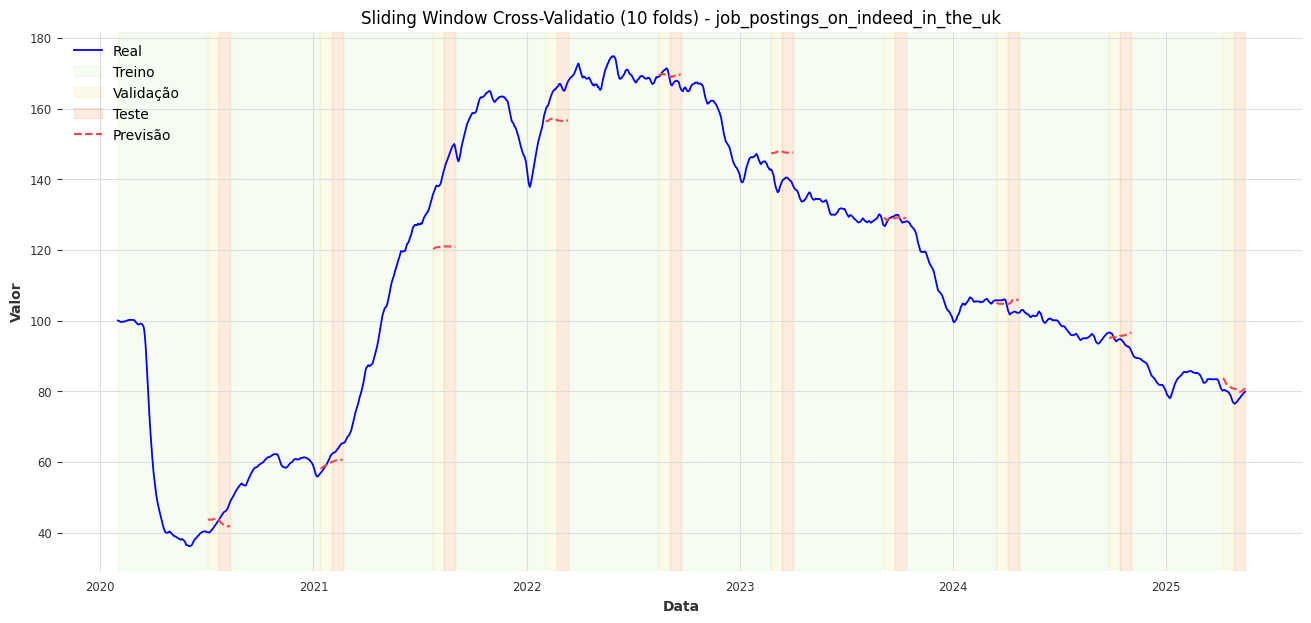

Métricas por janela:
 Janela Data Início   Data Fim       MAE     SMAPE
      1  2020-02-01 2020-08-11  3.002631  6.904078
      2  2020-08-12 2021-02-20  2.070003  3.362814
      3  2021-02-21 2021-09-01 22.059793 16.671261
      4  2021-09-02 2022-03-13  8.030552  4.987597
      5  2022-03-14 2022-09-22  1.464768  0.868134
      6  2022-09-23 2023-04-03  8.260085  5.763068
      7  2023-04-04 2023-10-13  0.774808  0.602765
      8  2023-10-14 2024-04-23  2.076770  1.992930
      9  2024-04-24 2024-11-02  1.882952  1.989424
     10  2024-11-03 2025-05-16  2.426836  3.045095

Tempo total de execução: 3.84 segundos


In [ ]:
import numpy as np
import torch
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
import pandas as pd

# Função SMAPE corrigida (já estava quase perfeita)
def smape(y_true, y_pred):
    numerator = np.abs(y_pred - y_true)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    # Evitar divisão por zero
    denominator = np.where(denominator == 0, 1, denominator)
    return np.mean(numerator / denominator) * 100

def prever_com_rolling_pytorch(serie, nome_serie_curto, seq_length=12, n_epochs=5, usar_hibrido=True, model_path="modelo_temporario.pth"):
    serie = serie.dropna()
    total_len = len(serie)
    n_splits = 10
    tam_janela = total_len // n_splits

    resultados = []

    cores = {'train': '#d0f0c0', 'val': '#f0e68c', 'test': '#f4a460'}

    plt.figure(figsize=(16, 7))
    plt.plot(serie, label='Real', color='blue')

    start_time = time.time()

    for i in tqdm(range(n_splits), desc="Janela de previsão"):
        inicio = i * tam_janela
        fim = inicio + tam_janela if i < n_splits - 1 else total_len

        dados = serie.iloc[inicio:fim]
        if len(dados) < seq_length + 3:
            continue

        n_train = int(0.8 * len(dados))
        n_val = int(0.10 * len(dados))
        n_test = len(dados) - n_train - n_val

        treino = dados.iloc[:n_train]
        val = dados.iloc[n_train:n_train + n_val]
        teste = dados.iloc[n_train + n_val:]

        # Demarcação das zonas no gráfico (só na primeira janela adiciona legendas)
        plt.axvspan(treino.index[0], treino.index[-1], color=cores['train'], alpha=0.2, label='Treino' if i == 0 else "")
        plt.axvspan(val.index[0], val.index[-1], color=cores['val'], alpha=0.2, label='Validação' if i == 0 else "")
        plt.axvspan(teste.index[0], teste.index[-1], color=cores['test'], alpha=0.2, label='Teste' if i == 0 else "")

        # Escalar só com treino
        scaler = MinMaxScaler()
        scaler.fit(treino.values.reshape(-1, 1))
        dados_scaled = scaler.transform(dados.values.reshape(-1, 1)).flatten()

        # Preparar dados de treino e validação (tensors PyTorch)
        def criar_dataset(dados_scaled, inicio, fim):
            X, y = [], []
            for j in range(inicio, fim):
                X.append(dados_scaled[j - seq_length:j])
                y.append(dados_scaled[j])
            X = np.array(X).reshape(-1, seq_length, 1)
            y = np.array(y).reshape(-1, 1)
            return torch.tensor(X, dtype=torch.float32).to(device), torch.tensor(y, dtype=torch.float32).to(device)

        X_train, y_train = criar_dataset(dados_scaled, seq_length, n_train)
        X_val, y_val = criar_dataset(dados_scaled, n_train + seq_length, n_train + n_val)

        # Criar modelo PyTorch
        model = TemporalCNN(seq_length, usar_hibrido=usar_hibrido).to(device)

        # Treinar modelo (presumindo que treinar_modelo retorna o que foi indicado)
        model, train_losses, val_losses, train_maes, val_maes, val_smapes, tempos_por_epoca, tempo_total_epoca = treinar_modelo(
            model, X_train, y_train, X_val, y_val,
            epochs=n_epochs,
            batch_size=batch_size,
            patience_es=patience_es,
            factor=factor,
            patience_lr=patience_lr,
            min_lr=min_lr,
            model_path=model_path
        )

        # Fazer previsões em validação + teste
        preds = []
        reais = []

        start_pred = n_train
        end_pred = len(dados)

        model.eval()
        with torch.no_grad():
            for j in range(start_pred, end_pred):
                seq = dados_scaled[j - seq_length:j]
                seq_tensor = torch.tensor(seq.reshape(1, seq_length, 1), dtype=torch.float32).to(device)
                pred_scaled = model(seq_tensor).cpu().numpy()[0, 0]
                pred = scaler.inverse_transform([[pred_scaled]])[0, 0]
                real = dados.iloc[j]
                preds.append(pred)
                reais.append(real)

        preds = np.array(preds)
        reais = np.array(reais)

        # Plotar previsões da janela atual
        plt.plot(dados.index[start_pred:end_pred], preds,
                 label='Previsão' if i == 0 else "",
                 color='#f94449',
                 linestyle='--',
                 linewidth=1.5)

        mae = np.mean(np.abs(preds - reais))
        smape_score = np.mean(smape(reais, preds))  # Média para ser escalar

        resultados.append({
            'Janela': i + 1,
            'Data Início': dados.index[0],
            'Data Fim': dados.index[-1],
            'MAE': mae,
            'SMAPE': smape_score
        })

    end_time = time.time()
    tempo_total = end_time - start_time

    plt.title(f'Sliding Window Cross-Validatio (10 folds) - {nome_serie_curto} (PyTorch)')
    plt.xlabel('Data')
    plt.ylabel('Valor')
    plt.legend()
    plt.grid(True)
    plt.show()

    resultados_df = pd.DataFrame(resultados)
    print("Métricas por janela:")
    print(resultados_df.to_string(index=False))
    print(f"\nTempo total de execução: {tempo_total:.2f} segundos")

    return resultados_df

# Exemplo de chamada da função
model_path = "modelo_temporario.pth"

resultados = prever_com_rolling_pytorch(
    fred_series_list[0],
    fred_series_list[0].name,
    seq_length=12,
    n_epochs=50,
    usar_hibrido=True,
    model_path=model_path
)

## 3. Darts - TCN

In [15]:
import os
import torch
import matplotlib.pyplot as plt
from darts import TimeSeries
from darts.models import TCNModel
from darts.metrics import mae, rmse, mape, smape
from darts.utils.likelihood_models import GaussianLikelihood
import numpy as np
from darts.dataprocessing.transformers import Scaler
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import Callback

# Verificar dispositivo
torch.manual_seed(42)
torch.set_float32_matmul_precision('medium')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🔧 A usar dispositivo: {device}")

🔧 A usar dispositivo: cuda


In [42]:
from pytorch_lightning.callbacks import Callback

class LossRecorder(Callback):
    def __init__(self):
        self.train_loss_history = []
        self.val_loss_history = []

    def on_train_epoch_end(self, trainer, pl_module):
        train_loss = trainer.callback_metrics.get("train_loss")
        val_loss = trainer.callback_metrics.get("val_loss")

        self.train_loss_history.append(train_loss.item() if train_loss is not None else None)
        self.val_loss_history.append(val_loss.item() if val_loss is not None else None)

class EarlyStopping(Callback):
    def __init__(self, monitor="val_loss", patience=10, min_delta=1e-5, mode="min"):
        super().__init__()
        self.monitor = monitor
        self.patience = patience
        self.min_delta = min_delta
        self.mode = mode
        self.best_score = None
        self.wait_count = 0
        self.stopped_epoch = 0
        self.should_stop = False

    def on_validation_end(self, trainer, pl_module):
        current = trainer.callback_metrics.get(self.monitor)

        if current is None:
            return

        current = current.item()
        
        # Inicializa melhor score
        if self.best_score is None:
            self.best_score = current
            return

        if self._is_improvement(current, self.best_score):
            self.best_score = current
            self.wait_count = 0
        else:
            self.wait_count += 1
            if self.wait_count >= self.patience:
                self.stopped_epoch = trainer.current_epoch
                self.should_stop = True
                trainer.should_stop = True  # força o treino a parar

    def _is_improvement(self, current, best):
        if self.mode == "min":
            return current < best - self.min_delta
        else:
            return current > best + self.min_delta

class ReduceLROnPlateau:
    def __init__(self, optimizer, factor=0.1, patience=5, min_lr=1e-6, verbose=True):
        self.optimizer = optimizer
        self.factor = factor
        self.patience = patience
        self.min_lr = min_lr
        self.verbose = verbose
        self.best_loss = float('inf')
        self.num_bad_epochs = 0

    def __call__(self, val_loss):
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.num_bad_epochs = 0
        else:
            self.num_bad_epochs += 1

        if self.num_bad_epochs >= self.patience:
            self._reduce_lr()
            self.num_bad_epochs = 0  # reset após reduzir

    def _reduce_lr(self):
        for param_group in self.optimizer.param_groups:
            old_lr = param_group['lr']
            new_lr = max(old_lr * self.factor, self.min_lr)
            if old_lr - new_lr > 1e-8:
                param_group['lr'] = new_lr
                if self.verbose:
                    print(f"🔻 Reduzida LR de {old_lr:.6f} para {new_lr:.6f} devido a estagnação na validação.")
            else:
                if self.verbose:
                    print(f"LR já está no mínimo {self.min_lr}, não reduzido.")


In [43]:
from pytorch_lightning.loggers import TensorBoardLogger

logger = TensorBoardLogger(
    save_dir="modelos_pytorch/lightning_logs",
    name=f"tcn_logger_{i}",  # nome único por série
    version=None  # cria automaticamente versões sem conflito
)

#### 3.1. Janela Fixa (Fixed Window)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | res_blocks      | ModuleList       | 174 K  | train
-------------------------------------------------------------
174 K     Trainable params
0         Non-trainable params
174 K     Total params
0.698     Total estimated model params size (MB)
96        Modules in train mode
0         Modules in eval mode



📊 Série 1/6: job_postings_on_indeed_in_the_uk


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


⏱️ Tempo de execução: 9.07 segundos


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

✅ Val MAE: 19.24 | RMSE: 23.12 | MAPE: 19.20% | SMAPE: 16.96%
✅ Test MAE: 4.26 | RMSE: 5.33 | MAPE: 5.20% | SMAPE: 5.36%


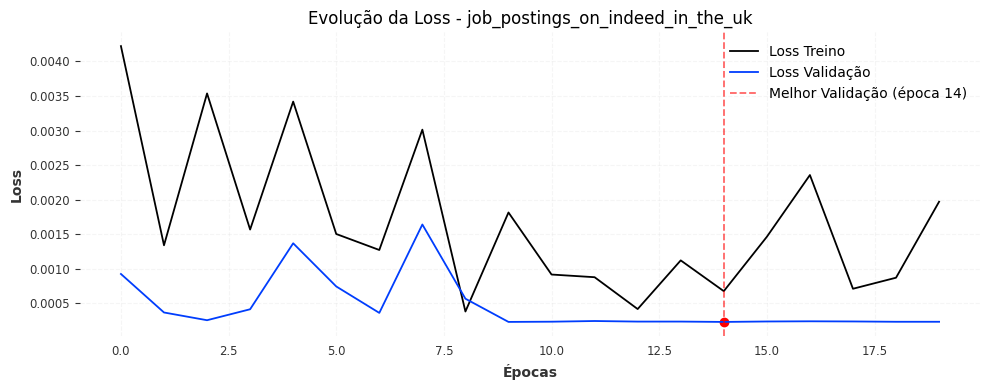

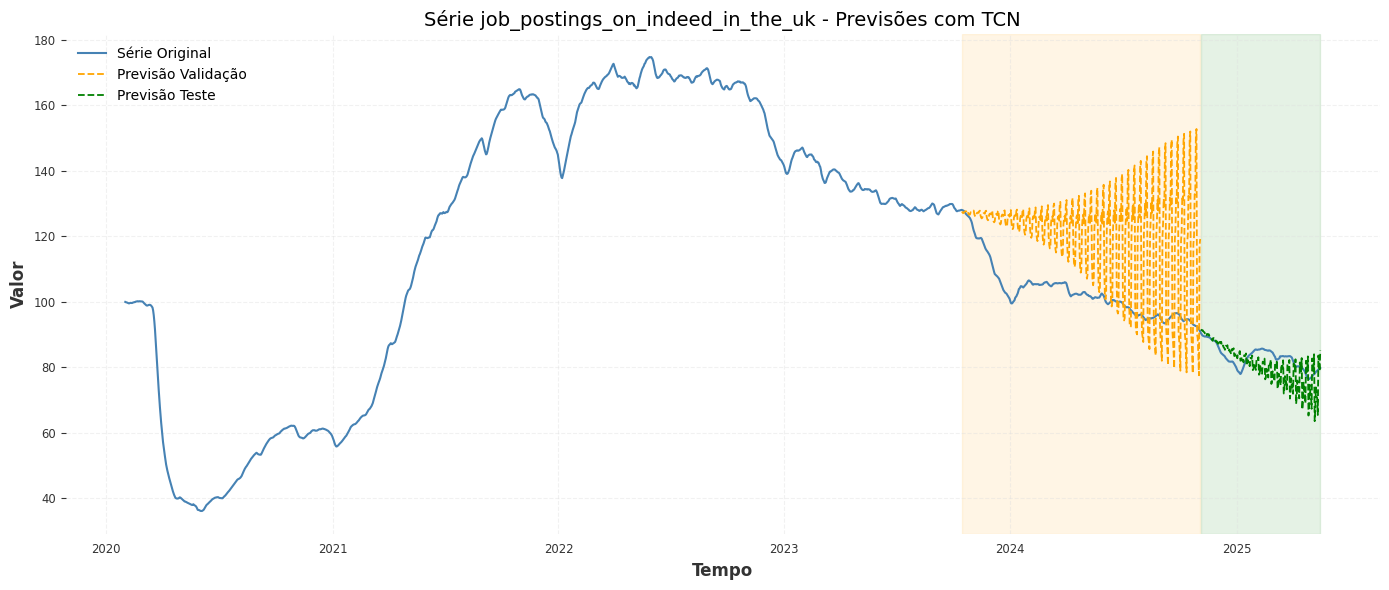

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | res_blocks      | ModuleList       | 174 K  | train
-------------------------------------------------------------
174 K     Trainable params
0         Non-trainable params
174 K     Total params
0.698     Total estimated model params size (MB)
96        Modules in train mode
0         Modules in eval mode



📊 Série 2/6: interest_rates_lt_bond_yields_10_year_main_including_benchmark_for_uk


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


⏱️ Tempo de execução: 2.48 segundos


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

✅ Val MAE: 1.75 | RMSE: 2.11 | MAPE: 99.40% | SMAPE: 53.28%
✅ Test MAE: 1.41 | RMSE: 1.78 | MAPE: 233.22% | SMAPE: 68.50%


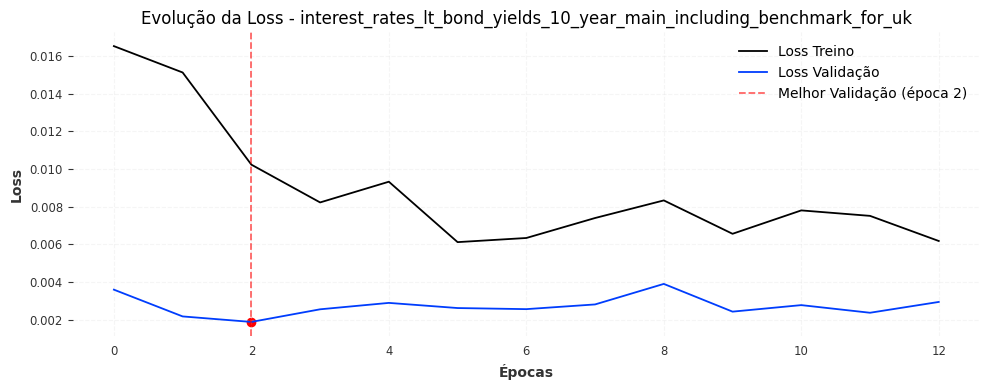

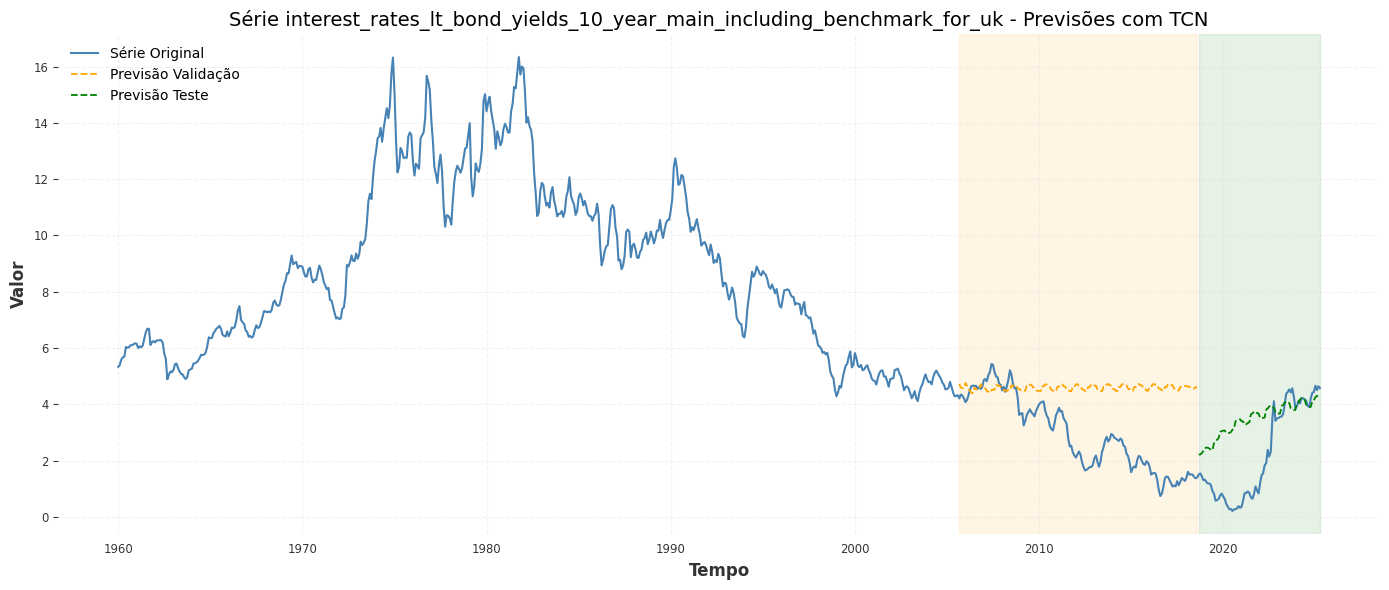

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | res_blocks      | ModuleList       | 174 K  | train
-------------------------------------------------------------
174 K     Trainable params
0         Non-trainable params
174 K     Total params
0.698     Total estimated model params size (MB)
96        Modules in train mode
0         Modules in eval mode



📊 Série 3/6: house_prices_for_uk


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


⏱️ Tempo de execução: 1.54 segundos


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

✅ Val MAE: 60.79 | RMSE: 66.13 | MAPE: 54.02% | SMAPE: 41.49%
✅ Test MAE: 28.46 | RMSE: 29.49 | MAPE: 18.39% | SMAPE: 16.78%


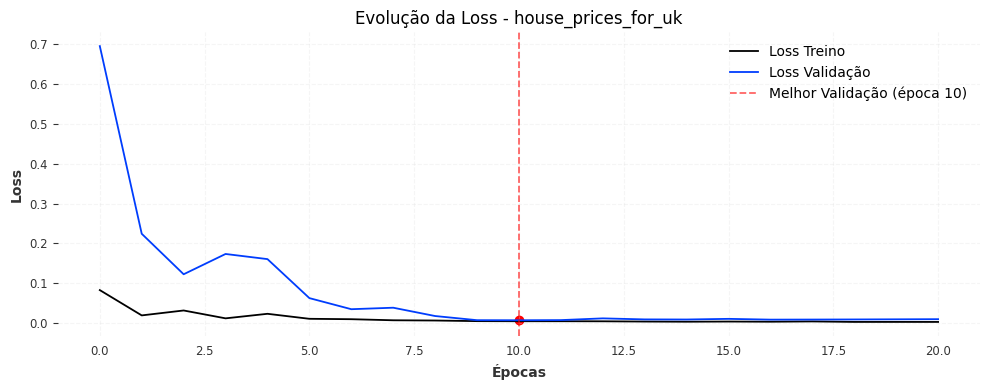

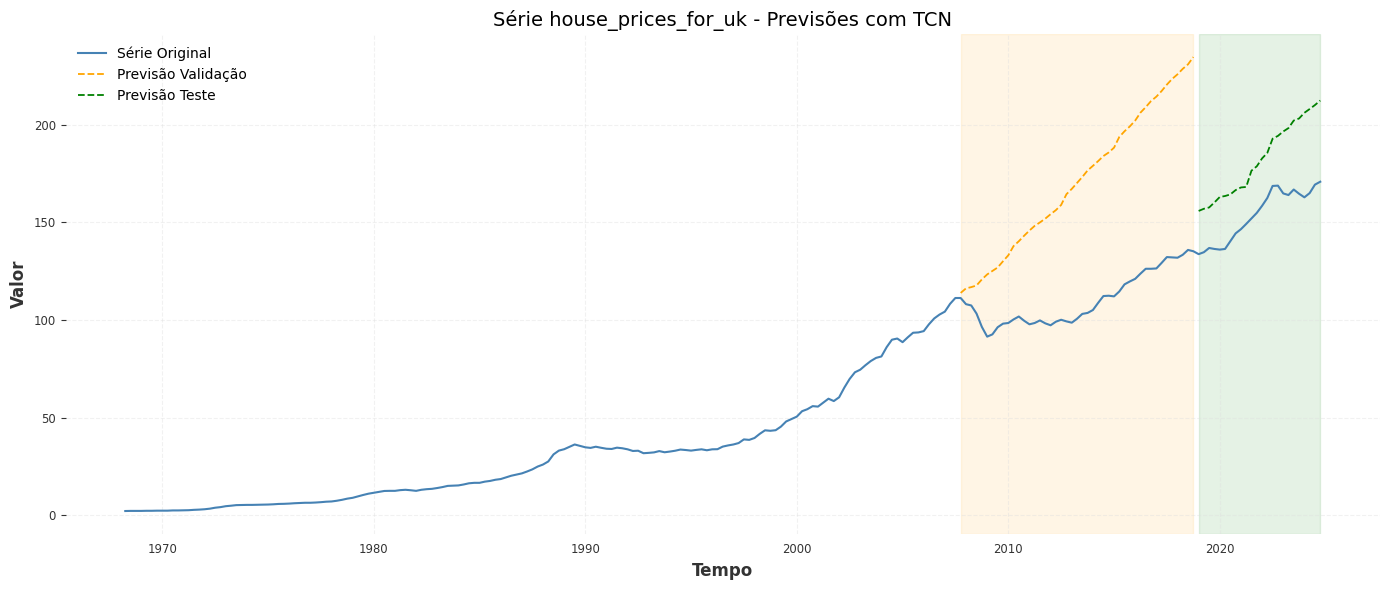

GPU available: True (cuda), used: True



📊 Série 4/6: gdp_for_uk


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | res_blocks      | ModuleList       | 174 K  | train
-------------------------------------------------------------
174 K     Trainable params
0         Non-trainable params
174 K     Total params
0.698     Total estimated model params size (MB)
96        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


⏱️ Tempo de execução: 1.79 segundos


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

✅ Val MAE: 73457.23 | RMSE: 82108.14 | MAPE: 16.70% | SMAPE: 18.49%
✅ Test MAE: 144159.30 | RMSE: 162706.53 | MAPE: 22.83% | SMAPE: 26.46%


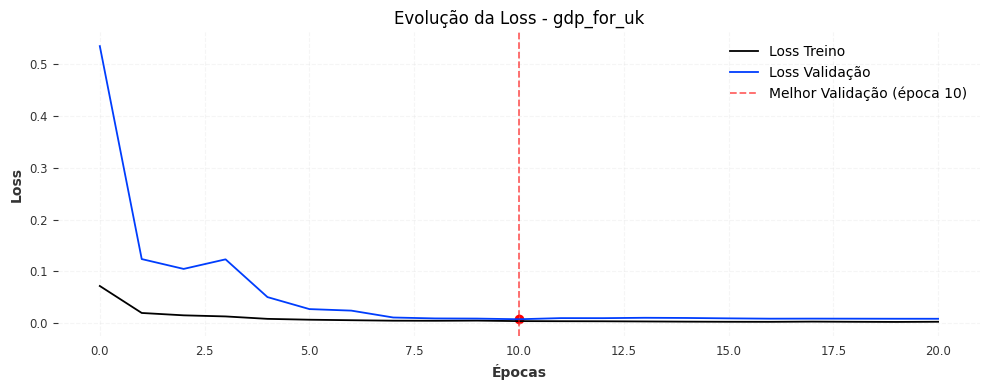

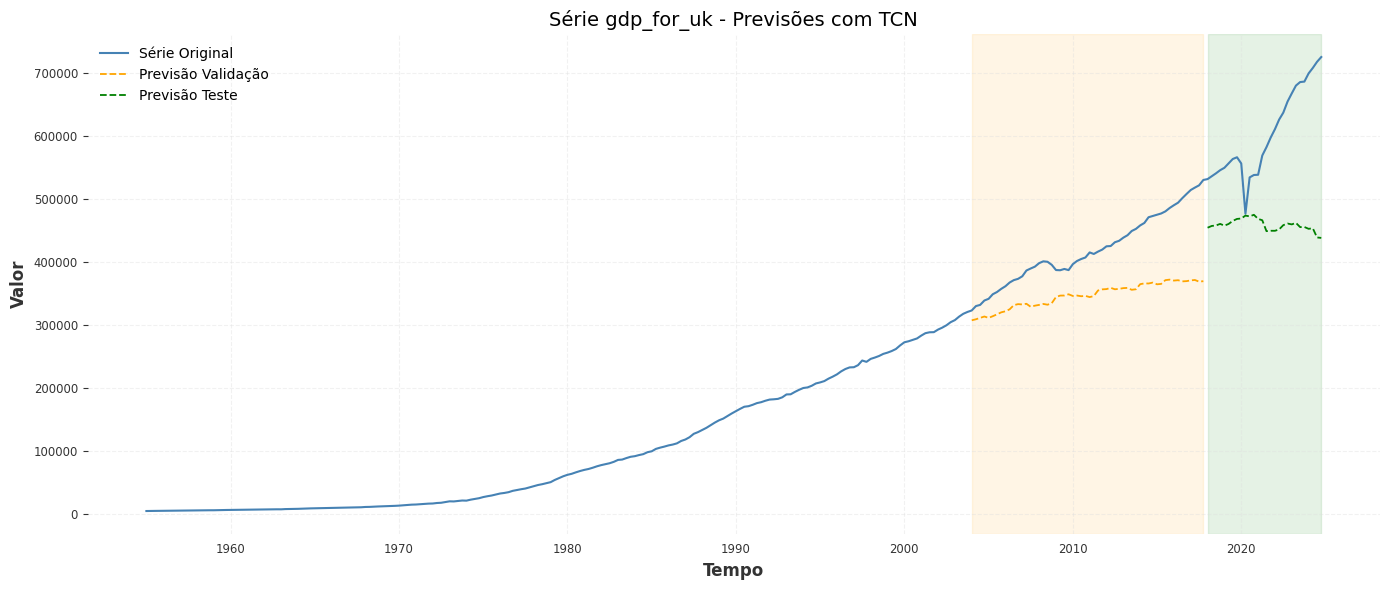

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | res_blocks      | ModuleList       | 174 K  | train
-------------------------------------------------------------
174 K     Trainable params
0         Non-trainable params
174 K     Total params
0.698     Total estimated model params size (MB)
96        Modules in train mode
0         Modules in eval mode



📊 Série 5/6: consumer_price_indices_cpis_hicps_coicop_1999_cpi_total_for_uk


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


⏱️ Tempo de execução: 4.21 segundos


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

✅ Val MAE: 28.92 | RMSE: 32.50 | MAPE: 30.31% | SMAPE: 37.24%
✅ Test MAE: 29.64 | RMSE: 34.04 | MAPE: 24.18% | SMAPE: 28.56%


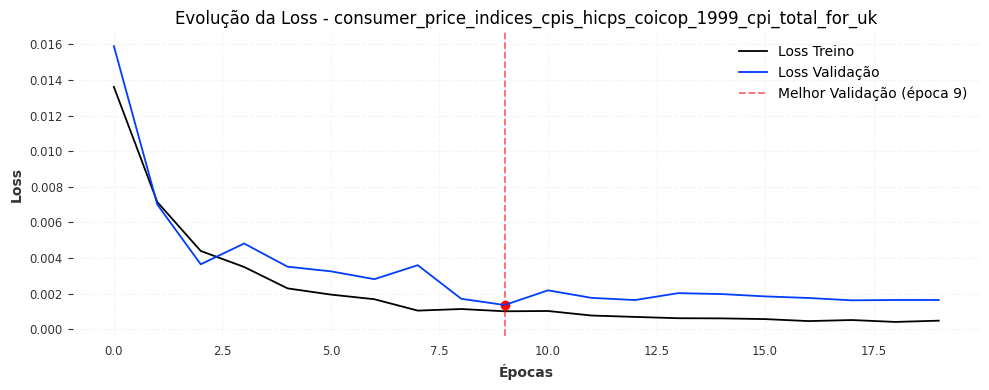

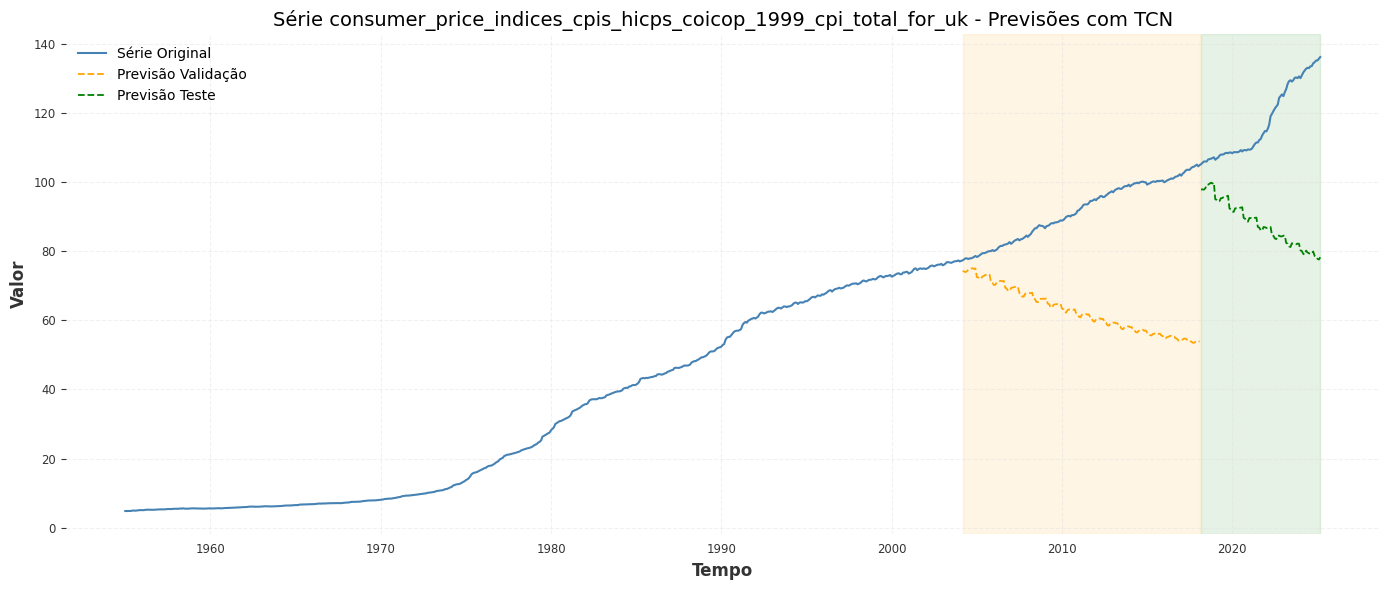

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | res_blocks      | ModuleList       | 174 K  | train
-------------------------------------------------------------
174 K     Trainable params
0         Non-trainable params
174 K     Total params
0.698     Total estimated model params size (MB)
96        Modules in train mode
0         Modules in eval mode



📊 Série 6/6: uk_daily_policy_data


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


⏱️ Tempo de execução: 36.29 segundos


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

✅ Val MAE: 191.71 | RMSE: 231.87 | MAPE: 108.76% | SMAPE: 60.77%
✅ Test MAE: 206.38 | RMSE: 237.09 | MAPE: 372.03% | SMAPE: 74.22%


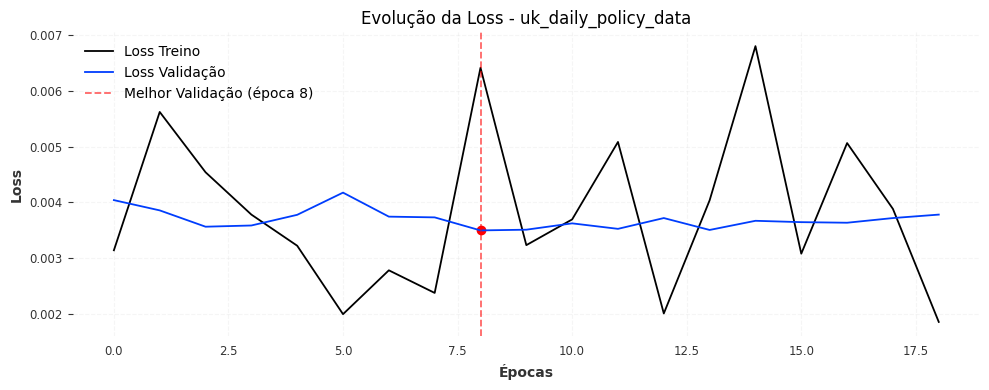

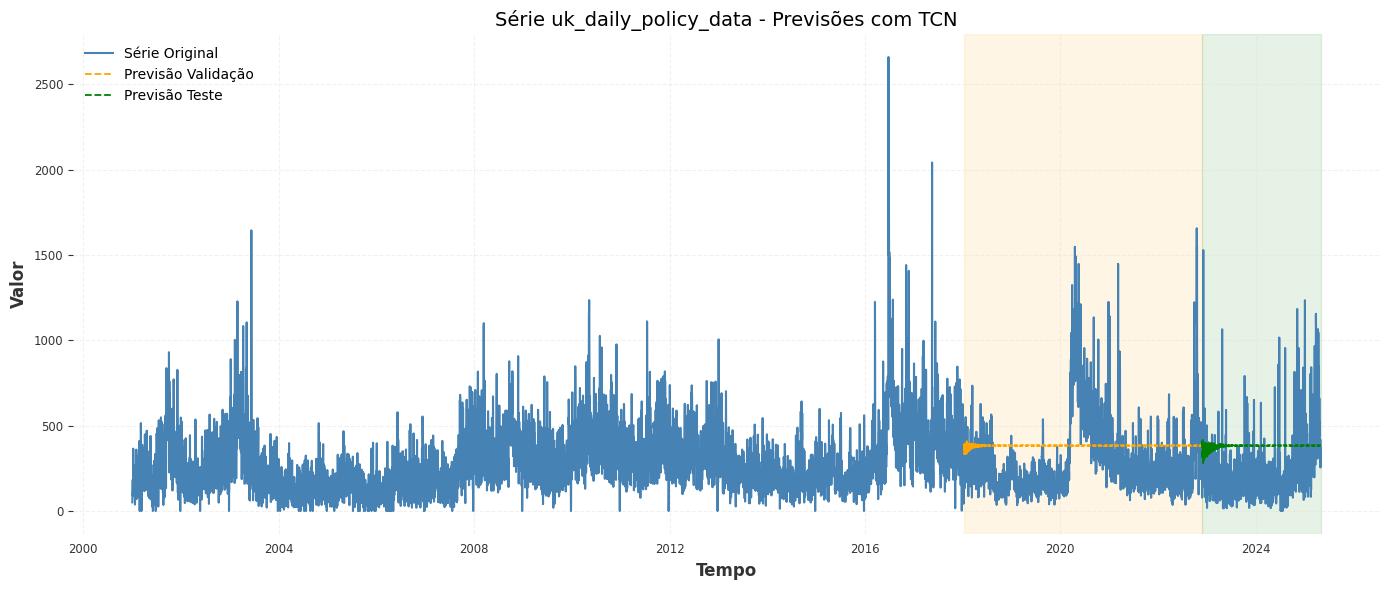


⏱️ Tempo total de execução: 55.39 segundos


nome_serie Frequência  \
0                   job_postings_on_indeed_in_the_uk          D   
1  interest_rates_lt_bond_yields_10_year_main_inc...         MS   
2                                house_prices_for_uk     QS-OCT   
3                                         gdp_for_uk     QS-OCT   
4  consumer_price_indices_cpis_hicps_coicop_1999_...         MS   
5                               uk_daily_policy_data          D   

   Tempo de Treino (s)  Épocas  Melhor Época  \
0                 9.07      20             8   
1                 2.48      13            14   
2                 1.54      21             2   
3                 1.79      21            10   
4                 4.21      20            10   
5                36.29      19             9   

                                        previsao_val  \
0  (((<TimeSeries (DataArray) (time: 1, component...   
1  (((<TimeSeries (DataArray) (time: 1, component...   
2  (((<TimeSeries (DataArray) (time: 1, component...   
3  (((<TimeSeries (DataArray) (time: 1, component...   
4  (((<TimeSeries (DataArray) (time: 1, component...   
5  (((<TimeSeries (DataArray) (observation_date: ...   

                                       previsao_test       val_mae  \
0  (((<TimeSeries (DataArray) (time: 1, component...     19.238911   
1  (((<TimeSeries (DataArray) (time: 1, component...      1.752942   
2  (((<TimeSeries (DataArray) (time: 1, component...     60.792934   
3  (((<TimeSeries (DataArray) (time: 1, component...  73457.226562   
4  (((<TimeSeries (DataArray) (time: 1, component...     28.921579   
5  (((<TimeSeries (DataArray) (observation_date: ...    191.714722   

       val_rmse    val_mape  val_smape       test_mae      test_rmse  \
0     23.124218   19.203259  16.957447       4.263794       5.325131   
1      2.107825   99.395187  53.276199       1.405145       1.784543   
2     66.127800   54.017178  41.487968      28.462305      29.486137   
3  82108.140625   16.701263  18.485758  144159.296875  162706.531250   
4     32.500874   30.307762  37.243095      29.640858      34.041901   
5    231.870972  108.764496  60.767029     206.382614     237.093857   

    test_mape  test_smape  
0    5.202065    5.362972  
1  233.217773   68.495361  
2   18.391088   16.781752  
3   22.829052   26.455141  
4   24.184219   28.557045  
5  372.028839   74.221680

In [51]:
from darts.models import TCNModel
from darts.dataprocessing.transformers import Scaler
from darts import TimeSeries
from darts.metrics import mae, rmse, mape, smape

import numpy as np
import matplotlib.pyplot as plt
import torch
import os

# Criar diretório para guardar os modelos treinados
os.makedirs('modelos_pytorch', exist_ok=True)

# Logger para TensorBoard
logger = TensorBoardLogger(save_dir="tb_logs", name="TCNModel")

# Listas para resultados e tempos de execução
resultados = []
tempos_execucao = []

# Loop sobre as séries temporais (assumindo que 'fred_series_list' está definido)
for i, serie in enumerate(fred_series_list):
    print(f"\n📊 Série {i + 1}/{len(fred_series_list)}: {serie.name}")

    start_time = time.time()

    # Converter para TimeSeries e normalizar
    ts = TimeSeries.from_series(serie).astype(np.float32)
    scaler = Scaler()
    ts_scaled = scaler.fit_transform(ts)

    # Dividir em treino (70%), validação (20%) e teste (10%)
    total_len = len(ts_scaled)
    treino_len = int(0.7 * total_len)
    valid_len = int(0.2 * total_len)
    test_len = total_len - treino_len - valid_len

    train = ts_scaled[:treino_len]
    val = ts_scaled[treino_len:treino_len + valid_len]
    test = ts_scaled[treino_len + valid_len:]

    # Callbacks
    loss_recorder = LossRecorder()
    early_stopper = EarlyStopping(
        monitor="val_loss",
        patience=10,
        min_delta=1e-5,
        mode="min"
    )

    # Modelo TCN
    model_tcn = TCNModel(
        input_chunk_length=30,
        output_chunk_length=10,
        num_filters=64,
        kernel_size=3,
        num_layers=8,
        dilation_base=2,
        dropout=0.2,
        batch_size=32,
        n_epochs=100,
        optimizer_kwargs={"lr": 5e-4},
        random_state=42,
        model_name=f"modelo_tcn_{i}",
        work_dir="modelos_pytorch",
        force_reset=True,
        save_checkpoints=True,
        log_tensorboard=True,
        weight_norm=True,
        lr_scheduler_cls=torch.optim.lr_scheduler.ReduceLROnPlateau,
        lr_scheduler_kwargs={
            "mode": "min",
            "factor": 0.1,
            "patience": 5,
            "min_lr": 1e-6,
        },
        pl_trainer_kwargs={
            "callbacks": [early_stopper, loss_recorder],
            "accelerator": "gpu" if torch.cuda.is_available() else "cpu",
            "val_check_interval": 1.0,
            "log_every_n_steps": 10,
            "logger": logger
        }
    )


    # Treinar modelo
    model_tcn.fit(series=train, val_series=val, verbose=True)

    end_time = time.time()
    elapsed_time = end_time - start_time
    tempos_execucao.append(elapsed_time)
    print(f"⏱️ Tempo de execução: {elapsed_time:.2f} segundos")

    num_epochs = len(loss_recorder.train_loss_history)

    # Depois de treinar
    model = TCNModel.load_from_checkpoint(
        model_name=f"modelo_tcn_{i}", 
        work_dir="modelos_pytorch",
        best=True  # Carrega o melhor checkpoint baseado em val_loss
    )

    # Fazer previsões com o melhor modelo
    pred_val = model_tcn.predict(len(val))
    pred_test = model_tcn.predict(len(test), series=train.concatenate(val))

    # Previsões
    pred_val = model_tcn.predict(len(val))
    pred_test = model_tcn.predict(len(test), series=train.concatenate(val))

    # Desnormalizar
    pred_val_denorm = scaler.inverse_transform(pred_val)
    pred_test_denorm = scaler.inverse_transform(pred_test)
    val_denorm = scaler.inverse_transform(val)
    test_denorm = scaler.inverse_transform(test)

    # Avaliação
    val_mae = mae(val_denorm, pred_val_denorm)
    val_rmse = rmse(val_denorm, pred_val_denorm)
    val_mape = mape(val_denorm, pred_val_denorm)
    val_smape = smape(val_denorm, pred_val_denorm)

    test_mae = mae(test_denorm, pred_test_denorm)
    test_rmse = rmse(test_denorm, pred_test_denorm)
    test_mape = mape(test_denorm, pred_test_denorm)
    test_smape = smape(test_denorm, pred_test_denorm)

    print(f"✅ Val MAE: {val_mae:.2f} | RMSE: {val_rmse:.2f} | MAPE: {val_mape:.2f}% | SMAPE: {val_smape:.2f}%")
    print(f"✅ Test MAE: {test_mae:.2f} | RMSE: {test_rmse:.2f} | MAPE: {test_mape:.2f}% | SMAPE: {test_smape:.2f}%")

    # Guardar resultados
    resultados.append({
        "nome_serie": serie.name,
        'Frequência': serie.index.inferred_freq,
        'Tempo de Treino (s)': round(elapsed_time, 2),
        'Épocas': num_epochs,
        'Melhor Época': best_epoch,
        "previsao_val": pred_val_denorm,
        "previsao_test": pred_test_denorm,
        "val_mae": val_mae,
        "val_rmse": val_rmse,
        "val_mape": val_mape,
        "val_smape": val_smape,
        "test_mae": test_mae,
        "test_rmse": test_rmse,
        "test_mape": test_mape,
        "test_smape": test_smape
    })

    # --- Gráfico da Loss ---
    if loss_recorder.train_loss_history and loss_recorder.val_loss_history:
        plt.figure(figsize=(10, 4))
        plt.plot(loss_recorder.train_loss_history, label='Loss Treino')
        plt.plot(loss_recorder.val_loss_history, label='Loss Validação')
        best_epoch = np.argmin([l if l is not None else np.inf for l in loss_recorder.val_loss_history])
        best_val_loss = loss_recorder.val_loss_history[best_epoch]
        plt.axvline(best_epoch, color='red', linestyle='--', alpha=0.6,
                    label=f'Melhor Validação (época {best_epoch})')
        plt.scatter(best_epoch, best_val_loss, color='red')
        plt.title(f'Evolução da Loss - {serie.name}')
        plt.xlabel('Épocas')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.3)
        plt.tight_layout()
        plt.show()

    # --- Gráfico das Previsões ---
    plt.figure(figsize=(14, 6))
    indices = ts.time_index
    valores_reais = ts.values()
    val_full = np.full(len(ts), np.nan)
    test_full = np.full(len(ts), np.nan)

    val_start_idx = len(train)
    val_end_idx = val_start_idx + len(pred_val)
    test_start_idx = val_end_idx
    test_end_idx = test_start_idx + len(pred_test)

    val_full[val_start_idx:val_end_idx] = pred_val_denorm.values().flatten()
    test_full[test_start_idx:test_end_idx] = pred_test_denorm.values().flatten()

    plt.plot(indices, valores_reais, label="Série Original", color='steelblue', linewidth=1.5)
    plt.plot(indices, val_full, linestyle='--', color='orange', label="Previsão Validação")
    plt.plot(indices, test_full, linestyle='--', color='green', label="Previsão Teste")
    plt.axvspan(indices[val_start_idx], indices[val_end_idx - 1], color='orange', alpha=0.1)
    plt.axvspan(indices[test_start_idx], indices[test_end_idx - 1], color='green', alpha=0.1)
    plt.title(f"Série {serie.name} - Previsões com TCN", fontsize=14)
    plt.xlabel("Tempo", fontsize=12)
    plt.ylabel("Valor", fontsize=12)
    plt.legend(loc='upper left')
    plt.grid(True, linestyle="--", alpha=0.4)
    plt.tight_layout()
    plt.show()

# Tempo total de execução
tempo_total_execucao = sum(tempos_execucao)
print(f"\n⏱️ Tempo total de execução: {tempo_total_execucao:.2f} segundos")

# Criar DataFrame e mostrar tabela
df_resultados = pd.DataFrame(resultados)
df_resultados

#### 3.2. Janela Deslizante (Sliding/Rolling Window)

In [74]:
class LossRecorder(Callback):
    def __init__(self):
        super().__init__()
        self.val_losses = []

    def on_validation_end(self, trainer, pl_module):
        val_loss = trainer.callback_metrics.get("val_loss")
        if val_loss is not None:
            self.val_losses.append(val_loss.item())

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



📊 Série selecionada: job_postings_on_indeed_in_the_uk

📦 Fold 1/10


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



📦 Fold 2/10


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



📦 Fold 3/10


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



📦 Fold 4/10


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



📦 Fold 5/10


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



📦 Fold 6/10


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



📦 Fold 7/10


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



📦 Fold 8/10


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



📦 Fold 9/10


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



📦 Fold 10/10


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]


🕒 Tempo total do fold 10: 5.45 segundos


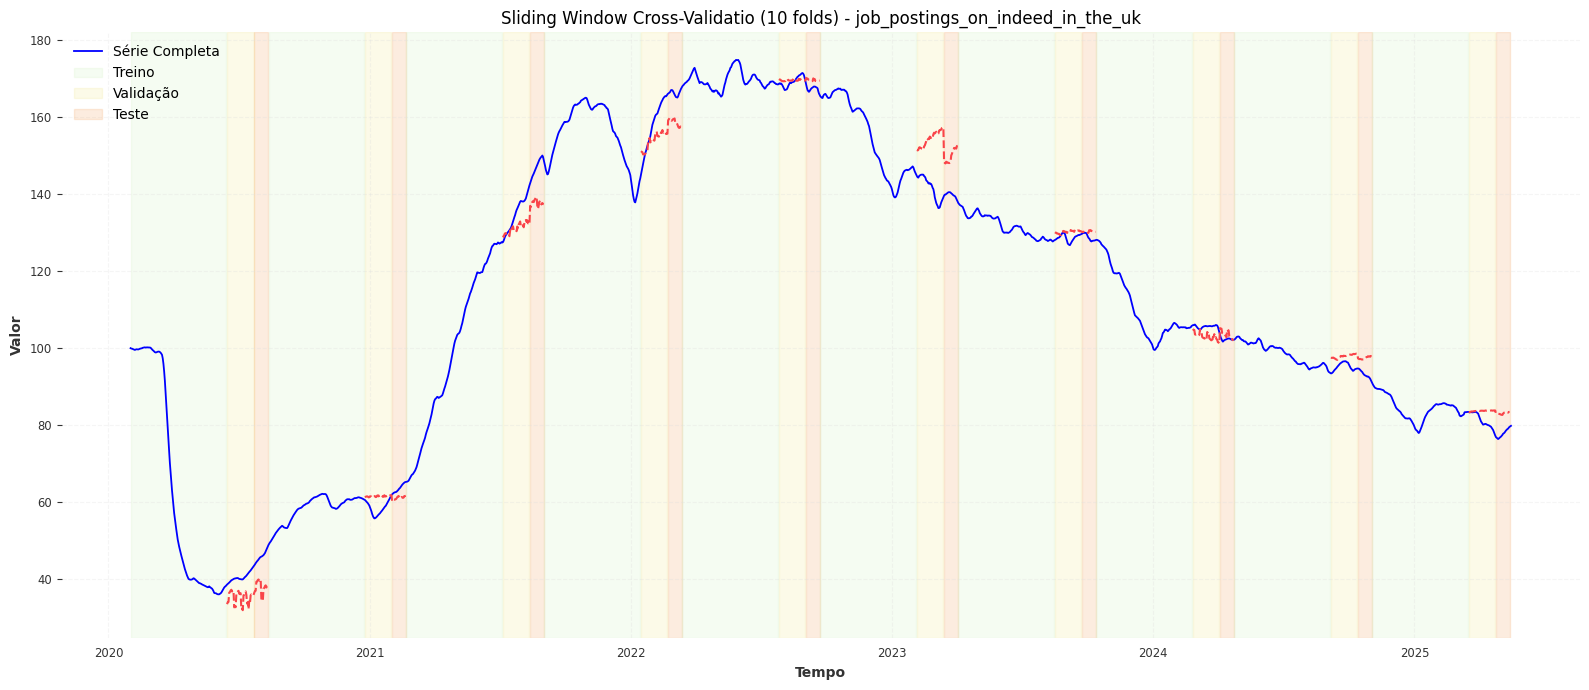


📈 Resultados por fold:
   fold train_start  train_end  val_start    val_end test_start   test_end  \
0     1  2020-02-01 2020-06-14 2020-06-15 2020-07-22 2020-07-23 2020-08-11   
1     2  2020-08-12 2020-12-24 2020-12-25 2021-01-31 2021-02-01 2021-02-20   
2     3  2021-02-21 2021-07-05 2021-07-06 2021-08-12 2021-08-13 2021-09-01   
3     4  2021-09-02 2022-01-14 2022-01-15 2022-02-21 2022-02-22 2022-03-13   
4     5  2022-03-14 2022-07-26 2022-07-27 2022-09-02 2022-09-03 2022-09-22   
5     6  2022-09-23 2023-02-04 2023-02-05 2023-03-14 2023-03-15 2023-04-03   
6     7  2023-04-04 2023-08-16 2023-08-17 2023-09-23 2023-09-24 2023-10-13   
7     8  2023-10-14 2024-02-25 2024-02-26 2024-04-03 2024-04-04 2024-04-23   
8     9  2024-04-24 2024-09-05 2024-09-06 2024-10-13 2024-10-14 2024-11-02   
9    10  2024-11-03 2025-03-17 2025-03-18 2025-04-24 2025-04-25 2025-05-14   

   val_loss  smape_val  smape_test  train_time_sec  
0  0.002841  13.992228   18.901718        0.896302  
1  0.023680

In [90]:
# from darts.metrics import smape
def smape(y_true, y_pred):
    numerator = np.abs(y_pred - y_true)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    return 100 * np.mean(numerator / denominator)

Totaltime = []

# Define os teus parâmetros de Sliding Window
train_frac = 0.7
val_frac = 0.2
test_frac = 0.1

# Apenas para a primeira série
serie = fred_series_list[0]
print(f"\n📊 Série selecionada: {serie.name}")
ts = TimeSeries.from_series(serie).astype(np.float32)
scaler = Scaler()

# Parâmetros do modelo TCN atualizados
model_params = {
    "input_chunk_length": 15,
    "output_chunk_length": 10,
    "num_filters": 32,
    "kernel_size": 3,
    "num_layers": 8,
    "dropout": 0.1,
    "batch_size": 32,
    "n_epochs": 150,
    "optimizer_kwargs": {"lr": 5e-4},
    "random_state": 42,
    "model_name": "modelo_tcn_cv",
    "work_dir": "modelos_pytorch",
    "force_reset": True,
    "save_checkpoints": False,
    "log_tensorboard": False,
    # 'pl_trainer_kwargs' será substituído dentro da função com os callbacks corretos
}

# Sliding window com treino, validação e teste corrigido
def sliding_window_cv(ts, model_params, scaler, n_folds=10):
    total_len = len(ts)
    fold_size = total_len // n_folds  # tamanho de cada segmento (10% do total)

    fold_results = []

    plt.figure(figsize=(16, 7))
    plt.plot(ts.time_index, ts.values(), label="Série Completa", color="blue")

    cores = {'train': '#d0f0c0', 'val': '#f0e68c', 'test': '#f4a460'}

    start_time_total = time.time()

    for fold in range(n_folds):
        fold_start = fold * fold_size
        fold_end = fold_start + fold_size

        # Extrair o segmento da série para este fold
        segment_ts = ts[fold_start:fold_end]

        # Definir os tamanhos para train, val e test dentro do segmento
        segment_len = len(segment_ts)
        train_size = int(train_frac * segment_len)
        val_size_ = int(val_frac * segment_len)
        test_size = segment_len - train_size - val_size_  # garante que dá tudo

        # Definir os índices dentro do segmento
        train_ts = segment_ts[:train_size]
        val_ts = segment_ts[train_size:train_size + val_size_]
        test_ts = segment_ts[train_size + val_size_:]

        print(f"\n📦 Fold {fold+1}/{n_folds}")
        fold_start_time = time.time()

        # Normalização
        train_scaled = scaler.fit_transform(train_ts)
        val_scaled = scaler.transform(val_ts)
        test_scaled = scaler.transform(test_ts)

        # Callbacks
        loss_recorder = LossRecorder()
        early_stopper = EarlyStopping(monitor="val_loss", patience=5, min_delta=1e-5, mode="min")

        model_params_fold = model_params.copy()
        model_params_fold["pl_trainer_kwargs"] = {
            "callbacks": [early_stopper, loss_recorder],
            "accelerator": "gpu" if torch.cuda.is_available() else "cpu",
            "val_check_interval": 1.0,
            "log_every_n_steps": 10,
        }

        model = TCNModel(**model_params_fold)

        # Treino com validação
        model.fit(train_scaled, val_series=val_scaled, verbose=False)

        # Previsão da validação
        pred_val = model.predict(len(val_scaled))

        # Preparar input para previsão do teste:
        # pegar os últimos input_chunk_length pontos da validação como input para prever o teste
        input_chunk_len = model_params["input_chunk_length"]

        # Nota: para evitar index error, garantimos que val_ts tem pelo menos input_chunk_len pontos
        if len(val_scaled) < input_chunk_len:
            raise ValueError(f"Validação demasiado pequena para o input_chunk_length ({input_chunk_len})")

        input_for_test = val_scaled[-input_chunk_len:]  # últimos pontos da validação

        # Previsão do teste, usando input_for_test como ponto de partida
        pred_test = model.predict(len(test_scaled), series=input_for_test)

        # Desnormalizar
        pred_val_denorm = scaler.inverse_transform(pred_val)
        val_denorm = scaler.inverse_transform(val_scaled)
        pred_test_denorm = scaler.inverse_transform(pred_test)
        test_denorm = scaler.inverse_transform(test_scaled)

        # Métricas
        smape_val = smape(np.array(val_denorm.values()), np.array(pred_val_denorm.values()))
        smape_test = smape(np.array(test_denorm.values()), np.array(pred_test_denorm.values()))
        val_loss = loss_recorder.val_losses[-1] if loss_recorder.val_losses else None

        fold_duration = time.time() - fold_start_time

        fold_results.append({
            "fold": fold + 1,
            "train_start": train_ts.time_index[0],
            "train_end": train_ts.time_index[-1],
            "val_start": val_ts.time_index[0],
            "val_end": val_ts.time_index[-1],
            "test_start": test_ts.time_index[0],
            "test_end": test_ts.time_index[-1],
            "val_loss": val_loss,
            "smape_val": smape_val,
            "smape_test": smape_test,
            "train_time_sec": fold_duration
        })

        # Plotar zonas
        plt.axvspan(train_ts.time_index[0], train_ts.time_index[-1], color=cores['train'], alpha=0.2, label='Treino' if fold == 0 else "")
        plt.axvspan(val_ts.time_index[0], val_ts.time_index[-1], color=cores['val'], alpha=0.2, label='Validação' if fold == 0 else "")
        plt.axvspan(test_ts.time_index[0], test_ts.time_index[-1], color=cores['test'], alpha=0.2, label='Teste' if fold == 0 else "")

        # Concatenar os time_index e os valores das previsões
        full_pred_index = pred_val_denorm.time_index.append(pred_test_denorm.time_index)
        full_pred_values = np.concatenate([pred_val_denorm.values(), pred_test_denorm.values()])

        # Plotar a linha contínua das previsões
        plt.plot(full_pred_index, full_pred_values, linestyle='--', linewidth=1.5, color='#f94449')

    total_duration = time.time() - start_time_total
    Totaltime.append(total_duration)
    print(f"\n🕒 Tempo total do fold {fold+1}: {total_duration:.2f} segundos")

    plt.title(f"Sliding Window Cross-Validatio (10 folds) - {serie.name}")
    plt.xlabel("Tempo")
    plt.ylabel("Valor")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.show()

    return pd.DataFrame(fold_results)

# Executar sliding window CV
df_resultados = sliding_window_cv(ts, model_params, scaler, n_folds=10)

# Mostrar resultados finais
print("\n📈 Resultados por fold:")
print(df_resultados)

print(f"\n🕒 Tempo total de execução: {sum(Totaltime):.2f} segundos")

#### 3.3. Transformers (Extra - Não será usado)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 128    | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 335 K  | train
8 | decoder             | Linear              | 5.9 K  | train
--------------------------------------------------------------------
341 K     Trainable params
0         Non-trainable params
341 K     Total


📊 Série selecionada: job_postings_on_indeed_in_the_uk


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

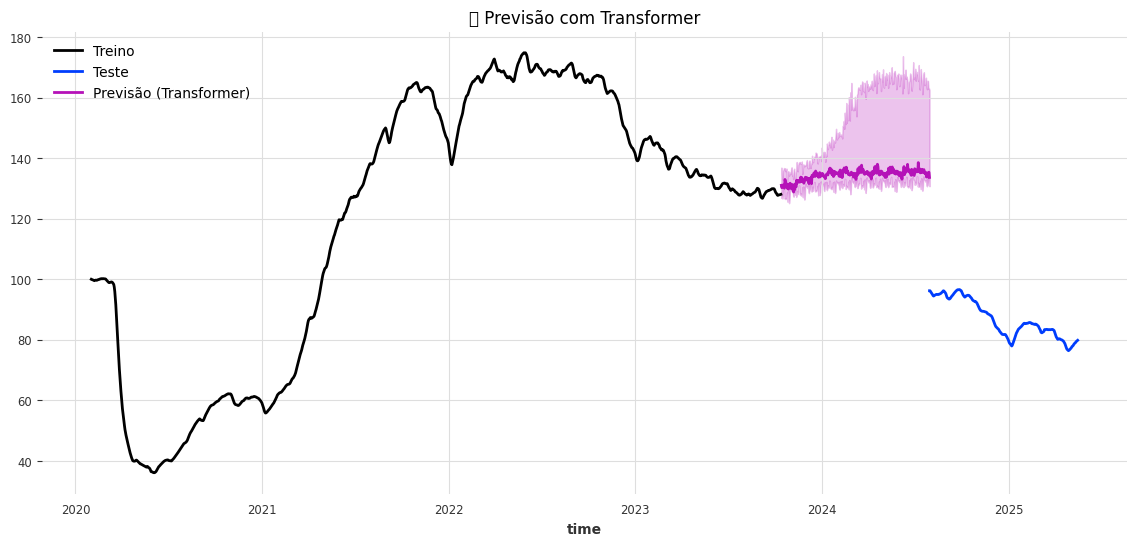

In [100]:
# --- Imports ---
from darts.models import TransformerModel
from darts.dataprocessing.transformers import Scaler
from darts.utils.timeseries_generation import datetime_attribute_timeseries
import matplotlib.pyplot as plt
from darts.utils.likelihood_models import QuantileRegression
from darts import TimeSeries

# --- Selecionar série ---
serie = fred_series_list[0]
print(f"\n📊 Série selecionada: {serie.name}")

# Converter para TimeSeries da Darts
serie_ts = TimeSeries.from_series(serie)

# --- Garantir que é uma série válida ---
assert isinstance(serie_ts, TimeSeries), "A série deve ser um objeto do tipo TimeSeries da Darts."

# --- Normalização ---
scaler = Scaler()
serie_norm = scaler.fit_transform(serie_ts)

# --- Dividir a série temporal: 70% treino, 15% validação, 15% teste ---
train, restante = serie_norm.split_before(0.7)
val, test = restante.split_before(0.5)

# --- Parâmetros do modelo ---
input_chunk = 60
output_chunk = 30
batch_size = 32
n_epochs = 50

# --- Criar e treinar o Transformer ---
model = TransformerModel(
    input_chunk_length=input_chunk,
    output_chunk_length=output_chunk,
    d_model=64,
    nhead=8,
    num_encoder_layers=4,
    num_decoder_layers=4,
    dim_feedforward=128,
    dropout=0.1,
    activation="relu",
    batch_size=batch_size,
    n_epochs=n_epochs,
    model_name="powerful_transformer",
    likelihood=QuantileRegression(quantiles=[0.1, 0.5, 0.9]),
    random_state=42,
    save_checkpoints=True,
    force_reset=True
)

model.fit(train, val_series=val, verbose=True)

# --- Previsão ---
forecast = model.predict(n=len(test), num_samples=100)

# --- Desnormalização ---
forecast_denorm = scaler.inverse_transform(forecast)
test_denorm = scaler.inverse_transform(test)
train_denorm = scaler.inverse_transform(train)

# --- Visualização ---
plt.figure(figsize=(14, 6))
train_denorm.plot(label="Treino")
test_denorm.plot(label="Teste")
forecast_denorm.plot(label="Previsão (Transformer)")
plt.title("🔮 Previsão com Transformer")
plt.legend()
plt.grid(True)
plt.show()

## 4. A influência da incerteza politica nas outras series

In [ ]:
def descrever_frequencia(freq):
    """
    Converte o código de frequência inferida para uma descrição legível por extenso.
    """
    mapa_frequencias = {
        'D': 'Diária',
        'B': 'Dias úteis',
        'W': 'Semanal',
        'M': 'Mensal (final do mês)',
        'MS': 'Mensal (início do mês)',
        'Q': 'Trimestral (final do trimestre)',
        'QS': 'Trimestral (início do trimestre)',
        'QS-JAN': 'Trimestral (início em janeiro)',
        'QS-FEB': 'Trimestral (início em fevereiro)',
        'QS-MAR': 'Trimestral (início em março)',
        'QS-APR': 'Trimestral (início em abril)',
        'QS-MAY': 'Trimestral (início em maio)',
        'QS-JUN': 'Trimestral (início em junho)',
        'QS-JUL': 'Trimestral (início em julho)',
        'QS-AUG': 'Trimestral (início em agosto)',
        'QS-SEP': 'Trimestral (início em setembro)',
        'QS-OCT': 'Trimestral (início em outubro)',
        'QS-NOV': 'Trimestral (início em novembro)',
        'QS-DEC': 'Trimestral (início em dezembro)',
        'Q-JAN': 'Trimestral (fim em março)',
        'Q-APR': 'Trimestral (fim em junho)',
        'Q-JUL': 'Trimestral (fim em setembro)',
        'Q-OCT': 'Trimestral (fim em dezembro)',
        'A': 'Anual (fim de ano)',
        'A-DEC': 'Anual (dezembro)',
        'A-JAN': 'Anual (janeiro)',
        'H': 'Horária',
        'T': 'Minutária',
        'S': 'Segundo a segundo',
        None: 'Frequência não identificada'
    }
    return mapa_frequencias.get(freq, f'Frequência desconhecida ({freq})')

In [ ]:
# Frequencia Temporal de cada uma das series
for serie in fred_series_list:
    nome = serie.name
    inicio = serie.index.min()
    fim = serie.index.max()
    freq = serie.index.inferred_freq  # frequência inferida
    print(f"{nome}: {inicio.date()} a {fim.date()} (Frequência: {descrever_frequencia(freq)})")

job_postings_on_indeed_in_the_uk: 2020-02-01 a 2025-05-09 (Frequência: Diária)
interest_rates_lt_bond_yields_10_year_main_including_benchmark_for_uk: 1960-01-01 a 2025-04-01 (Frequência: Mensal (início do mês))
house_prices_for_uk: 1968-04-01 a 2024-10-01 (Frequência: Trimestral (início em outubro))
gdp_for_uk: 1955-01-01 a 2024-10-01 (Frequência: Trimestral (início em outubro))
consumer_price_indices_cpis_hicps_coicop_1999_cpi_total_for_uk: 1955-01-01 a 2025-03-01 (Frequência: Mensal (início do mês))
uk_daily_policy_data: 2001-01-01 a 2025-04-30 (Frequência: Diária)


### 4.0. Tratamento: agregação e alinhamento

In [ ]:
from statsmodels.tsa.stattools import grangercausalitytests
import statsmodels.api as sm
from statsmodels.tsa.ardl import ARDL, ardl_select_order

# --- 3.1 Tratamento: agregação e alinhamento para todas as séries ---
# Função para agregar uk_daily_policy_data à frequência da série alvo
def aggregate_uk_policy(uk_daily, freq):
    # Resample explícito para evitar NaNs por agrupamento
    uk_agg = uk_daily.resample(freq).mean()
    uk_agg = uk_agg.dropna()  # elimina eventuais NaNs pós-aggregação
    return uk_agg

# Função para alinhar as séries por intersecção temporal
def align_series(series1, series2):
    df = pd.concat([series1, series2], axis=1).dropna()
    return df.iloc[:,0], df.iloc[:,1]

aligned_data = {}  # guarda tuplos (y, x) por cada série

print("### 3.1 Tratamento: agregação e alinhamento ###")
for serie in fred_series_list[:-1]:
    freq = serie.index.inferred_freq or 'MS'
    uk_agg = aggregate_uk_policy(fred_series_list[-1], freq)
    y, x = align_series(serie, uk_agg)
    aligned_data[serie.name] = (y, x)
    print(f"\033[1m{serie.name}\033[0m: Frequência \033[1m{freq}\033[0m, Intervalo comum \033[1m{y.index.min()}\033[0m a \033[1m{y.index.max()}\033[0m, tamanho: \033[1m{len(y)}\033[0m")

### 3.1 Tratamento: agregação e alinhamento ###
job_postings_on_indeed_in_the_uk: Frequência D, Intervalo comum 2020-02-01 00:00:00 a 2025-04-30 00:00:00, tamanho: 1916
interest_rates_lt_bond_yields_10_year_main_including_benchmark_for_uk: Frequência MS, Intervalo comum 2001-01-01 00:00:00 a 2025-04-01 00:00:00, tamanho: 292
house_prices_for_uk: Frequência QS-OCT, Intervalo comum 2001-01-01 00:00:00 a 2024-10-01 00:00:00, tamanho: 96
gdp_for_uk: Frequência QS-OCT, Intervalo comum 2001-01-01 00:00:00 a 2024-10-01 00:00:00, tamanho: 96
consumer_price_indices_cpis_hicps_coicop_1999_cpi_total_for_uk: Frequência MS, Intervalo comum 2001-01-01 00:00:00 a 2025-03-01 00:00:00, tamanho: 291


### 4.1 Correlação de Pearson

$$
r = \frac{\sum_{i=1}^{n} (X_i - \bar{X})(Y_i - \bar{Y})}{\sqrt{\sum_{i=1}^{n} (X_i - \bar{X})^2} \cdot \sqrt{\sum_{i=1}^{n} (Y_i - \bar{Y})^2}}
$$

Onde:

- $r$: coeficiente de correlação de Pearson  
- $X_i, Y_i$: valores observados das variáveis  
- $\bar{X}, \bar{Y}$: média das variáveis $X$ e $Y$  
- $n$: número de observações  


Série: job_postings_on_indeed_in_the_uk
Correlação de Pearson: -0.4533


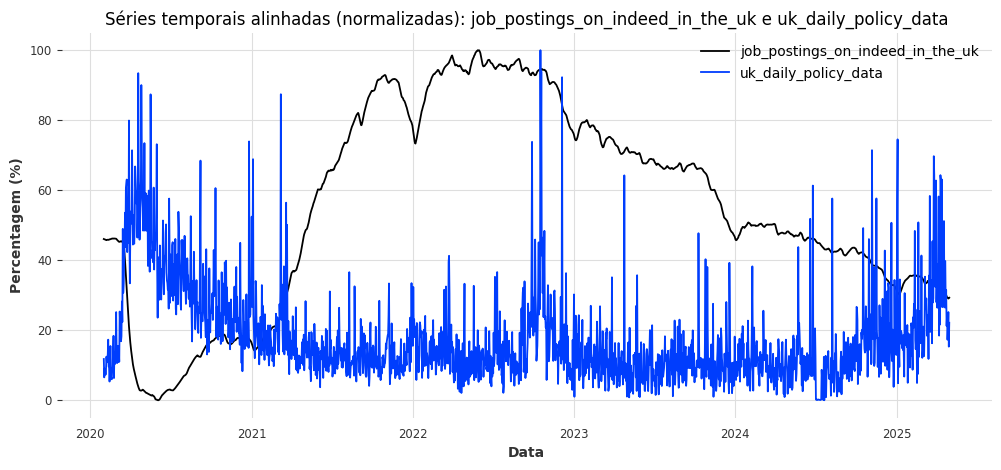


Série: interest_rates_lt_bond_yields_10_year_main_including_benchmark_for_uk
Correlação de Pearson: -0.2994


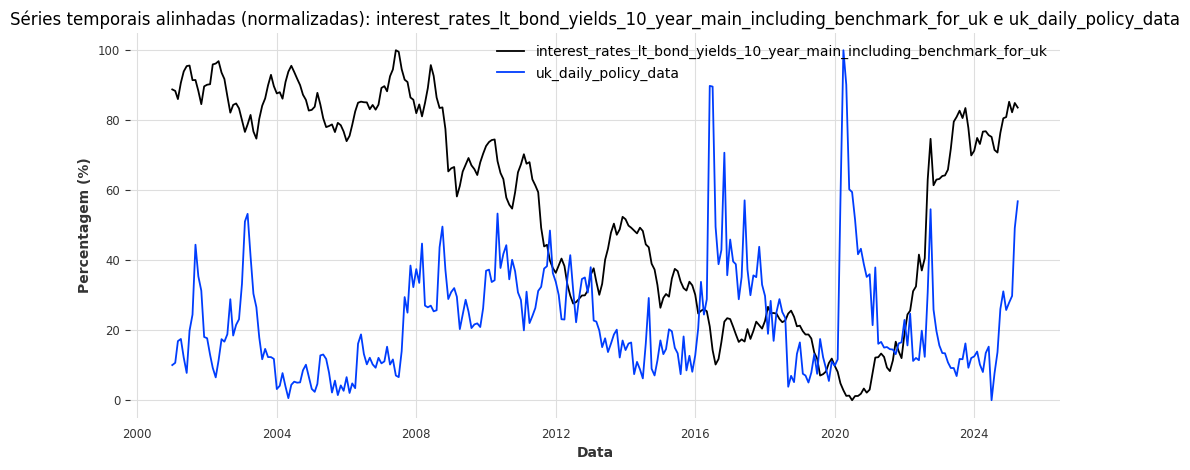


Série: house_prices_for_uk
Correlação de Pearson: 0.0412


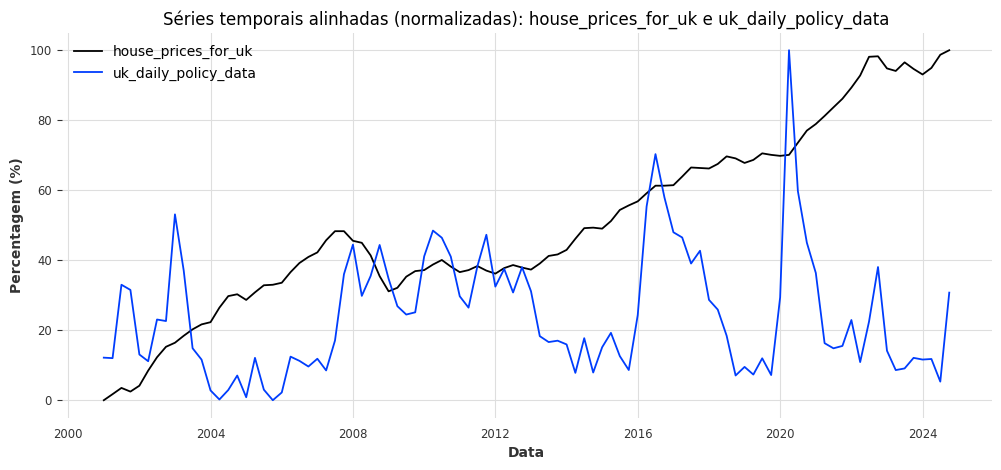


Série: gdp_for_uk
Correlação de Pearson: 0.0067


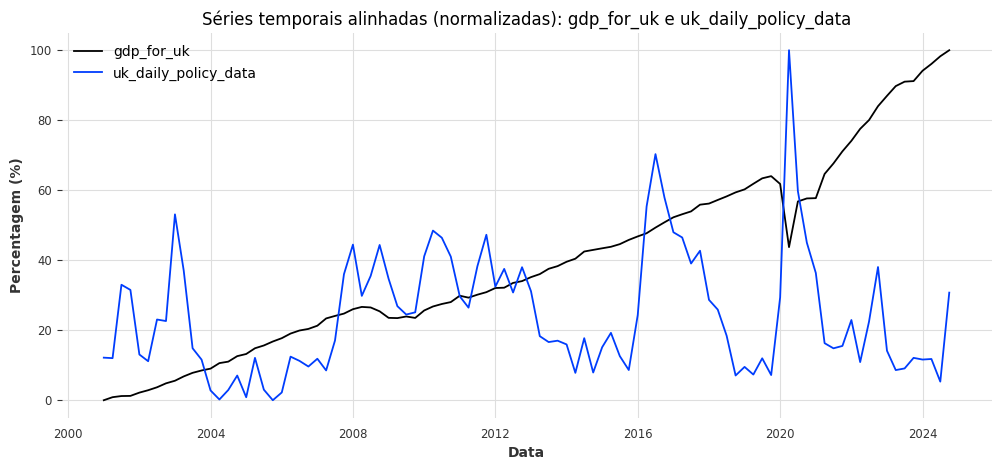


Série: consumer_price_indices_cpis_hicps_coicop_1999_cpi_total_for_uk
Correlação de Pearson: 0.0682


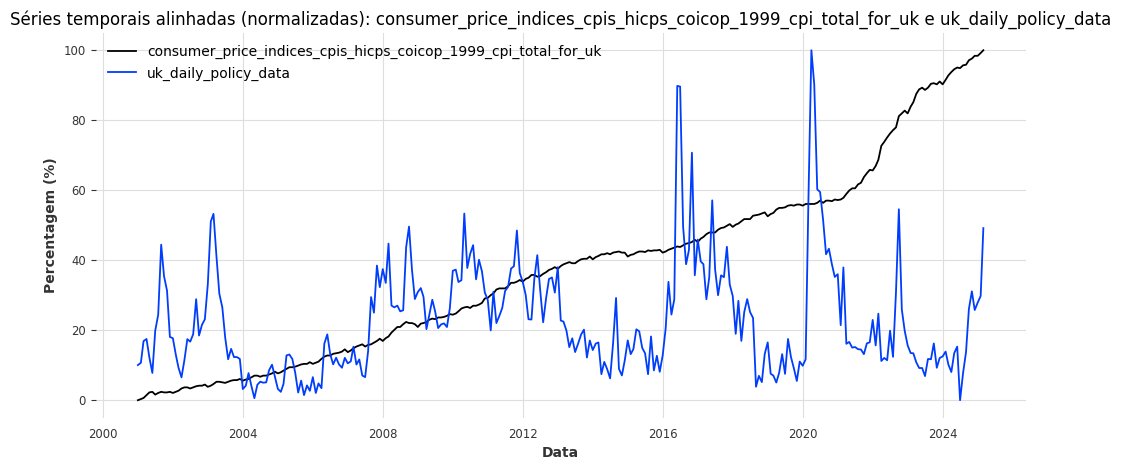


**Correlação de Pearson com `uk_daily_policy_data`**

|   Nº | Série Comparada                                                       |   Correlação de Pearson |
|-----:|:----------------------------------------------------------------------|------------------------:|
|    1 | job_postings_on_indeed_in_the_uk                                      |                 -0.4533 |
|    2 | interest_rates_lt_bond_yields_10_year_main_including_benchmark_for_uk |                 -0.2994 |
|    3 | house_prices_for_uk                                                   |                  0.0412 |
|    4 | gdp_for_uk                                                            |                  0.0067 |
|    5 | consumer_price_indices_cpis_hicps_coicop_1999_cpi_total_for_uk        |                  0.0682 |


In [ ]:
pearson_results = []

for i, (serie_name, (y, x)) in enumerate(aligned_data.items(), 1):
    corr_pearson = y.corr(x)
    print(f"\nSérie: {serie_name}")
    print(f"Correlação de Pearson: \033[1m{corr_pearson:.4f}\033[0m")

    # Guardar os resultados para a tabela
    pearson_results.append({
        "Nº": i,
        "Série Comparada": serie_name,
        "Correlação de Pearson": corr_pearson
    })

    # Plota as séries normalizadas
    y_norm = 100 * (y - y.min()) / (y.max() - y.min())
    x_norm = 100 * (x - x.min()) / (x.max() - x.min())

    plt.figure(figsize=(12, 5))
    plt.plot(y_norm, label=f"{serie_name}")
    plt.plot(x_norm, label=f"{fred_series_list[-1].name}")
    plt.title(f"Séries temporais alinhadas (normalizadas): {serie_name} e {fred_series_list[-1].name}")
    plt.xlabel("Data")
    plt.ylabel("Percentagem (%)")
    plt.legend()
    plt.show()

# Criar DataFrame com resultados
df_pearson = pd.DataFrame(pearson_results)

# Formatar a coluna da correlação a 4 casas decimais e negrito para impressão em markdown
df_pearson["Correlação de Pearson"] = df_pearson["Correlação de Pearson"].apply(lambda x: f"{x:.4f}")

# Imprimir tabela em markdown
print("\n**Correlação de Pearson com `uk_daily_policy_data`**\n")
print(df_pearson.to_markdown(index=False))


### 4.2. Correlação Cruzada

$$
\rho_{XY}(\ell) = \frac{\sum_{t} (X_{t+\ell} - \bar{X})(Y_t - \bar{Y})}{\sqrt{\sum_{t} (X_{t+\ell} - \bar{X})^2} \cdot \sqrt{\sum_{t} (Y_t - \bar{Y})^2}}
$$

Onde:

- $\ell$: lag (deslocamento temporal), positivo ou negativo  
- $\bar{X}, \bar{Y}$: médias das séries  
- $\rho_{XY}(\ell)$: correlação de Pearson entre $X$ deslocada e $Y$ fixa

Depois de analisar a correlação de Pearson para ver o impacto da incerteza política noutras métricas, vamos agora olhar para a correlação cruzada. Esta técnica permite perceber como duas séries temporais se relacionam quando uma delas é deslocada no tempo — ou seja, ajuda a identificar se uma variável reage com atraso ou antecipação a outra. É uma forma útil de captar dependências temporais e potenciais causas entre as séries.
> A série a ser deslocada será a `uk_daily_policy_data`


### 3.3 Correlação Cruzada ###
Correlação cruzada (lags -24 a 24):
  Lag -24: -0.4084 (linhas usadas: 1892)
  Lag -23: -0.4105 (linhas usadas: 1893)
  Lag -22: -0.4128 (linhas usadas: 1894)
  Lag -21: -0.4149 (linhas usadas: 1895)
  Lag -20: -0.4168 (linhas usadas: 1896)
  Lag -19: -0.4187 (linhas usadas: 1897)
  Lag -18: -0.4205 (linhas usadas: 1898)
  Lag -17: -0.4224 (linhas usadas: 1899)
  Lag -16: -0.4244 (linhas usadas: 1900)
  Lag -15: -0.4264 (linhas usadas: 1901)
  Lag -14: -0.4284 (linhas usadas: 1902)
  Lag -13: -0.4302 (linhas usadas: 1903)
  Lag -12: -0.4321 (linhas usadas: 1904)
  Lag -11: -0.4338 (linhas usadas: 1905)
  Lag -10: -0.4357 (linhas usadas: 1906)
  Lag -9: -0.4374 (linhas usadas: 1907)
  Lag -8: -0.4391 (linhas usadas: 1908)
  Lag -7: -0.4410 (linhas usadas: 1909)
  Lag -6: -0.4429 (linhas usadas: 1910)
  Lag -5: -0.4447 (linhas usadas: 1911)
  Lag -4: -0.4465 (linhas usadas: 1912)
  Lag -3: -0.4483 (linhas usadas: 1913)
  Lag -2: -0.4500 (linhas usadas: 191

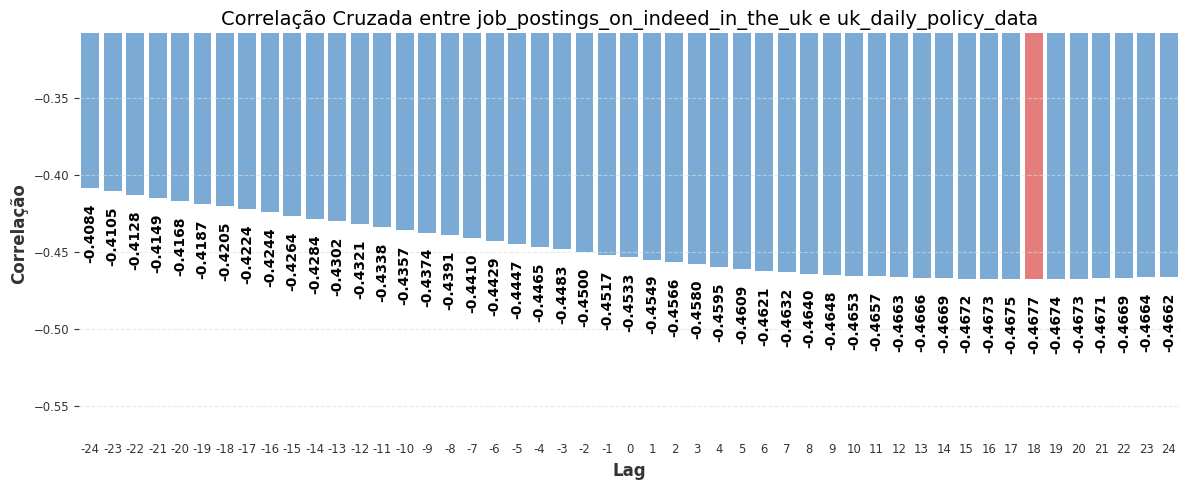

Correlação cruzada (lags -24 a 24):
  Lag -24: -0.0011 (linhas usadas: 268)
  Lag -23: -0.0091 (linhas usadas: 269)
  Lag -22: -0.0211 (linhas usadas: 270)
  Lag -21: -0.0266 (linhas usadas: 271)
  Lag -20: -0.0269 (linhas usadas: 272)
  Lag -19: -0.0372 (linhas usadas: 273)
  Lag -18: -0.0545 (linhas usadas: 274)
  Lag -17: -0.0765 (linhas usadas: 275)
  Lag -16: -0.0977 (linhas usadas: 276)
  Lag -15: -0.1199 (linhas usadas: 277)
  Lag -14: -0.1384 (linhas usadas: 278)
  Lag -13: -0.1479 (linhas usadas: 279)
  Lag -12: -0.1528 (linhas usadas: 280)
  Lag -11: -0.1676 (linhas usadas: 281)
  Lag -10: -0.1827 (linhas usadas: 282)
  Lag -9: -0.1897 (linhas usadas: 283)
  Lag -8: -0.1906 (linhas usadas: 284)
  Lag -7: -0.2012 (linhas usadas: 285)
  Lag -6: -0.2130 (linhas usadas: 286)
  Lag -5: -0.2254 (linhas usadas: 287)
  Lag -4: -0.2361 (linhas usadas: 288)
  Lag -3: -0.2508 (linhas usadas: 289)
  Lag -2: -0.2688 (linhas usadas: 290)
  Lag -1: -0.2823 (linhas usadas: 291)
  Lag 0: -0.2

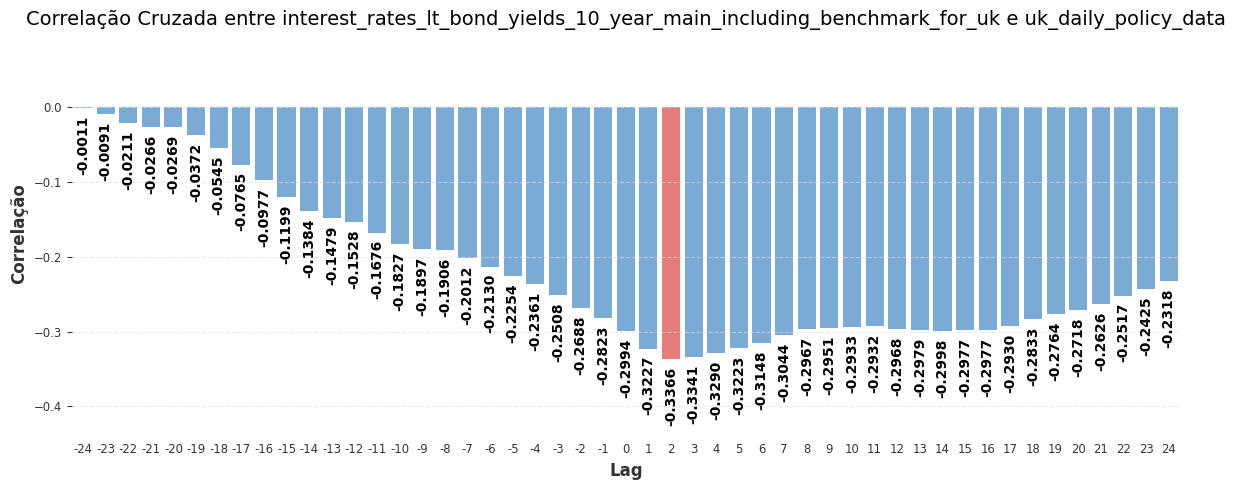

Correlação cruzada (lags -24 a 24):
  Lag -24: -0.1932 (linhas usadas: 72)
  Lag -23: -0.1433 (linhas usadas: 73)
  Lag -22: -0.1037 (linhas usadas: 74)
  Lag -21: -0.0705 (linhas usadas: 75)
  Lag -20: -0.0207 (linhas usadas: 76)
  Lag -19: 0.0292 (linhas usadas: 77)
  Lag -18: 0.0681 (linhas usadas: 78)
  Lag -17: 0.0899 (linhas usadas: 79)
  Lag -16: 0.1208 (linhas usadas: 80)
  Lag -15: 0.1331 (linhas usadas: 81)
  Lag -14: 0.1507 (linhas usadas: 82)
  Lag -13: 0.1733 (linhas usadas: 83)
  Lag -12: 0.1895 (linhas usadas: 84)
  Lag -11: 0.1910 (linhas usadas: 85)
  Lag -10: 0.1865 (linhas usadas: 86)
  Lag -9: 0.1520 (linhas usadas: 87)
  Lag -8: 0.0934 (linhas usadas: 88)
  Lag -7: 0.0753 (linhas usadas: 89)
  Lag -6: 0.0544 (linhas usadas: 90)
  Lag -5: 0.0528 (linhas usadas: 91)
  Lag -4: 0.0590 (linhas usadas: 92)
  Lag -3: 0.0478 (linhas usadas: 93)
  Lag -2: 0.0336 (linhas usadas: 94)
  Lag -1: 0.0417 (linhas usadas: 95)
  Lag 0: 0.0412 (linhas usadas: 96)
  Lag 1: 0.0207 (lin

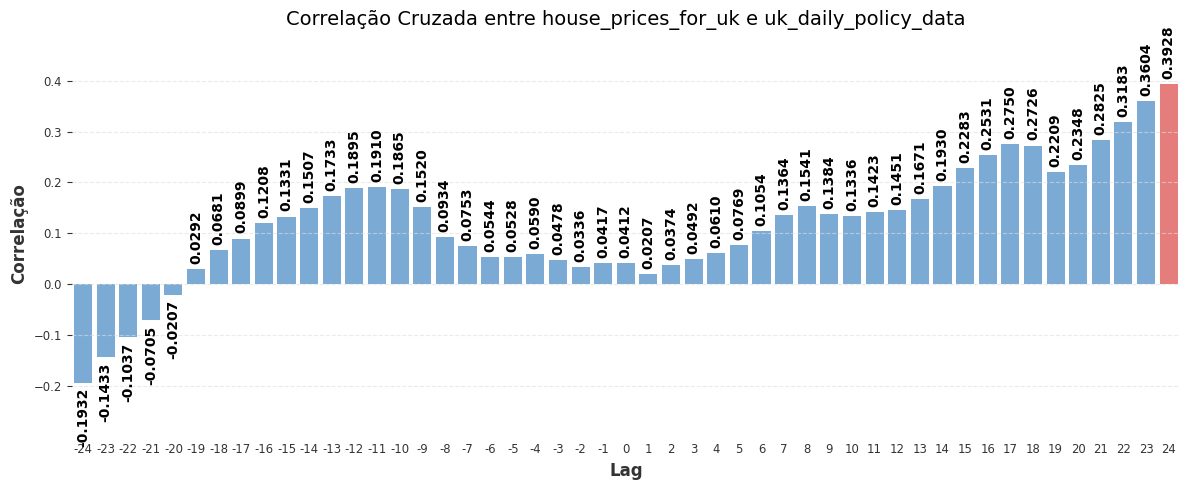

Correlação cruzada (lags -24 a 24):
  Lag -24: -0.2153 (linhas usadas: 72)
  Lag -23: -0.1779 (linhas usadas: 73)
  Lag -22: -0.1502 (linhas usadas: 74)
  Lag -21: -0.1269 (linhas usadas: 75)
  Lag -20: -0.0909 (linhas usadas: 76)
  Lag -19: -0.0545 (linhas usadas: 77)
  Lag -18: -0.0208 (linhas usadas: 78)
  Lag -17: 0.0196 (linhas usadas: 79)
  Lag -16: 0.0523 (linhas usadas: 80)
  Lag -15: 0.0817 (linhas usadas: 81)
  Lag -14: 0.1162 (linhas usadas: 82)
  Lag -13: 0.1464 (linhas usadas: 83)
  Lag -12: 0.1674 (linhas usadas: 84)
  Lag -11: 0.1708 (linhas usadas: 85)
  Lag -10: 0.1595 (linhas usadas: 86)
  Lag -9: 0.1393 (linhas usadas: 87)
  Lag -8: 0.1014 (linhas usadas: 88)
  Lag -7: 0.0858 (linhas usadas: 89)
  Lag -6: 0.0809 (linhas usadas: 90)
  Lag -5: 0.0835 (linhas usadas: 91)
  Lag -4: 0.0837 (linhas usadas: 92)
  Lag -3: 0.0620 (linhas usadas: 93)
  Lag -2: 0.0379 (linhas usadas: 94)
  Lag -1: 0.0258 (linhas usadas: 95)
  Lag 0: 0.0067 (linhas usadas: 96)
  Lag 1: 0.0141 (l

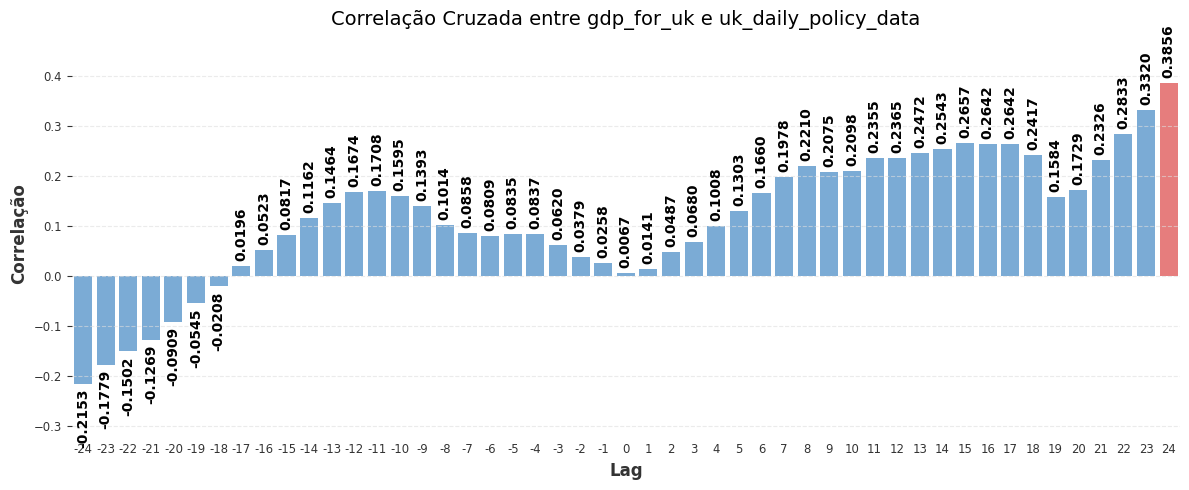

Correlação cruzada (lags -24 a 24):
  Lag -24: 0.0909 (linhas usadas: 267)
  Lag -23: 0.0888 (linhas usadas: 268)
  Lag -22: 0.0863 (linhas usadas: 269)
  Lag -21: 0.0848 (linhas usadas: 270)
  Lag -20: 0.0791 (linhas usadas: 271)
  Lag -19: 0.0776 (linhas usadas: 272)
  Lag -18: 0.0767 (linhas usadas: 273)
  Lag -17: 0.0743 (linhas usadas: 274)
  Lag -16: 0.0739 (linhas usadas: 275)
  Lag -15: 0.0758 (linhas usadas: 276)
  Lag -14: 0.0765 (linhas usadas: 277)
  Lag -13: 0.0783 (linhas usadas: 278)
  Lag -12: 0.0782 (linhas usadas: 279)
  Lag -11: 0.0783 (linhas usadas: 280)
  Lag -10: 0.0732 (linhas usadas: 281)
  Lag -9: 0.0673 (linhas usadas: 282)
  Lag -8: 0.0581 (linhas usadas: 283)
  Lag -7: 0.0567 (linhas usadas: 284)
  Lag -6: 0.0569 (linhas usadas: 285)
  Lag -5: 0.0603 (linhas usadas: 286)
  Lag -4: 0.0619 (linhas usadas: 287)
  Lag -3: 0.0627 (linhas usadas: 288)
  Lag -2: 0.0624 (linhas usadas: 289)
  Lag -1: 0.0655 (linhas usadas: 290)
  Lag 0: 0.0682 (linhas usadas: 291)


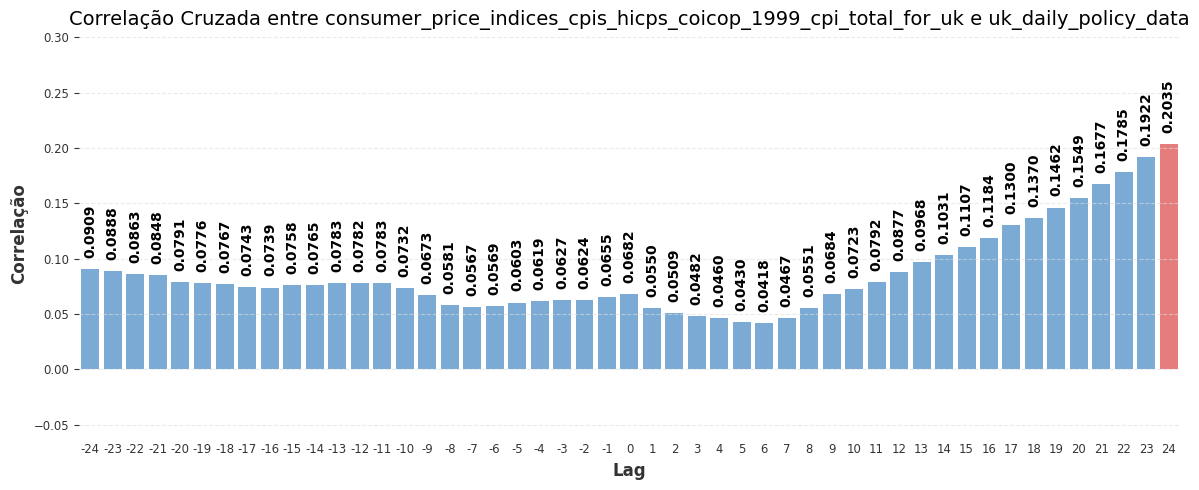

{'job_postings_on_indeed_in_the_uk': [(-24, np.float64(-0.4084427485264178), np.int64(1892)), (-23, np.float64(-0.4105328813168464), np.int64(1893)), (-22, np.float64(-0.41278719682021175), np.int64(1894)), (-21, np.float64(-0.4148939655942117), np.int64(1895)), (-20, np.float64(-0.4168153481557981), np.int64(1896)), (-19, np.float64(-0.41868525043828303), np.int64(1897)), (-18, np.float64(-0.42054277706380094), np.int64(1898)), (-17, np.float64(-0.42242878187220884), np.int64(1899)), (-16, np.float64(-0.42436980476513625), np.int64(1900)), (-15, np.float64(-0.42644254328438247), np.int64(1901)), (-14, np.float64(-0.42837365055934384), np.int64(1902)), (-13, np.float64(-0.4301640767622973), np.int64(1903)), (-12, np.float64(-0.432059306765619), np.int64(1904)), (-11, np.float64(-0.4338134446143116), np.int64(1905)), (-10, np.float64(-0.43566045249947366), np.int64(1906)), (-9, np.float64(-0.4373949393296591), np.int64(1907)), (-8, np.float64(-0.4391186302732823), np.int64(1908)), (-7, 

In [ ]:
cross_corr_dict = {}

def plot_cross_correlation(y, x, serie_target_name, uk_policy_name, max_lag=12):
    lags = list(range(-max_lag, max_lag + 1))
    ccs = []
    n_lines = []

    for lag in lags:
        x_shifted = x.shift(lag)
        valid_idx = y.notna() & x_shifted.notna()
        corr = y[valid_idx].corr(x_shifted[valid_idx])
        ccs.append(corr)
        n_lines.append(valid_idx.sum())  # Número de linhas usadas no cálculo

    print(f"Correlação cruzada (lags -{max_lag} a {max_lag}):")
    for lag, val, n in zip(lags, ccs, n_lines):
        print(f"  Lag {lag}: {val:.4f} (linhas usadas: {n})")

    # Guardar no dicionário: chave = nome da série, valor = lista de [lag, correlação, linhas]
    cross_corr_dict[serie_target_name] = list(zip(lags, ccs, n_lines))

    plt.figure(figsize=(12, 5))

    abs_ccs = np.abs(ccs)
    max_idx = np.argmax(abs_ccs)
    colors = ['#6cace4'] * len(ccs)
    colors[max_idx] = '#f76c6c'

    ax = sns.barplot(x=lags, y=ccs, palette=colors)

    for i, val in enumerate(ccs):
        ax.text(i, val + (0.01 if val >= 0 else -0.01), f"{val:.4f}",
                ha='center', va='bottom' if val >= 0 else 'top',
                fontsize=10, fontweight='bold', rotation=90)

    plt.title(f"Correlação Cruzada entre {serie_target_name} e {uk_policy_name}", fontsize=14)
    plt.xlabel("Lag", fontsize=12)
    plt.ylabel("Correlação", fontsize=12)
    plt.ylim(min(ccs) - 0.1, max(ccs) + 0.1)
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

print("\n### 3.3 Correlação Cruzada ###")
for serie_name, (y, x) in aligned_data.items():
    plot_cross_correlation(y, x, serie_name, fred_series_list[-1].name, max_lag=12)

print(cross_corr_dict)

In [ ]:
data = []
for serie, lag_corr_list in cross_corr_dict.items():
    # Encontrar o par (lag, corr) com maior valor absoluto de correlação
    lag_corr_max = max(lag_corr_list, key=lambda x: abs(x[1]))
    lag, corr, linhas = lag_corr_max

    # Obter a frequência a partir da série y
    y, _ = aligned_data[serie]
    freq = y.index.freqstr if y.index.freqstr else pd.infer_freq(y.index)
    
    data.append({
        "Série": serie,
        "Linhas": linhas,
        "Lag - uk_daily_policy_data": lag,
        "Correlação": corr,
        "Frequência": descrever_frequencia(freq)
    })

df_max_corr = pd.DataFrame(data)

# Mostrar a tabela em markdown
print(df_max_corr.to_markdown(index=False))

| Série                                                                 |   Linhas |   Lag - uk_daily_policy_data |   Correlação | Frequência                     |
|:----------------------------------------------------------------------|---------:|-----------------------------:|-------------:|:-------------------------------|
| job_postings_on_indeed_in_the_uk                                      |     1898 |                           18 |    -0.467651 | Diária                         |
| interest_rates_lt_bond_yields_10_year_main_including_benchmark_for_uk |      290 |                            2 |    -0.336575 | Mensal (início do mês)         |
| house_prices_for_uk                                                   |       72 |                           24 |     0.392826 | Trimestral (início em outubro) |
| gdp_for_uk                                                            |       72 |                           24 |     0.385594 | Trimestral (início em outubro) |
| consumer_price

### 4.3. Teste de Causalidade de Granger
O **Teste de Granger** avalia se uma série temporal \( X \) **ajuda a prever** outra série \( Y \). Não mede causalidade no sentido estrito, mas sim **precedência temporal com capacidade preditiva**.

$$
Y_t = \alpha_0 + \sum_{i=1}^{p} \alpha_i Y_{t-i} + \sum_{j=1}^{p} \beta_j X_{t-j} + \varepsilon_t
$$

Onde:

- $Y_t$ é a variável dependente no tempo $t$  
- $X_{t-j}$ são os valores defasados da variável explicativa  
- $p$ é o número máximo de lags (defasagens) incluídos no modelo  
- $\alpha_0$ é o intercepto  
- $\alpha_i, \beta_j$ são os coeficientes a estimar  
- $\varepsilon_t$ é o termo de erro  

O teste de Granger verifica se os coeficientes $\beta_j$ são estatisticamente diferentes de zero, ou seja, se os valores passados de $X$ ajudam a prever $Y$.

> **Hipóteses do Teste de Granger**:
+ Hipótese Nula ($H_0$): Os valores passados da série $X$ não ajudam a prever a série $Y$. Formalmente, todos os coeficientes $\beta_j$ são iguais a zero:
    + $H_0: \beta_1 = \beta_2 = \cdots = \beta_p = 0$
+ Hipótese Alternativa ($H_1$): Pelo menos um dos coeficientes $\beta_j$ é diferente de zero, ou seja, os valores passados de $X$ contribuem para a previsão de $Y$:
    + $H_1: \exists j \in \{1, \ldots, p\} \text{ tal que } \beta_j \neq 0$
Rejeitar a hipótese nula indica que $X$ "Granger-causa" $Y$, ou seja, que $X$ tem poder preditivo para $Y$.

- - -
+ https://pt.wikipedia.org/wiki/Causalidade_de_Granger
+ https://estatisticafacil.org/glossario/o-que-e-teste-de-causalidade-de-granger/
+ https://rpubs.com/fagnersutel/832865
- - -

In [ ]:
resultados_granger = {}
resultados_detalhados = []

def run_granger_test(y, x, max_lag=4):
    data_gc = pd.concat([y, x], axis=1).dropna()
    print("Teste de causalidade de Granger (máx lag=4):")
    lags_significativos = []
    try:
        gc_res = grangercausalitytests(data_gc, maxlag=max_lag, verbose=False)
        for lag in range(1, max_lag + 1):
            pvalue = gc_res[lag][0]['ssr_chi2test'][1]
            msg = (f"Os valores passados da série {x.name} contribuem para a previsão de {y.name}"
                   if pvalue < 0.05 else
                   f"Os valores passados da série {x.name} não ajudam a prever a série {y.name}")
            print(f"  Lag {lag}: p-valor={pvalue:.4f} - {msg}")
            
            if pvalue < 0.05:
                lags_significativos.append(lag)
                # Guardar resultado detalhado
                resultados_detalhados.append({
                    'Série': y.name,
                    'Variável explicativa': x.name,
                    'Lag': lag,
                    'P-valor': pvalue
                })
    except Exception as e:
        print(f"  Erro no teste de Granger: {e}")
        lags_significativos = None
    return lags_significativos

print("\n### 3.4 Teste de Causalidade de Granger ###")
for serie_name, (y, x) in aligned_data.items():
    print(f"\nSérie: {serie_name}")
    lags_sig = run_granger_test(y, x, max_lag=10)
    resultados_granger[serie_name] = lags_sig


### 3.4 Teste de Causalidade de Granger ###

Série: job_postings_on_indeed_in_the_uk
Teste de causalidade de Granger (máx lag=4):
  Lag 1: p-valor=0.0000 - Os valores passados da série uk_daily_policy_data contribuem para a previsão de job_postings_on_indeed_in_the_uk
  Lag 2: p-valor=0.3731 - Os valores passados da série uk_daily_policy_data não ajudam a prever a série job_postings_on_indeed_in_the_uk
  Lag 3: p-valor=0.4847 - Os valores passados da série uk_daily_policy_data não ajudam a prever a série job_postings_on_indeed_in_the_uk
  Lag 4: p-valor=0.2996 - Os valores passados da série uk_daily_policy_data não ajudam a prever a série job_postings_on_indeed_in_the_uk
  Lag 5: p-valor=0.2591 - Os valores passados da série uk_daily_policy_data não ajudam a prever a série job_postings_on_indeed_in_the_uk
  Lag 6: p-valor=0.2754 - Os valores passados da série uk_daily_policy_data não ajudam a prever a série job_postings_on_indeed_in_the_uk
  Lag 7: p-valor=0.3392 - Os valores passados

In [ ]:
# Visualização final em tabela ordenada
df_granger = pd.DataFrame(resultados_detalhados)
df_granger = df_granger.sort_values(by=['P-valor']).reset_index(drop=True)

print("\nTabela com lags significativos (p < 0.05):")
df_granger


Tabela com lags significativos (p < 0.05):


Série  Variável explicativa  \
0                   job_postings_on_indeed_in_the_uk  uk_daily_policy_data   
1  interest_rates_lt_bond_yields_10_year_main_inc...  uk_daily_policy_data   
2  interest_rates_lt_bond_yields_10_year_main_inc...  uk_daily_policy_data   

   Lag       P-valor  
0    1  8.926676e-14  
1    1  2.096363e-02  
2    3  4.852802e-02

### 4.4. Regressão OLS simples

A **regressão OLS (Ordinary Least Squares) simples** é uma técnica estatística usada para analisar a relação entre duas variáveis:

- Uma variável **independente** (explicativa) — por exemplo, uma política pública.
- Uma variável **dependente** (resultado) — por exemplo, preços das casas, emprego, etc.

O objetivo é ajustar uma **linha reta** que melhor explica como a variável dependente muda com base na variável independente.

A linha é escolhida de forma a **minimizar os erros** (diferença entre valores reais e estimados).

In [ ]:
def run_ols_regression(y, x, serie_target_name, uk_policy_name, resultados_ols=[], lag=0):
    # Aplicar lag à variável independente, se necessário
    if lag > 0:
        x = x.shift(lag)
        uk_policy_name += f" (lag {lag})"

    # Remover NaNs para evitar erros
    data = pd.concat([y, x], axis=1).dropna()
    y_clean = data.iloc[:, 0]
    x_clean = data.iloc[:, 1] if data.shape[1] == 2 else data.iloc[:, 1:]

    X = sm.add_constant(x_clean)
    ols_model = sm.OLS(y_clean, X).fit()

    # Imprimir resumo
    print(f"Regressão OLS para {serie_target_name} ~ {uk_policy_name}:")
    print(ols_model.summary())

    # Gráfico
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=x_clean, y=y_clean)
    sns.lineplot(x=x_clean, y=ols_model.fittedvalues, color='red', linewidth=2)
    plt.title(f"Regressão OLS: {serie_target_name} ~ {uk_policy_name}")
    plt.xlabel(uk_policy_name)
    plt.ylabel(serie_target_name)
    plt.grid(True)
    plt.show()

    # Guardar valores importantes
    for var in ols_model.params.index:
        if var == 'const':
            continue
        resultados_ols.append({
            'Série': serie_target_name,
            'Variável': var,
            'Coeficiente': ols_model.params[var],
            'Erro padrão': ols_model.bse[var],
            't-valor': ols_model.tvalues[var],
            'p-valor': ols_model.pvalues[var],
            'R-quadrado': ols_model.rsquared,
            'R-quadrado Ajustado': ols_model.rsquared_adj,
            'Lag': lag  # Adiciona o lag à tabela
        })

    return resultados_ols

Regressão OLS para job_postings_on_indeed_in_the_uk ~ uk_daily_policy_data:
                                   OLS Regression Results                                   
Dep. Variable:     job_postings_on_indeed_in_the_uk   R-squared:                       0.205
Model:                                          OLS   Adj. R-squared:                  0.205
Method:                               Least Squares   F-statistic:                     495.0
Date:                              Tue, 20 May 2025   Prob (F-statistic):           1.02e-97
Time:                                      01:37:33   Log-Likelihood:                -9540.9
No. Observations:                              1916   AIC:                         1.909e+04
Df Residuals:                                  1914   BIC:                         1.910e+04
Df Model:                                         1                                         
Covariance Type:                          nonrobust                                    

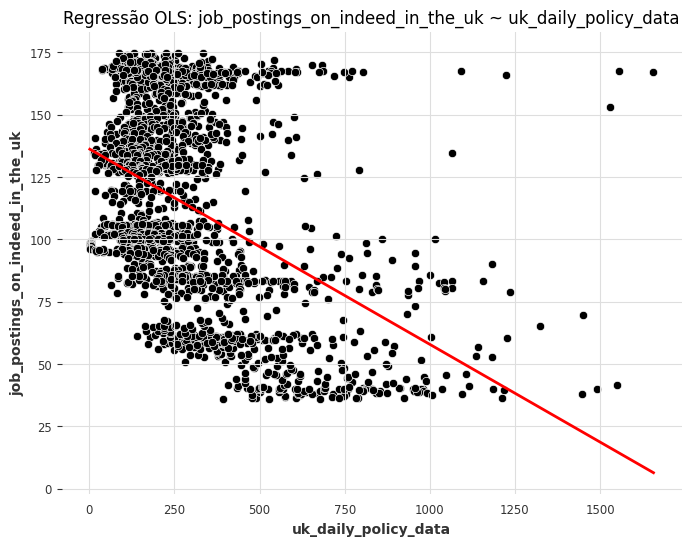

Regressão OLS para interest_rates_lt_bond_yields_10_year_main_including_benchmark_for_uk ~ uk_daily_policy_data:
                                                      OLS Regression Results                                                     
Dep. Variable:     interest_rates_lt_bond_yields_10_year_main_including_benchmark_for_uk   R-squared:                       0.090
Model:                                                                               OLS   Adj. R-squared:                  0.086
Method:                                                                    Least Squares   F-statistic:                     28.55
Date:                                                                   Tue, 20 May 2025   Prob (F-statistic):           1.85e-07
Time:                                                                           01:37:33   Log-Likelihood:                -527.83
No. Observations:                                                                    292   AIC:            

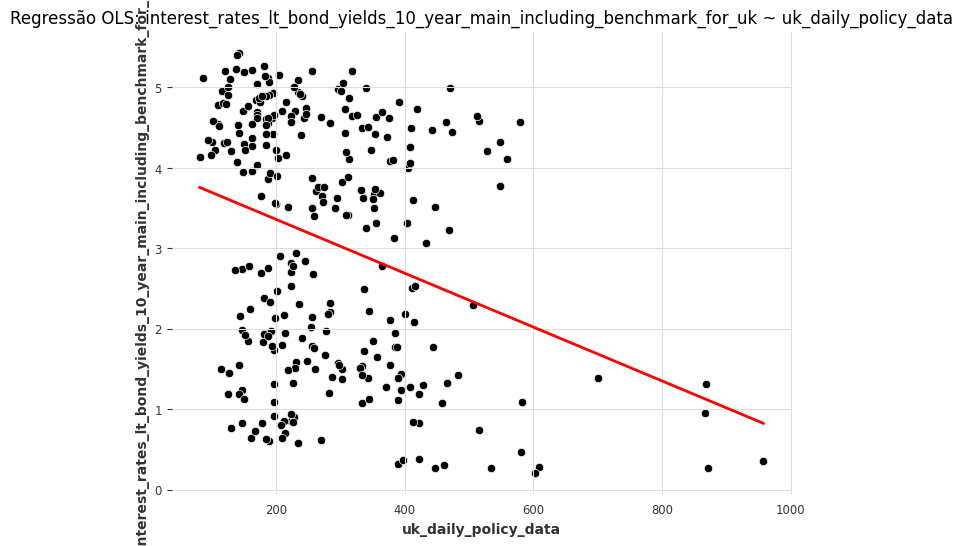

Regressão OLS para house_prices_for_uk ~ uk_daily_policy_data:
                             OLS Regression Results                            
Dep. Variable:     house_prices_for_uk   R-squared:                       0.002
Model:                             OLS   Adj. R-squared:                 -0.009
Method:                  Least Squares   F-statistic:                    0.1600
Date:                 Tue, 20 May 2025   Prob (F-statistic):              0.690
Time:                         01:37:33   Log-Likelihood:                -460.84
No. Observations:                   96   AIC:                             925.7
Df Residuals:                       94   BIC:                             930.8
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------

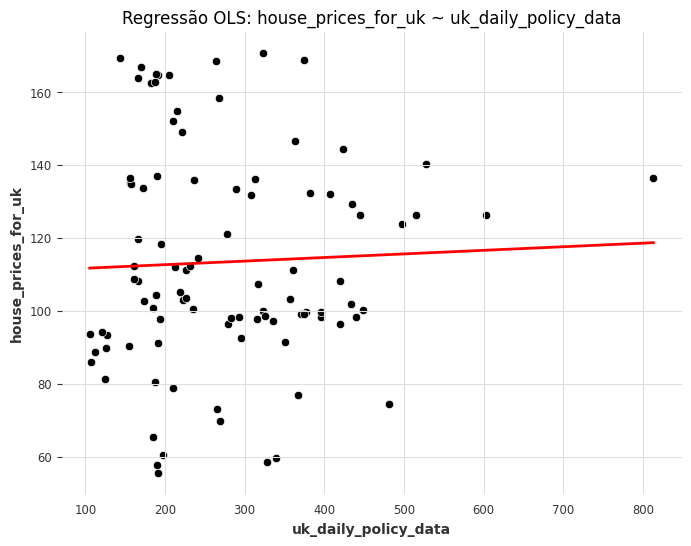

Regressão OLS para gdp_for_uk ~ uk_daily_policy_data:
                            OLS Regression Results                            
Dep. Variable:             gdp_for_uk   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.011
Method:                 Least Squares   F-statistic:                  0.004248
Date:                Tue, 20 May 2025   Prob (F-statistic):              0.948
Time:                        01:37:33   Log-Likelihood:                -1254.8
No. Observations:                  96   AIC:                             2514.
Df Residuals:                      94   BIC:                             2519.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------

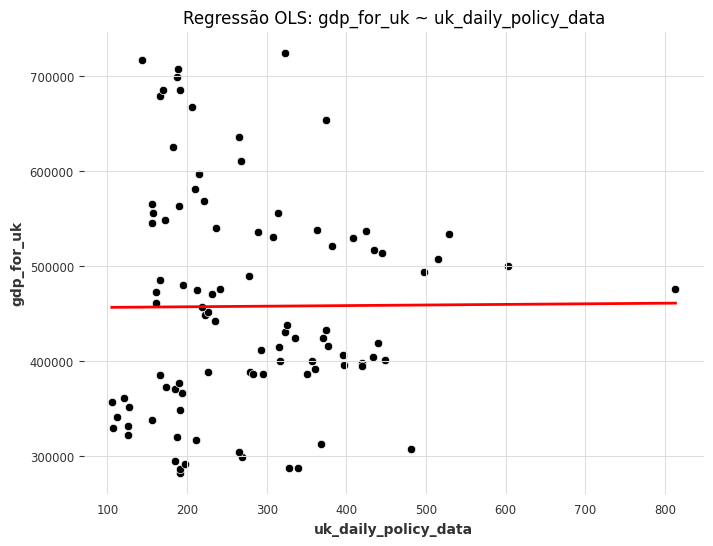

Regressão OLS para consumer_price_indices_cpis_hicps_coicop_1999_cpi_total_for_uk ~ uk_daily_policy_data:
                                                  OLS Regression Results                                                  
Dep. Variable:     consumer_price_indices_cpis_hicps_coicop_1999_cpi_total_for_uk   R-squared:                       0.005
Model:                                                                        OLS   Adj. R-squared:                  0.001
Method:                                                             Least Squares   F-statistic:                     1.350
Date:                                                            Tue, 20 May 2025   Prob (F-statistic):              0.246
Time:                                                                    01:37:33   Log-Likelihood:                -1228.1
No. Observations:                                                             291   AIC:                             2460.
Df Residuals:                    

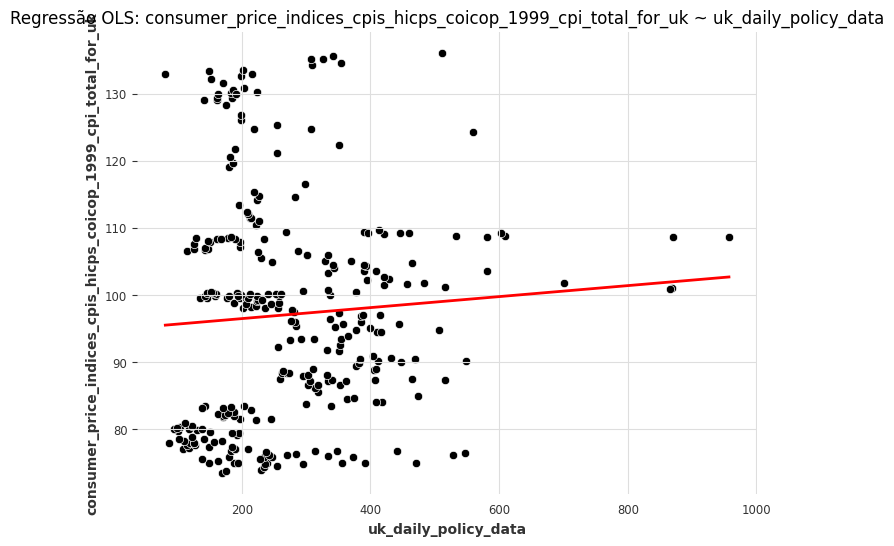


Tabela resumo das regressões OLS:


Série              Variável  \
0                   job_postings_on_indeed_in_the_uk  uk_daily_policy_data   
1  interest_rates_lt_bond_yields_10_year_main_inc...  uk_daily_policy_data   
2                                house_prices_for_uk  uk_daily_policy_data   
3                                         gdp_for_uk  uk_daily_policy_data   
4  consumer_price_indices_cpis_hicps_coicop_1999_...  uk_daily_policy_data   

   Coeficiente  Erro padrão    t-valor       p-valor  R-quadrado  \
0    -0.078336     0.003521 -22.247850  1.023298e-97    0.205469   
1    -0.003349     0.000627  -5.342780  1.853895e-07    0.089611   
2     0.009839     0.024599   0.399999  6.900645e-01    0.001699   
3     6.265638    96.134161   0.065176  9.481723e-01    0.000045   
4     0.008195     0.007053   1.161928  2.462233e-01    0.004650   

   R-quadrado Ajustado  Lag  
0             0.205053    0  
1             0.086472    0  
2            -0.008921    0  
3            -0.010593    0  
4             0.001206    0

In [ ]:
resultados_ols = []

for serie_name, (y, x) in aligned_data.items():
    resultados_ols = run_ols_regression(y, x, serie_name, fred_series_list[-1].name, resultados_ols, lag=0)

# Criar DataFrame com os resultados
df_resultados_ols = pd.DataFrame(resultados_ols)

# Mostrar tabela final
print("\nTabela resumo das regressões OLS:")
display(df_resultados_ols)

- **Coeficiente**: Mostra o efeito da política na variável.  
  - Se for **negativo**, a variável desce quando a política sobe.  
  - Se for **positivo**, a variável sobe quando a política sobe.

- **Erro padrão**: Mede a incerteza do coeficiente.  
  - **Baixo** = estimativa mais confiável.  
  - **Alto** = mais incerteza.

- **t-valor**: Diz quão forte é o efeito da política.  
  - **Alto (positivo ou negativo)** = efeito mais significativo.

- **p-valor**: Mede se o efeito pode ser só sorte.  
  - **< 0.05** = resultado é estatisticamente significativo.  
  - **> 0.05** = pode não haver efeito real.

- **R-quadrado**: Mede quanto do comportamento da variável é explicado pela política.  
  - **Alto (próximo de 1)** = política explica bem.  
  - **Baixo (perto de 0)** = política quase não explica nada.

- **R-quadrado Ajustado**: Igual ao R-quadrado, mas ajustado se houver mais variáveis.  
  - Bom para comparar modelos com diferentes números de variáveis.

Regressão OLS para job_postings_on_indeed_in_the_uk ~ uk_daily_policy_data (lag 1):
                                   OLS Regression Results                                   
Dep. Variable:     job_postings_on_indeed_in_the_uk   R-squared:                       0.207
Model:                                          OLS   Adj. R-squared:                  0.206
Method:                               Least Squares   F-statistic:                     499.1
Date:                              Tue, 20 May 2025   Prob (F-statistic):           2.02e-98
Time:                                      01:38:00   Log-Likelihood:                -9534.7
No. Observations:                              1915   AIC:                         1.907e+04
Df Residuals:                                  1913   BIC:                         1.908e+04
Df Model:                                         1                                         
Covariance Type:                          nonrobust                            

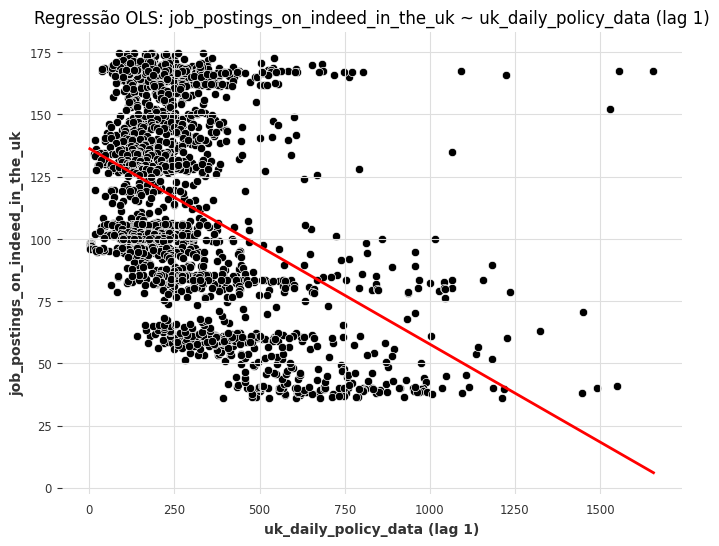

Regressão OLS para interest_rates_lt_bond_yields_10_year_main_including_benchmark_for_uk ~ uk_daily_policy_data (lag 1):
                                                      OLS Regression Results                                                     
Dep. Variable:     interest_rates_lt_bond_yields_10_year_main_including_benchmark_for_uk   R-squared:                       0.104
Model:                                                                               OLS   Adj. R-squared:                  0.101
Method:                                                                    Least Squares   F-statistic:                     33.59
Date:                                                                   Tue, 20 May 2025   Prob (F-statistic):           1.78e-08
Time:                                                                           01:38:00   Log-Likelihood:                -523.53
No. Observations:                                                                    291   AIC:    

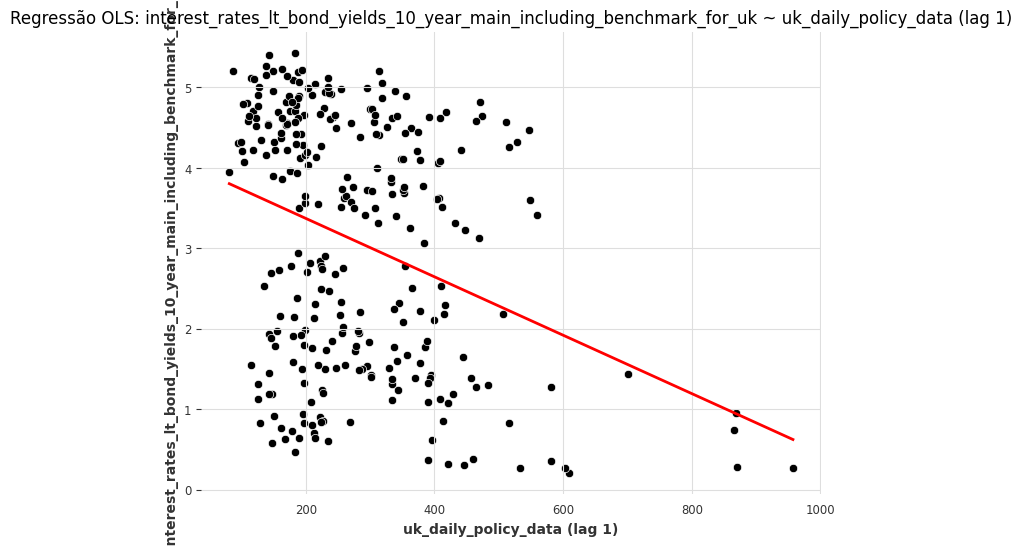

Regressão OLS para house_prices_for_uk ~ uk_daily_policy_data (lag 1):
                             OLS Regression Results                            
Dep. Variable:     house_prices_for_uk   R-squared:                       0.000
Model:                             OLS   Adj. R-squared:                 -0.010
Method:                  Least Squares   F-statistic:                   0.04006
Date:                 Tue, 20 May 2025   Prob (F-statistic):              0.842
Time:                         01:38:00   Log-Likelihood:                -454.63
No. Observations:                   95   AIC:                             913.3
Df Residuals:                       93   BIC:                             918.4
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------

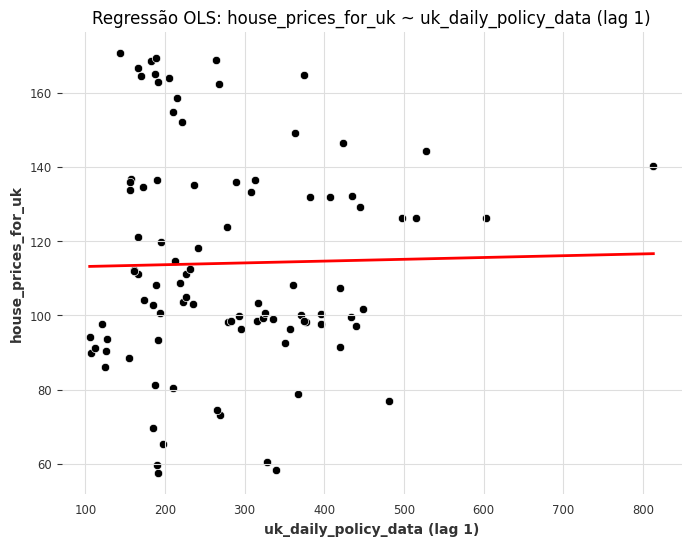

Regressão OLS para gdp_for_uk ~ uk_daily_policy_data (lag 1):
                            OLS Regression Results                            
Dep. Variable:             gdp_for_uk   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.011
Method:                 Least Squares   F-statistic:                   0.01859
Date:                Tue, 20 May 2025   Prob (F-statistic):              0.892
Time:                        01:38:00   Log-Likelihood:                -1241.1
No. Observations:                  95   AIC:                             2486.
Df Residuals:                      93   BIC:                             2491.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------

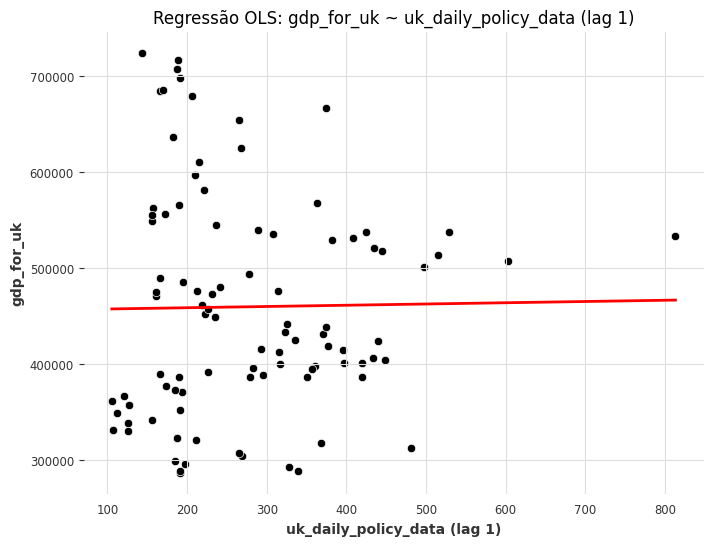

Regressão OLS para consumer_price_indices_cpis_hicps_coicop_1999_cpi_total_for_uk ~ uk_daily_policy_data (lag 1):
                                                  OLS Regression Results                                                  
Dep. Variable:     consumer_price_indices_cpis_hicps_coicop_1999_cpi_total_for_uk   R-squared:                       0.003
Model:                                                                        OLS   Adj. R-squared:                 -0.000
Method:                                                             Least Squares   F-statistic:                    0.8723
Date:                                                            Tue, 20 May 2025   Prob (F-statistic):              0.351
Time:                                                                    01:38:01   Log-Likelihood:                -1223.5
No. Observations:                                                             290   AIC:                             2451.
Df Residuals:            

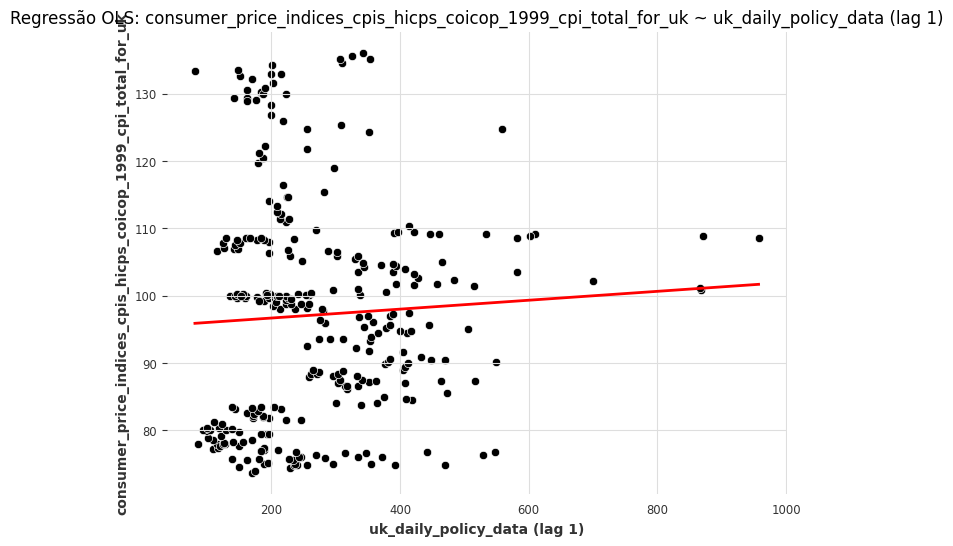


Tabela resumo das regressões OLS:


Série              Variável  \
0                   job_postings_on_indeed_in_the_uk  uk_daily_policy_data   
1  interest_rates_lt_bond_yields_10_year_main_inc...  uk_daily_policy_data   
2                                house_prices_for_uk  uk_daily_policy_data   
3                                         gdp_for_uk  uk_daily_policy_data   
4  consumer_price_indices_cpis_hicps_coicop_1999_...  uk_daily_policy_data   
5                   job_postings_on_indeed_in_the_uk  uk_daily_policy_data   
6  interest_rates_lt_bond_yields_10_year_main_inc...  uk_daily_policy_data   
7                                house_prices_for_uk  uk_daily_policy_data   
8                                         gdp_for_uk  uk_daily_policy_data   
9  consumer_price_indices_cpis_hicps_coicop_1999_...  uk_daily_policy_data   

   Coeficiente  Erro padrão    t-valor       p-valor  R-quadrado  \
0    -0.078336     0.003521 -22.247850  1.023298e-97    0.205469   
1    -0.003349     0.000627  -5.342780  1.853895e-07    0.089611   
2     0.009839     0.024599   0.399999  6.900645e-01    0.001699   
3     6.265638    96.134161   0.065176  9.481723e-01    0.000045   
4     0.008195     0.007053   1.161928  2.462233e-01    0.004650   
5    -0.078609     0.003519 -22.340005  2.021596e-98    0.206907   
6    -0.003631     0.000627  -5.795603  1.779112e-08    0.104123   
7     0.004855     0.024256   0.200144  8.418049e-01    0.000431   
8    13.025264    95.522695   0.136358  8.918332e-01    0.000200   
9     0.006614     0.007081   0.933946  3.511140e-01    0.003020   

   R-quadrado Ajustado  Lag  
0             0.205053    0  
1             0.086472    0  
2            -0.008921    0  
3            -0.010593    0  
4             0.001206    0  
5             0.206493    1  
6             0.101023    1  
7            -0.010318    1  
8            -0.010551    1  
9            -0.000442    1

In [ ]:
for serie_name, (y, x) in aligned_data.items():
    resultados_ols = run_ols_regression(y, x, serie_name, fred_series_list[-1].name, lag=1, resultados_ols = resultados_ols)

# Criar DataFrame com os resultados
df_resultados_ols = pd.DataFrame(resultados_ols)

# Mostrar tabela final
print("\nTabela resumo das regressões OLS:")
display(df_resultados_ols)


### 4.5. Modelo ARDL - (é auto-regressivo, então é só interessante de conhecer)

O modelo ARDL representa uma relação entre uma variável dependente e os valores defasados (lags) dessa variável e das variáveis independentes. É útil para estudar efeitos dinâmicos no tempo, mesmo quando as séries não são estacionárias no nível (mas sim estacionárias em primeira diferença, i.e., I(1)).

A formulação geral de um modelo ARDL(p, q) com uma variável explicativa é:

$$
Y_t = \alpha_0 + \sum_{i=1}^{p} \alpha_i Y_{t-i} + \sum_{j=0}^{q} \beta_j X_{t-j} + \varepsilon_t
$$

---

**Onde:**

- $Y_t$: variável dependente no tempo $t$
- $Y_{t-i}$: defasagens da variável dependente (com $i = 1, \dots, p$)
- $X_{t-j}$: defasagens da variável independente (com $j = 0, \dots, q$ — pode incluir o valor contemporâneo de $X$)
- $\alpha_0$: intercepto
- $\alpha_i, \beta_j$: coeficientes a estimar
- $\varepsilon_t$: termo de erro aleatório (white noise)

> O termo **"Autoregressive"** refere-se aos lags de $Y_t$ e **"Distributed Lag"** refere-se aos lags de $X_t$.


Resumo ARDL: job_postings_on_indeed_in_the_uk ~ ['uk_daily_policy_data']
                                     ARDL Model Results                                     
Dep. Variable:     job_postings_on_indeed_in_the_uk   No. Observations:                 1916
Model:                                     ARDL(4,)   Log Likelihood                 890.296
Method:                             Conditional MLE   S.D. of innovations              0.152
Date:                              Tue, 20 May 2025   AIC                          -1768.593
Time:                                      02:26:19   BIC                          -1735.257
Sample:                                  02-05-2020   HQIC                         -1756.325
                                       - 04-30-2025                                         
                                          coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------

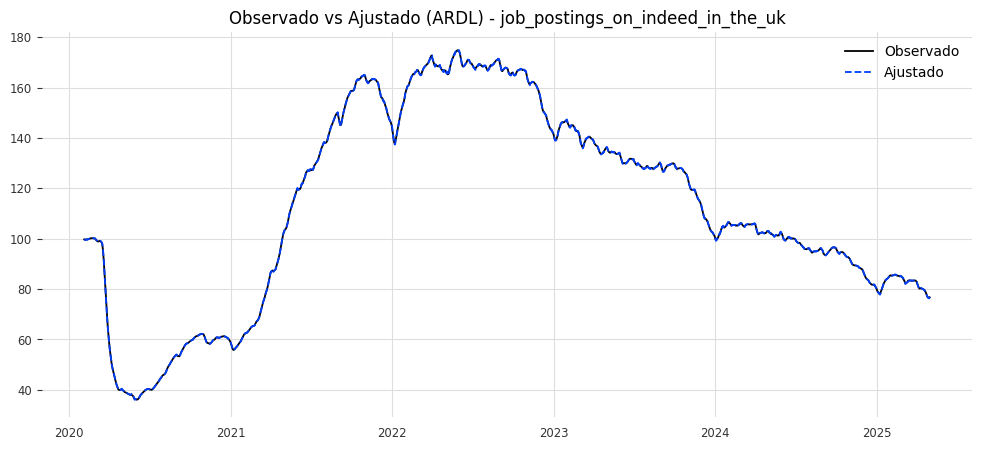


Resumo ARDL: interest_rates_lt_bond_yields_10_year_main_including_benchmark_for_uk ~ ['uk_daily_policy_data']
                                                        ARDL Model Results                                                       
Dep. Variable:     interest_rates_lt_bond_yields_10_year_main_including_benchmark_for_uk   No. Observations:                  292
Model:                                                                        ARDL(4, 0)   Log Likelihood                  92.142
Method:                                                                  Conditional MLE   S.D. of innovations              0.176
Date:                                                                   Tue, 20 May 2025   AIC                           -170.285
Time:                                                                           02:26:19   BIC                           -144.644
Sample:                                                                       05-01-2001   HQIC              

c:\Users\diogo\Desktop\ASTP\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\diogo\Desktop\ASTP\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


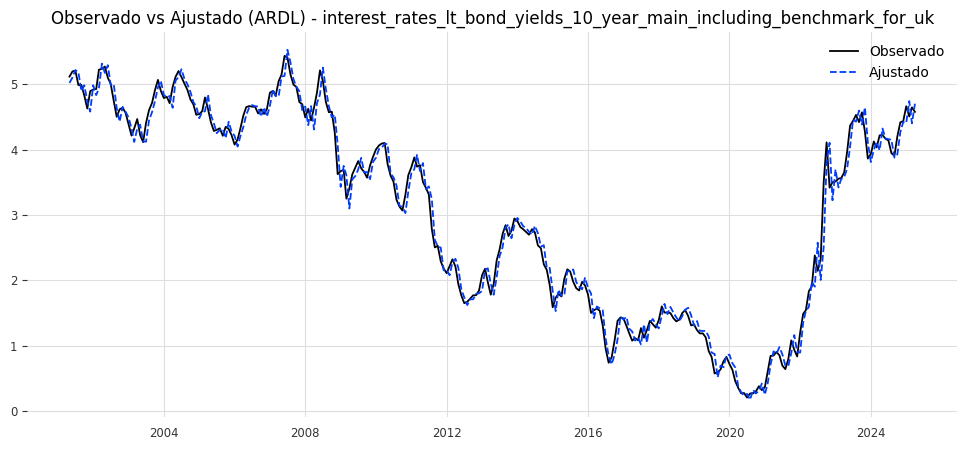


Resumo ARDL: house_prices_for_uk ~ ['uk_daily_policy_data']
                               ARDL Model Results                              
Dep. Variable:     house_prices_for_uk   No. Observations:                   96
Model:                        ARDL(4,)   Log Likelihood                -175.722
Method:                Conditional MLE   S.D. of innovations              1.634
Date:                 Tue, 20 May 2025   AIC                            363.445
Time:                         02:26:19   BIC                            378.576
Sample:                     01-01-2002   HQIC                           369.552
                          - 10-01-2024                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      1.1758      0.752      1.564      0.121      -0.319       2.670
house_prices_for_uk.L1    

c:\Users\diogo\Desktop\ASTP\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
c:\Users\diogo\Desktop\ASTP\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


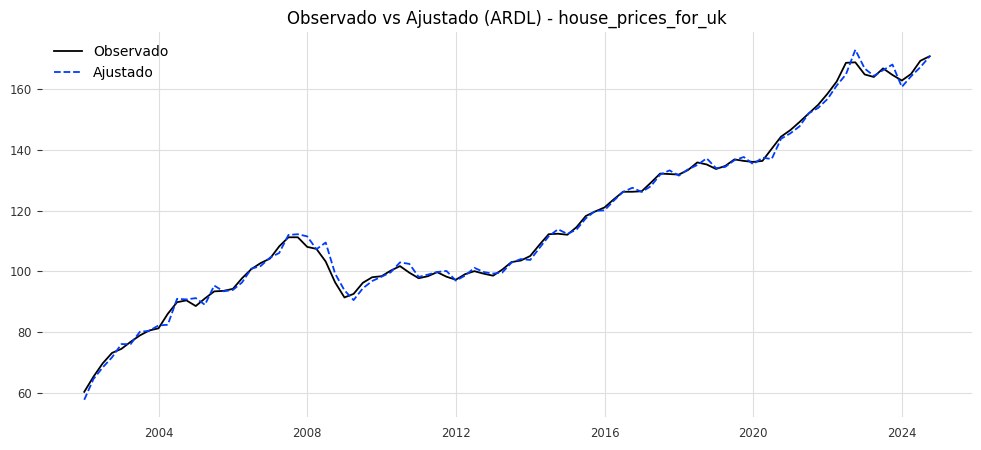


Resumo ARDL: gdp_for_uk ~ ['uk_daily_policy_data']
                              ARDL Model Results                              
Dep. Variable:             gdp_for_uk   No. Observations:                   96
Model:                     ARDL(2, 0)   Log Likelihood               -1007.031
Method:               Conditional MLE   S.D. of innovations          10874.292
Date:                Tue, 20 May 2025   AIC                           2024.062
Time:                        02:26:19   BIC                           2036.778
Sample:                    07-01-2001   HQIC                          2029.198
                         - 10-01-2024                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                    1278.5218   5159.776      0.248      0.805   -8972.274    1.15e+04
gdp_for_uk.L1               0.7476      

c:\Users\diogo\Desktop\ASTP\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
c:\Users\diogo\Desktop\ASTP\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


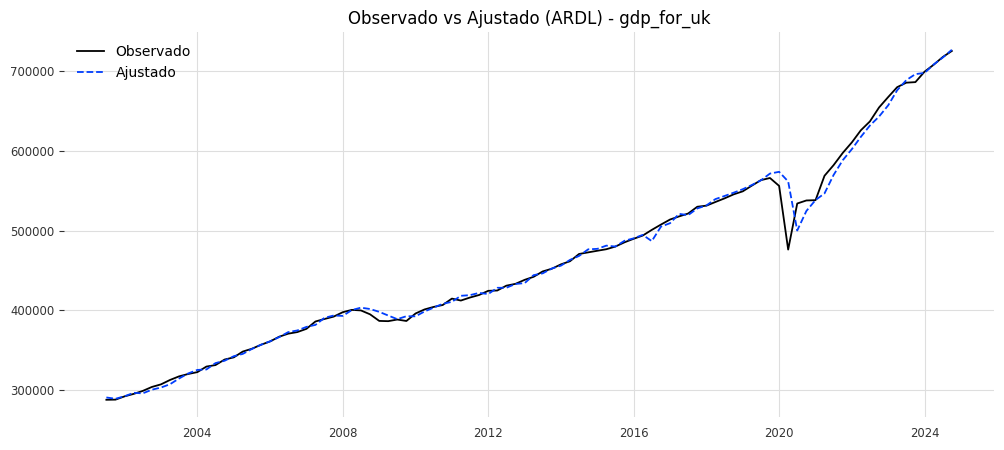


Resumo ARDL: consumer_price_indices_cpis_hicps_coicop_1999_cpi_total_for_uk ~ ['uk_daily_policy_data']


c:\Users\diogo\Desktop\ASTP\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\diogo\Desktop\ASTP\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                                    ARDL Model Results                                                    
Dep. Variable:     consumer_price_indices_cpis_hicps_coicop_1999_cpi_total_for_uk   No. Observations:                  291
Model:                                                                 ARDL(3, 1)   Log Likelihood                 -87.186
Method:                                                           Conditional MLE   S.D. of innovations              0.328
Date:                                                            Tue, 20 May 2025   AIC                            188.373
Time:                                                                    02:26:19   BIC                            214.014
Sample:                                                                04-01-2001   HQIC                           198.648
                                                                     - 03-01-2025                                         
                

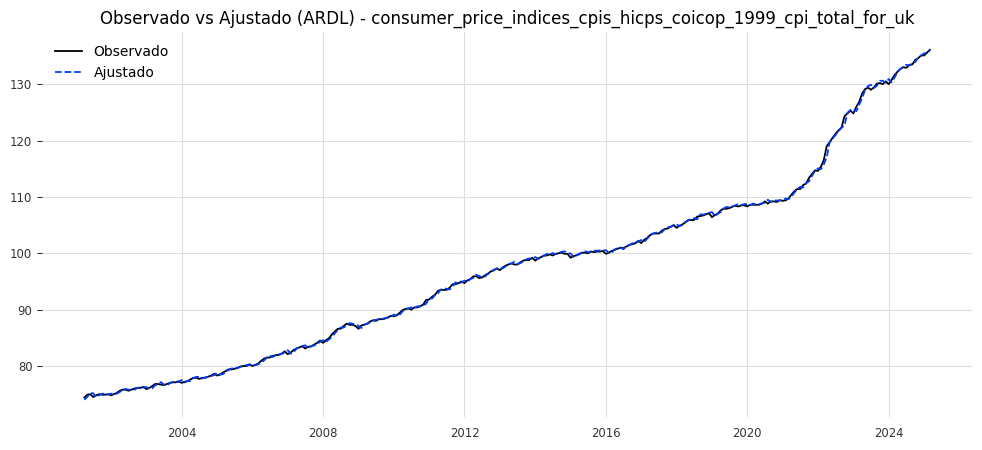


Tabela resumo das regressões ARDL:


Série dependente  \
0                    job_postings_on_indeed_in_the_uk   
1                    job_postings_on_indeed_in_the_uk   
2                    job_postings_on_indeed_in_the_uk   
3                    job_postings_on_indeed_in_the_uk   
4                    job_postings_on_indeed_in_the_uk   
5   interest_rates_lt_bond_yields_10_year_main_inc...   
6   interest_rates_lt_bond_yields_10_year_main_inc...   
7   interest_rates_lt_bond_yields_10_year_main_inc...   
8   interest_rates_lt_bond_yields_10_year_main_inc...   
9   interest_rates_lt_bond_yields_10_year_main_inc...   
10  interest_rates_lt_bond_yields_10_year_main_inc...   
11                                house_prices_for_uk   
12                                house_prices_for_uk   
13                                house_prices_for_uk   
14                                house_prices_for_uk   
15                                house_prices_for_uk   
16                                         gdp_for_uk   
17                                         gdp_for_uk   
18                                         gdp_for_uk   
19                                         gdp_for_uk   
20  consumer_price_indices_cpis_hicps_coicop_1999_...   
21  consumer_price_indices_cpis_hicps_coicop_1999_...   
22  consumer_price_indices_cpis_hicps_coicop_1999_...   
23  consumer_price_indices_cpis_hicps_coicop_1999_...   
24  consumer_price_indices_cpis_hicps_coicop_1999_...   
25  consumer_price_indices_cpis_hicps_coicop_1999_...   

                                 Variável explicativa  Coeficiente  \
0                                               const     0.008878   
1                 job_postings_on_indeed_in_the_uk.L1     1.999534   
2                 job_postings_on_indeed_in_the_uk.L2    -0.976317   
3                 job_postings_on_indeed_in_the_uk.L3    -0.121912   
4                 job_postings_on_indeed_in_the_uk.L4     0.098610   
5                                               const     0.075542   
6   interest_rates_lt_bond_yields_10_year_main_inc...     1.309948   
7   interest_rates_lt_bond_yields_10_year_main_inc...    -0.507710   
8   interest_rates_lt_bond_yields_10_year_main_inc...     0.305373   
9   interest_rates_lt_bond_yields_10_year_main_inc...    -0.120861   
10                            uk_daily_policy_data.L0    -0.000127   
11                                              const     1.175762   
12                             house_prices_for_uk.L1     1.832921   
13                             house_prices_for_uk.L2    -1.514049   
14                             house_prices_for_uk.L3     1.132557   
15                             house_prices_for_uk.L4    -0.457539   
16                                              const  1278.521813   
17                                      gdp_for_uk.L1     0.747576   
18                                      gdp_for_uk.L2     0.269706   
19                            uk_daily_policy_data.L0   -10.346619   
20                                              const    -0.234648   
21  consumer_price_indices_cpis_hicps_coicop_1999_...     1.121381   
22  consumer_price_indices_cpis_hicps_coicop_1999_...     0.010795   
23  consumer_price_indices_cpis_hicps_coicop_1999_...    -0.127734   
24                            uk_daily_policy_data.L0    -0.000418   
25                            uk_daily_policy_data.L1     0.000301   

    Erro padrão    t-valor       p-valor  R-quadrado  R-quadrado Ajustado  
0      0.010544   0.841975  3.999077e-01    0.999985             0.999985  
1      0.022788  87.746251  0.000000e+00    0.999985             0.999985  
2      0.051069 -19.117638  1.117306e-74    0.999985             0.999985  
3      0.051096  -2.385956  1.713183e-02    0.999985             0.999985  
4      0.022811   4.322901  1.619300e-05    0.999985             0.999985  
5      0.031340   2.410388  1.657561e-02    0.987029             0.986799  
6      0.058676  22.325034  2.759108e-64    0.987029             0.986799 

In [ ]:
from statsmodels.tsa.ardl import ardl_select_order
from sklearn.metrics import r2_score

resultados_ardl = []

def run_ardl_model(y, x):
    # Garantir que são Series/DataFrame com nome
    assert isinstance(y, pd.Series), "y deve ser pd.Series"
    assert isinstance(x, pd.Series) or isinstance(x, pd.DataFrame), "x deve ser pd.Series ou pd.DataFrame"
    
    # Se x for Series, converte para DataFrame
    if isinstance(x, pd.Series):
        x = x.to_frame()

    # Alinhar e eliminar NaNs
    combined = pd.concat([y, x], axis=1).dropna()
    y_aligned = combined.iloc[:, 0]
    x_aligned = combined.iloc[:, 1:]

    min_len = len(y_aligned)
    max_possible_lags = max(1, min_len // 5)
    lags_to_use = min(4, max_possible_lags)

    if min_len < (lags_to_use + 1) * 3:
        raise ValueError(f"Número insuficiente de observações ({min_len}) para os lags escolhidos ({lags_to_use}).")

    sel = ardl_select_order(endog=y_aligned, exog=x_aligned, maxlag=lags_to_use, maxorder=lags_to_use, ic='hqic') # endog -> Varia
    ardl_model = sel.model.fit()

    print(f"\nResumo ARDL: {y.name} ~ {list(x_aligned.columns)}")
    print(ardl_model.summary())

    y_for_plot = y_aligned.loc[ardl_model.fittedvalues.index]

    plt.figure(figsize=(12, 5))
    plt.plot(y_for_plot.index, y_for_plot, label='Observado')
    plt.plot(ardl_model.fittedvalues.index, ardl_model.fittedvalues, label='Ajustado', linestyle='--')
    plt.title(f"Observado vs Ajustado (ARDL) - {y.name}")
    plt.legend()
    plt.show()

    r_squared = r2_score(y_for_plot, ardl_model.fittedvalues)
    n = len(ardl_model.fittedvalues)
    k = len(ardl_model.params) - 1
    r_squared_adj = 1 - (1 - r_squared) * (n - 1) / (n - k - 1)

    for var in ardl_model.params.index:
        resultados_ardl.append({
            'Série dependente': y.name,
            'Variável explicativa': var,
            'Coeficiente': ardl_model.params[var],
            'Erro padrão': ardl_model.bse[var],
            't-valor': ardl_model.tvalues[var],
            'p-valor': ardl_model.pvalues[var],
            'R-quadrado': r_squared,
            'R-quadrado Ajustado': r_squared_adj,
        })

uk_policy_series = next(s for s in fred_series_list if s.name == 'uk_daily_policy_data')

for serie_name, (y, _) in aligned_data.items():
    if serie_name == 'uk_daily_policy_data':
        continue
    try:
        run_ardl_model(y, uk_policy_series)
    except Exception as e:
        print(f"Erro no modelo ARDL para {serie_name}: {e}")

df_resultados_ardl = pd.DataFrame(resultados_ardl)
print("\nTabela resumo das regressões ARDL:")
display(df_resultados_ardl)

### 4.6. Análise de volatilidade com GARCH‑X(p,q) nas séries tratadas

O modelo **GARCH‑X(p,q)** estende o clássico GARCH(p,q) ao incluir variáveis exógenas na equação da variância condicional, permitindo que fatores externos influenciem a volatilidade.

---

**📐 Formulação do modelo GARCH‑X(p,q)**

1. **Equação de retorno (média)**  
$ r_t = \mu + \varepsilon_t,\quad \varepsilon_t \sim \mathcal{N}(0,\,h_t) $

2. **Equação da variância condicional**  
$ h_t = \omega + \sum_{i=1}^{q} \alpha_i\,\varepsilon_{t-i}^2 + \sum_{j=1}^{p} \beta_j\,h_{t-j} + \sum_{k=0}^{K} \delta_k\,X_{t-k} $

Onde:  
- $r_t$: retorno no tempo \(t\)  
- $\mu$: média condicional (geralmente zero)  
- $\varepsilon_t$: termo de erro no tempo \(t\)  
- $h_t$: variância condicional no tempo \(t\)  
- $\omega$: constante (variância base)  
- $\alpha_i$: coeficientes ARCH (impacto dos choques passados)  
- $\beta_j$: coeficientes GARCH (persistência da variância passada)  
- $X_{t-k}$: variáveis exógenas defasadas até \(K\) períodos  
- $\delta_k$: coeficientes das variáveis exógenas na volatilidade

**🧠 Interpretação dos parâmetros**

- **$\alpha_i$ (ARCH):**  
  Valores elevados indicam forte impacto dos choques passados na volatilidade atual.

- **$\beta_j$ (GARCH):**  
  Valores elevados indicam que a volatilidade persiste por mais tempo (memória longa).

- **$\sum_i \alpha_i + \sum_j \beta_j < 1$:**  
  Condição necessária para a estacionariedade da variância condicional.

- **$\delta_k$ (exógenas):**  
  Se significativos, indicam que as variáveis exógenas \(X_{t-k}\) influenciam a volatilidade.  
  - Sinal positivo → aumentam a volatilidade.  
  - Sinal negativo → diminuem a volatilidade.

---

> **Nota:**  
> - $p$ e $q$ são as ordens do modelo para variância passada e choques passados, respetivamente.  
> - A escolha dos lags $K$ das variáveis exógenas pode ser feita com base em critérios de informação (AIC, BIC) ou testes estatísticos.


### Análise de volatilidade com GARCH-X(p,q) nas séries tratadas ###

Ajustando GARCH‑X(2,2) para job_postings_on_indeed_in_the_uk…
                                 AR-X - GARCH Model Results                                 
Dep. Variable:     job_postings_on_indeed_in_the_uk   R-squared:                      -0.004
Mean Model:                                    AR-X   Adj. R-squared:                 -0.005
Vol Model:                                    GARCH   Log-Likelihood:               -31.6208
Distribution:                                Normal   AIC:                           77.2416
Method:                          Maximum Likelihood   BIC:                           116.144
                                                      No. Observations:                 1915
Date:                              Tue, May 20 2025   Df Residuals:                     1913
Time:                                      18:31:15   Df Model:                            2
                               

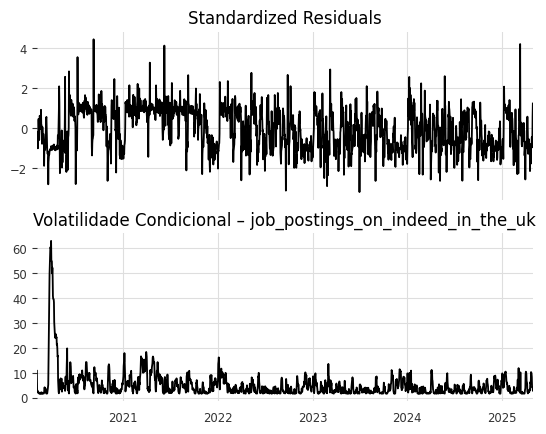


Ajustando GARCH‑X(2,2) para interest_rates_lt_bond_yields_10_year_main_including_benchmark_for_uk…
                                                    AR-X - GARCH Model Results                                                   
Dep. Variable:     interest_rates_lt_bond_yields_10_year_main_including_benchmark_for_uk   R-squared:                       0.013
Mean Model:                                                                         AR-X   Adj. R-squared:                  0.010
Vol Model:                                                                         GARCH   Log-Likelihood:               -981.409
Distribution:                                                                     Normal   AIC:                           1976.82
Method:                                                               Maximum Likelihood   BIC:                           2002.53
                                                                                           No. Observations:            

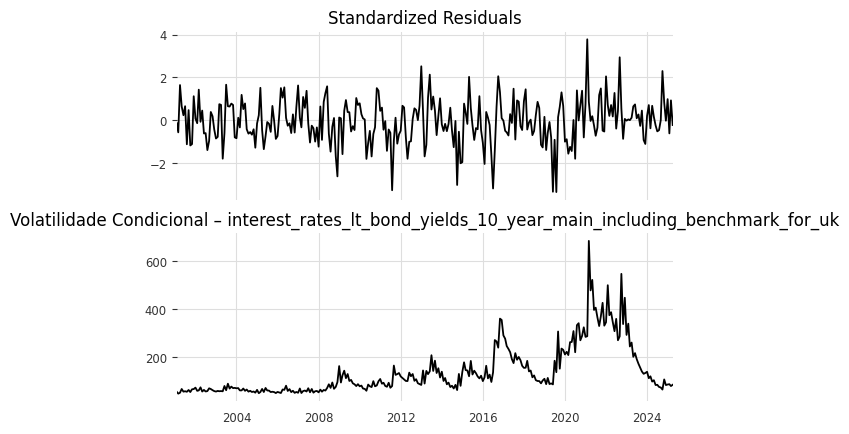


Ajustando GARCH‑X(2,2) para house_prices_for_uk…
                           AR-X - GARCH Model Results                          
Dep. Variable:     house_prices_for_uk   R-squared:                       0.001
Mean Model:                       AR-X   Adj. R-squared:                 -0.010
Vol Model:                       GARCH   Log-Likelihood:               -201.414
Distribution:                   Normal   AIC:                           416.828
Method:             Maximum Likelihood   BIC:                           434.705
                                         No. Observations:                   95
Date:                 Tue, May 20 2025   Df Residuals:                       93
Time:                         18:31:15   Df Model:                            2
                                       Mean Model                                      
                           coef    std err          t      P>|t|       95.0% Conf. Int.
------------------------------------------------------

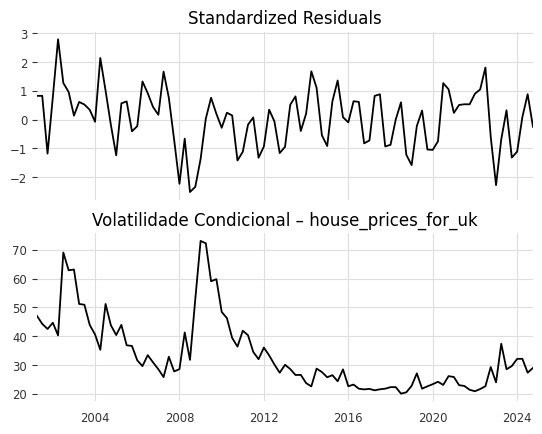


Ajustando GARCH‑X(2,2) para gdp_for_uk…
                          AR-X - GARCH Model Results                          
Dep. Variable:             gdp_for_uk   R-squared:                       0.005
Mean Model:                      AR-X   Adj. R-squared:                 -0.005
Vol Model:                      GARCH   Log-Likelihood:               -132.527
Distribution:                  Normal   AIC:                           279.053
Method:            Maximum Likelihood   BIC:                           296.930
                                        No. Observations:                   95
Date:                Tue, May 20 2025   Df Residuals:                       93
Time:                        18:31:16   Df Model:                            2
                                       Mean Model                                       
                            coef    std err          t      P>|t|       95.0% Conf. Int.
----------------------------------------------------------------------

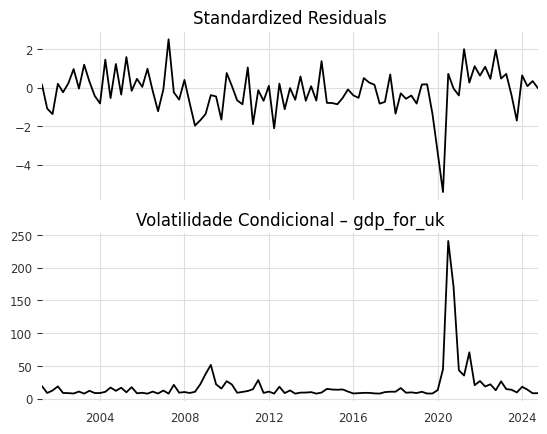


Ajustando GARCH‑X(2,2) para consumer_price_indices_cpis_hicps_coicop_1999_cpi_total_for_uk…
                                                AR-X - GARCH Model Results                                                
Dep. Variable:     consumer_price_indices_cpis_hicps_coicop_1999_cpi_total_for_uk   R-squared:                      -0.016
Mean Model:                                                                  AR-X   Adj. R-squared:                 -0.020
Vol Model:                                                                  GARCH   Log-Likelihood:               -80.8112
Distribution:                                                              Normal   AIC:                           175.622
Method:                                                        Maximum Likelihood   BIC:                           201.312
                                                                                    No. Observations:                  290
Date:                                         

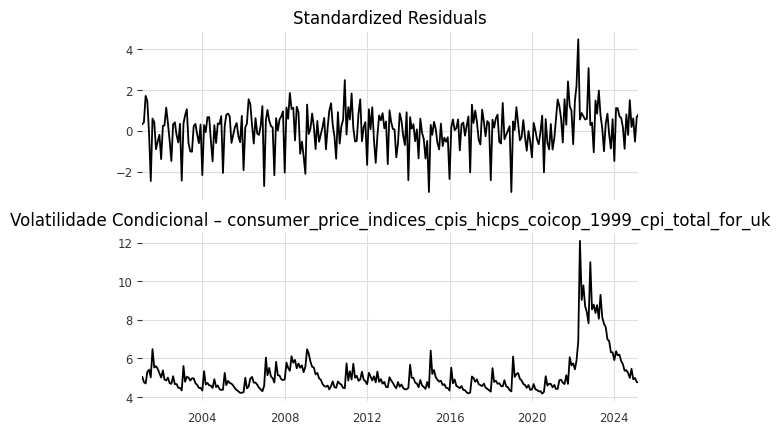


### Sumário Interpretativo dos Resultados GARCH‑X ###

Série: job_postings_on_indeed_in_the_uk
 - uk_daily_policy_data: -0.0000 (p‑valor=0.0004)
   => Efeito negativo e estatisticamente significativo ao nível de 5%.

Série: interest_rates_lt_bond_yields_10_year_main_including_benchmark_for_uk
 - uk_daily_policy_data: -0.0318 (p‑valor=0.0227)
   => Efeito negativo e estatisticamente significativo ao nível de 5%.

Série: house_prices_for_uk
 - uk_daily_policy_data: 0.0016 (p‑valor=0.7532)
   => Não estatisticamente significativo.

Série: gdp_for_uk
 - uk_daily_policy_data: -0.0007 (p‑valor=0.8480)
   => Não estatisticamente significativo.

Série: consumer_price_indices_cpis_hicps_coicop_1999_cpi_total_for_uk
 - uk_daily_policy_data: -0.0008 (p‑valor=0.2428)
   => Não estatisticamente significativo.



In [ ]:
from arch import arch_model
import pandas as pd
import matplotlib.pyplot as plt

print("### Análise de volatilidade com GARCH-X(p,q) nas séries tratadas ###")

resultados_garch_x = []
series_ignoradas = []
lags = 0
p = 2
q = 2

for serie_name, (y, policy_series) in aligned_data.items():

    # 1) Retornos percentuais
    returns = 100 * y.pct_change().dropna()
    policy_returns = 100 * policy_series.pct_change().dropna()

    # 2) Alinhamento temporal
    idx = returns.index.intersection(policy_returns.index)
    returns_aligned = returns.loc[idx]
    exog = policy_returns.loc[idx].to_frame(name='uk_daily_policy_data')

    # 3) Verificações
    if len(returns_aligned) < 50 or exog.isna().any().any():
        series_ignoradas.append(serie_name)
        print(f"{serie_name}: dados insuficientes ou NaNs — ignorada.")
        continue

    print(f"\nAjustando GARCH‑X({p},{q}) para {serie_name}…")

    # 4) Modelo ARX-GARCH com variável exógena
    model = arch_model(
        returns_aligned,
        mean='ARX', lags=lags,
        vol='Garch', p=p, q=q,
        dist='normal',
        x=exog
    )
    fit = model.fit(disp='off')
    print(fit.summary())

    # 5) Armazenar parâmetros estimados
    for param in fit.params.index:
        resultados_garch_x.append({
            'Série': serie_name,
            'Parâmetro': param,
            'Coeficiente': fit.params[param],
            'Erro padrão': fit.std_err[param],
            't-valor': fit.tvalues[param],
            'p-valor': fit.pvalues[param]
        })

    # 6) Métricas de ajuste
    resultados_garch_x.append({
        'Série': serie_name,
        'Parâmetro': 'Log-Likelihood',
        'Coeficiente': fit.loglikelihood,
        'Erro padrão': None, 't-valor': None, 'p-valor': None
    })
    resultados_garch_x.append({
        'Série': serie_name,
        'Parâmetro': 'AIC',
        'Coeficiente': fit.aic,
        'Erro padrão': None, 't-valor': None, 'p-valor': None
    })

    # 7) Gráfico de volatilidade
    fit.plot(annualize='D')
    plt.title(f"Volatilidade Condicional – {serie_name}")
    plt.show()

# 8) DataFrame final com resultados
df_results = pd.DataFrame(resultados_garch_x)

# === Sumário interpretativo dos resultados ===
print("\n### Sumário Interpretativo dos Resultados GARCH‑X ###\n")
for serie in df_results['Série'].unique():
    sub = df_results[df_results['Série'] == serie]
    exog_params = sub[sub['Parâmetro'].str.contains('uk_daily_policy_data')]

    if exog_params.empty:
        print(f"{serie}: nenhuma variável exógena estimada.\n")
        continue

    print(f"Série: {serie}")
    for _, row in exog_params.iterrows():
        coef = row['Coeficiente']
        pval = row['p-valor']
        nome = row['Parâmetro']
        print(f" - {nome}: {coef:.4f} (p‑valor={pval:.4f})")
        if pval < 0.05:
            sinal = "positivo" if coef > 0 else "negativo"
            print(f"   => Efeito {sinal} e estatisticamente significativo ao nível de 5%.\n")
        else:
            print("   => Não estatisticamente significativo.\n")

# 9) Séries ignoradas
if series_ignoradas:
    print("Séries ignoradas por falta de dados ou NaNs:")
    for s in series_ignoradas:
        print(f"- {s}")

- - -